In [1]:
%reset -f

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
plt.rcParams['figure.figsize'] = (10.0, 6.0)

In [3]:
import scipy.stats

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D

In [5]:
import collections

In [6]:
import pickle

In [7]:
import bridson

In [8]:
import sklearn.preprocessing
import sklearn.model_selection

In [9]:
import uproot
uproot.default_library = "np"

In [10]:
import os.path

In [11]:
import logging
logging.basicConfig(level=logging.INFO)

In [12]:
np.set_printoptions(precision=4, suppress=True)

In [13]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=1)

In [14]:
def to_numpy(t):
    return t.detach().cpu().numpy()
def to_numpy_(*t_):
    return (to_numpy(t) for t in t_)
def from_numpy(t, dtype=torch.float, device=device):
    return torch.as_tensor(t, dtype=dtype, device=device)
def from_numpy_(*t_, dtype=torch.float, device=device):
    return (from_numpy(t, dtype=dtype, device=device) for t in t_)
def as_numpy(f, dtype=torch.float, device=device):
    return lambda *x: to_numpy(f(*from_numpy_(*x, dtype=dtype, device=device)))
def as_numpy_(f, dtype=torch.float, device=device):
    return lambda *x: to_numpy_(*f(*from_numpy_(*x, dtype=dtype, device=device)))

In [15]:
class Lambda(torch.nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
    def forward(self, x):
        return self.fn(x)

In [16]:
def clone_model(model, force_eval=True, set_to_none=True):
    if force_eval:
        model.eval()
    model.zero_grad(set_to_none=set_to_none)
    return pickle.loads(pickle.dumps(model))

### Data

In [19]:
class DataFile(object):
    def __init__(self, path, name):
        self.path = path
        self.name = name
        self.raw = uproot.open(self.path)
    def features(self):
        return self.raw.keys()
    def true_features(self):
        return [name for name in self.raw.keys() if "TRUE" in name]
    def __len__(self):
        return self.raw.num_entries
    def __item__(self, name):
        return self.raw[name].array(library="np")
    def get(self, features, aliases={}):
        res = self.raw.arrays(features, aliases=aliases, library="np")
        array = np.empty((self.raw.num_entries, len(features)), dtype=float)
        for i, feature in enumerate(features):
            array[:,i] = res[feature]
        return array

In [17]:
channel_names = [
    r"B⁺→K⁺ee",
    r"B⁺→K⁺J/ψ(→ee)",
    r"B⁺→K⁺ψ(2S)(→ee)",
    r"D⁺→π⁺φ(→ee)",
]

In [25]:
tree_names = [
    "RapidSim/B2Kee_tree-2Dhits.root:DecayTree;27",
    "RapidSim/B2KJpsi2ee_tree-2Dhits.root:DecayTree;34",
    "RapidSim/B2Kpsi2s2ee_tree-2Dhits.root:DecayTree;35",
    "RapidSim/D2phipi2ee_tree-2Dhits.root:DecayTree;30",
]

In [26]:
basedir = os.path.expanduser("~/2021/")
files = [DataFile(os.path.join(basedir, path), name) for path, name in zip(tree_names, channel_names)]

In [27]:
def common_features(fs):
    return sorted(set.intersection(*[set(f.true_features()) for f in fs]))
common_features(files)

['angle_ee_TRUE',
 'em_ET_TRUE',
 'em_E_TRUE',
 'em_IP_TRUE',
 'em_PT_TRUE',
 'em_PT_TRUE_',
 'em_PX_TRUE',
 'em_PY_TRUE',
 'em_PZ_TRUE',
 'em_P_TRUE',
 'em_SIGMAIP_TRUE',
 'em_eta_TRUE',
 'em_origX_TRUE',
 'em_origY_TRUE',
 'em_origZ_TRUE',
 'em_phi_TRUE',
 'ep_ET_TRUE',
 'ep_E_TRUE',
 'ep_IP_TRUE',
 'ep_PT_TRUE',
 'ep_PT_TRUE_',
 'ep_PX_TRUE',
 'ep_PY_TRUE',
 'ep_PZ_TRUE',
 'ep_P_TRUE',
 'ep_SIGMAIP_TRUE',
 'ep_eta_TRUE',
 'ep_origX_TRUE',
 'ep_origY_TRUE',
 'ep_origZ_TRUE',
 'ep_phi_TRUE',
 'q2_TRUE']

### Event selection

In [29]:
class SelectedData(object):
    def __init__(self, datafile, selector):
        assert selector.shape == (len(datafile), )
        self.datafile = datafile
        self.index = np.asarray(selector, dtype=bool)
        self.size = np.sum(self.index)
    def name(self):
        return self.datafile.name
    def get(self, features, aliases={}):
        return self.datafile.get(features, aliases=aliases)[self.index]
    def true_features(self):
        return self.datafile.true_features()
    def features(self):
        return self.datafile.features()
    def __len__(self):
        return self.size

In [30]:
def split(selected, **options):
    selector = selected.index
    arr = np.arange(len(selector))[selector]
    train_index, test_index = sklearn.model_selection.train_test_split(arr, **options)
    train_selector = np.zeros_like(selector, dtype=bool)
    test_selector = np.zeros_like(selector, dtype=bool)
    train_selector[train_index] = True
    test_selector[test_index] = True
    train = SelectedData(selected.datafile, train_selector)
    test = SelectedData(selected.datafile, test_selector)
    return train, test

In [31]:
def join_and(*conditions):
    return "&".join(["(%s)"%condition for condition in conditions])
def q2_range(v1, v2):
    return join_and("q2_TRUE > %g" % v1, "q2_TRUE < %g" % v2)

In [32]:
q_Kll_selector = q2_range(1.1, 6.0)
q_Jpsi_e_selector = q2_range(6.0, 12.96)
q_Jpsi_mu_selector = q2_range(8.68, 10.09)
q_psi2S_e_selector = q2_range(9.82, 16.40)
q_psi2S_mu_selector = q2_range(12.5, 14.2)

In [33]:
selectors = [
    q_Kll_selector,
    q_Jpsi_e_selector,
    q_psi2S_e_selector,
    "True",
]

In [34]:
selected = [SelectedData(f, f.get([selector])[:,0]) for f, selector in zip(files, selectors)]

In [35]:
splitted = [split(f, shuffle=True, test_size=0.2) for f in selected]
train_ds = [x[0] for x in splitted]
test_ds = [x[1] for x in splitted]

In [36]:
df = pd.DataFrame(index=channel_names)
#df.index.name = "Channels"
df.columns.name = "#Events"
df["Total"] = None
df["Selected"] = None
df["Train"] = None
df["Test"] = None
for f in files:
    df.loc[f.name, "Total"] = len(f)
for f in selected:
    df.loc[f.name(), "Selected"] = len(f)
for f in train_ds:
    df.loc[f.name(), "Train"] = len(f)
for f in test_ds:
    df.loc[f.name(), "Test"] = len(f)
df["Selected/Total"] = df["Selected"] / df["Total"]
df

#Events           Total Selected   Train    Test Selected/Total
B⁺→K⁺ee          955868   243424  194739   48685       0.254663
B⁺→K⁺J/ψ(→ee)    946366   916346  733076  183270       0.968279
B⁺→K⁺ψ(2S)(→ee)  972093   926218  740974  185244       0.952808
D⁺→π⁺φ(→ee)      822647   822647  658117  164530            1.0

### KS tests

In [37]:
def perform_ks_test(datasets, selected_index):
    selected_dataset = datasets[selected_index]
    df_ks = pd.DataFrame()
    #df_ks.index.name = "Features"
    df_ks.columns.name = "KS test"
    for feature in selected_dataset.features():
        arr0 = selected_dataset.get([feature])[:,0]
        for index, arr in enumerate(datasets):
            if index == selected_index:
                continue
            if not feature in arr.features():
                continue
            arr1 = arr.get([feature])[:,0]
            df_ks.loc[feature, arr.name()] = scipy.stats.kstest(arr0,arr1).statistic
    return df_ks

In [38]:
perform_ks_test(train_ds, 0).style.applymap(lambda x: "background-color: yellow" if x > 0.05 else None)

### Plots

In [39]:
def feature_plot(feature, datasets, aliases={}, bins=None, **kwargs):
    for f in datasets:
        plt.hist(f.get([feature], aliases=aliases), label="%s"%f.name(),
            density=True, histtype='step', bins=bins, **kwargs)
    plt.title(feature)
    plt.legend()
    plt.grid()
    plt.show()

In [28]:
aliases = {
    "alpha": "angle_ee_TRUE",
    "log_a": "log(angle_ee_TRUE)",
    "log_ep_P": "log(ep_P_TRUE)",
    "log_em_P": "log(em_P_TRUE)",
    "log_ep_PT": "log(ep_PT_TRUE)",
    "log_em_PT": "log(em_PT_TRUE)",
    "log_max_pl": "fmax(log_ep_P,log_em_P)",
}

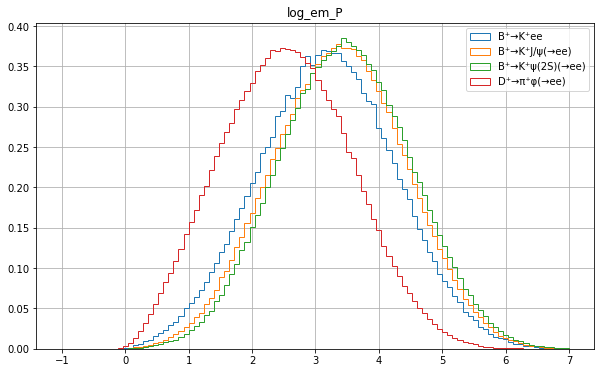

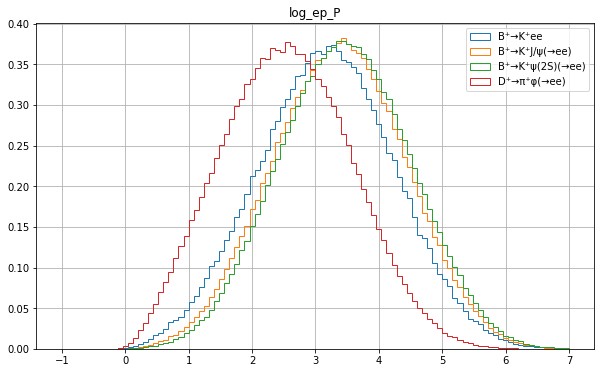

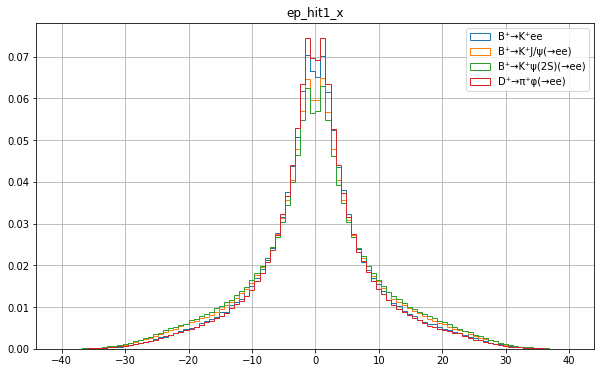

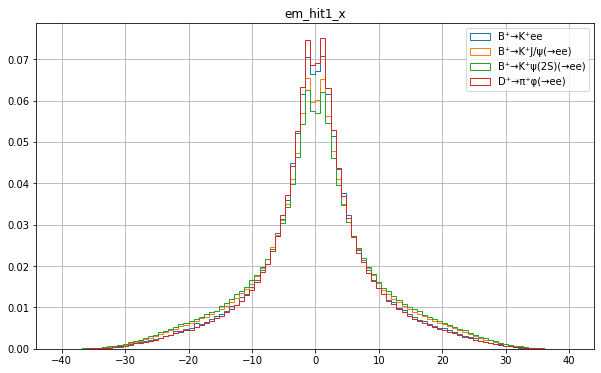

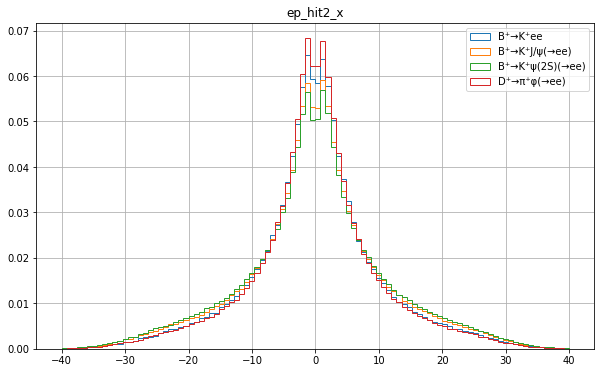

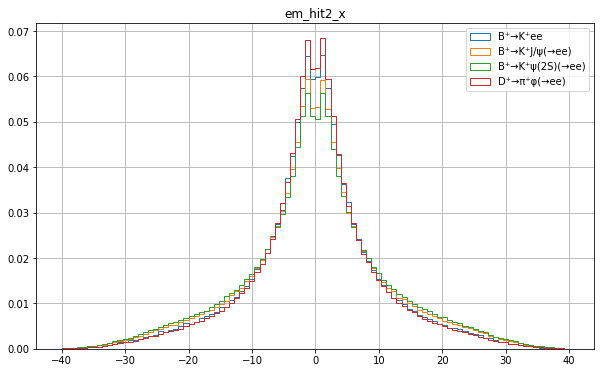

In [43]:
feature_plot("log_em_P", train_ds, aliases, np.linspace(-1, 7, 101))
feature_plot("log_ep_P", train_ds, aliases, np.linspace(-1, 7, 101))
feature_plot("ep_hit1_x", train_ds, aliases, np.linspace(-40, 40, 101))
feature_plot("em_hit1_x", train_ds, aliases, np.linspace(-40, 40, 101))
feature_plot("ep_hit2_x", train_ds, aliases, np.linspace(-40, 40, 101))
feature_plot("em_hit2_x", train_ds, aliases, np.linspace(-40, 40, 101))

### Preprocessing

In [44]:
class Loader(object):
    def __init__(self, dataset, batch_size=1, shuffle=True, drop_last=False, device=None):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.drop_last = drop_last
        self.device = device
    def __len__(self):
        data_len = len(self.dataset)
        if self.drop_last:
            off = 0
        else:
            off = self.batch_size - 1
        return (data_len + off) // self.batch_size
    def __iter__(self):
        data_len = len(self.dataset)
        indices = torch.randperm(data_len, device=self.device) if self.shuffle else None
        for i in range(0, data_len, self.batch_size):
            i_last = i + self.batch_size
            if (i_last > data_len):
                if self.drop_last:
                    break
                else:
                    i_last = data_len
            slc = slice(i, i_last)
            if indices is not None:
                yield self.dataset[indices[slc]]
            else:
                yield self.dataset[slc]

In [45]:
class Dataset(object):
    def __init__(self, features, sources, aliases={}, name=None):
        self.sources = sources
        self.features = features
        self.name = name
        self.counts = np.asarray([len(source) for source in self.sources])
        self.size = np.sum(self.counts)
        self.weights = self.size/self.counts/self.counts.size
        self.aliases = aliases
    def __len__(self):
        return np.sum(self.counts)
    def __repr__(self):
        return "DS%s" % self.name
    def X(self, **kwargs):
        ccounts = np.cumsum(self.counts)
        lower = ccounts - self.counts
        result = torch.empty(ccounts[-1], len(self.features), **kwargs)
        for i in range(ccounts.size):
            np_data = self.sources[i].get(self.features, aliases=self.aliases)
            result[lower[i]:ccounts[i]] = torch.as_tensor(np_data, **kwargs)
        return result        
    def Y(self, **kwargs):
        ccounts = np.cumsum(self.counts)
        result = torch.zeros(ccounts[-1], **kwargs)
        for i in range(1, ccounts.size):
            result[ccounts[i-1]:ccounts[i]] = i
        return result
    def Y_hot(self):
        ccounts = np.cumsum(self.counts)
        result = torch.zeros(ccounts[-1], ccounts.size, **kwargs)
        for i in range(1, ccounts.size):
            result[ccounts[i-1]:ccounts[i], i] = 0
        return result

In [48]:
feature_sets = [
    ("11", ["ep_hit1_x", "em_hit1_x"]),
    ("22", ["ep_hit2_x", "em_hit2_x"]),
    ("pp", ["log_ep_P", "log_em_P"]),
    ("6", ["log_ep_P", "log_em_P", "ep_hit1_x", "em_hit1_x", "ep_hit2_x", "em_hit2_x"]),
]
train_datasets = [
    ("₄", train_ds),
    ("₃", train_ds[:3]),
]

all_datasets = list()
for f in feature_sets:
    for t in train_datasets:
        all_datasets.append(Dataset(f[1], t[1], aliases, "%s[%s]"%(t[0],f[0])))
all_datasets

[DS₄[11], DS₃[11], DS₄[22], DS₃[22], DS₄[pp], DS₃[pp], DS₄[6], DS₃[6]]

In [49]:
class Scaler(torch.nn.Module):
    def __init__(self, dataset):
        super().__init__()
        self.features = dataset.features
        self.scaler = sklearn.preprocessing.StandardScaler()
        self.minmax = sklearn.preprocessing.MinMaxScaler()
        x = to_numpy(dataset.X())
        self.scaler.fit(x)
        self.minmax.fit(x)
        self.mu = torch.as_tensor(self.scaler.mean_, dtype=float, device=device)
        self.sigma = torch.as_tensor(self.scaler.scale_, dtype=float, device=device)
        self.min = self.minmax.data_min_
        self.max = self.minmax.data_max_
    def forward(self, data):
        return ((data-self.mu)/self.sigma).float()
    def transform(self, x):
        return self.scaler.transform(x)
    def inverse_transform(self, x):
        return self.scaler.inverse_transform(x)

In [50]:
def plot_ds(dataset, scaler=None, ax=None, scale=3.0):
    sc = Scaler(dataset) if scaler is None else scaler
    axis = plt.gca() if ax is None else ax
    for source in dataset.sources:
        x = source.get(dataset.features, dataset.aliases)[:10000,0:2]
        axis.scatter(*(x.T), marker=".", s=0.1, label="%s"%source.name())
    upper = np.repeat(scale, 2)[None,:]
    lower = -upper
    x_min, y_min = sc.min # sc.inverse_transform(lower)[0]
    x_max, y_max = sc.max # sc.inverse_transform(upper)[0]
    axis.set_xlabel(dataset.features[0])
    axis.set_ylabel(dataset.features[1])
    axis.set_xlim(x_min, x_max)
    axis.set_ylim(y_min, y_max)
    axis.set_aspect(1.0/axis.get_data_ratio(), adjustable='box')
    axis.set_title("DS%s"%dataset.name)
    
    def update_prop(handle, orig):
        handle.update_from(orig)
        handle.set_sizes([3.0])
        handle.set_linewidth(3.0)
        
    axis.legend(handler_map={
        mpl.collections.PathCollection:mpl.legend_handler.HandlerPathCollection(update_func=update_prop),
    })
    axis.grid()
    if ax is None:
        plt.show()

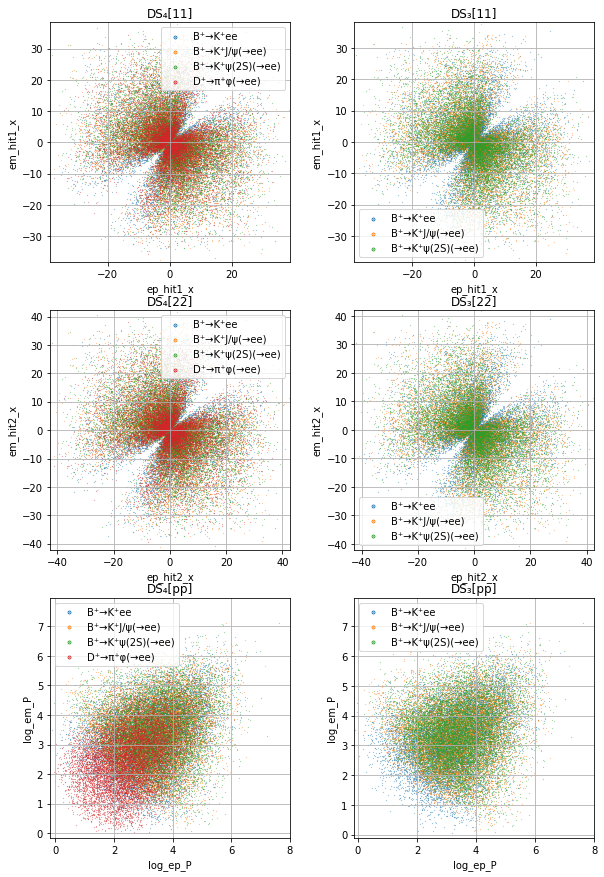

In [51]:
fig, ax = plt.subplots(3, 2, figsize=(10, 15))
for i in range(6):
    plot_ds(all_datasets[i], scale=2.0, ax=ax[i//2,i%2])
plt.show()

### NN

In [52]:
def model(inputs, outputs):
    return nn.Sequential(
        nn.Linear(inputs, 20), nn.Softplus(),
        nn.Linear(20, 20), nn.Softplus(),
        nn.Linear(20, 20), nn.Softplus(),
        nn.Linear(20, outputs),
    )

In [53]:
def train(model, loader, epochs=20, weight=None, accumulate=False):
    total_count = len(loader.dataset)
    model.train()
    model.zero_grad()
    opt = torch.optim.Adam(params=model.parameters())
    opt.zero_grad()
    wt = from_numpy(weight) if weight is not None else None
    for epoch in range(epochs):
        total_loss = 0
        for batch in loader:
            x, y = batch
            pred = model(x)
            loss = F.cross_entropy(
                input=pred,
                target=y,
                weight=wt,
                reduction='sum',
            )
            total_loss += loss
            count = x.shape[0] if not accumulate else total_count
            loss /= count
            loss.backward()
            if not accumulate:
                opt.step()
                opt.zero_grad()
        mean_loss = total_loss / total_count
        if accumulate:
            opt.step()
            opt.zero_grad()
        logging.info("Epoch %d, %f", epoch, mean_loss)
    model.eval()
    model.zero_grad(set_to_none=True)

### Weight limits estimation

In [54]:
def train_estimator(dataset, model, device=device):
    model.to(device)
    ds = torch.utils.data.TensorDataset(
        dataset.X(device=device, dtype=float),
        dataset.Y(device=device, dtype=torch.int64)
    )
    loader = Loader(ds, batch_size=100000, shuffle=True, device=device)
    train(model, loader, epochs=50, weight=dataset.weights, accumulate=False)
    loader = Loader(ds, batch_size=100000, shuffle=False, device=device)
    train(model, loader, epochs=50, weight=dataset.weights, accumulate=True)
    return model.eval()

In [55]:
def make_estimator(dataset, device=device):
    scaler = Scaler(dataset)
    m = model(len(dataset.features), len(dataset.sources))
    return torch.nn.Sequential(scaler, m).to(device)

In [56]:
%%time
all_est = list()
for ds in all_datasets:
    est = make_estimator(ds)
    train_estimator(ds, est)
    all_est.append(est)
all_est

INFO:root:Epoch 0, 1.407733
INFO:root:Epoch 1, 1.386989
INFO:root:Epoch 2, 1.386240
INFO:root:Epoch 3, 1.386129
INFO:root:Epoch 4, 1.386014
INFO:root:Epoch 5, 1.385838
INFO:root:Epoch 6, 1.385560
INFO:root:Epoch 7, 1.385114
INFO:root:Epoch 8, 1.384403
INFO:root:Epoch 9, 1.383316
INFO:root:Epoch 10, 1.381628
INFO:root:Epoch 11, 1.378984
INFO:root:Epoch 12, 1.375444
INFO:root:Epoch 13, 1.372751
INFO:root:Epoch 14, 1.371686
INFO:root:Epoch 15, 1.370985
INFO:root:Epoch 16, 1.370358
INFO:root:Epoch 17, 1.369681
INFO:root:Epoch 18, 1.368950
INFO:root:Epoch 19, 1.368159
INFO:root:Epoch 20, 1.367312
INFO:root:Epoch 21, 1.366446
INFO:root:Epoch 22, 1.365558
INFO:root:Epoch 23, 1.364726
INFO:root:Epoch 24, 1.363988
INFO:root:Epoch 25, 1.363367
INFO:root:Epoch 26, 1.362921
INFO:root:Epoch 27, 1.362596
INFO:root:Epoch 28, 1.362361
INFO:root:Epoch 29, 1.362246
INFO:root:Epoch 30, 1.362103
INFO:root:Epoch 31, 1.362070
INFO:root:Epoch 32, 1.361905
INFO:root:Epoch 33, 1.361804
INFO:root:Epoch 34, 1.36

INFO:root:Epoch 35, 1.359133
INFO:root:Epoch 36, 1.359128
INFO:root:Epoch 37, 1.359122
INFO:root:Epoch 38, 1.359119
INFO:root:Epoch 39, 1.359117
INFO:root:Epoch 40, 1.359112
INFO:root:Epoch 41, 1.359107
INFO:root:Epoch 42, 1.359103
INFO:root:Epoch 43, 1.359100
INFO:root:Epoch 44, 1.359096
INFO:root:Epoch 45, 1.359091
INFO:root:Epoch 46, 1.359087
INFO:root:Epoch 47, 1.359084
INFO:root:Epoch 48, 1.359081
INFO:root:Epoch 49, 1.359076
INFO:root:Epoch 0, 1.109697
INFO:root:Epoch 1, 1.099842
INFO:root:Epoch 2, 1.098503
INFO:root:Epoch 3, 1.098250
INFO:root:Epoch 4, 1.098073
INFO:root:Epoch 5, 1.097888
INFO:root:Epoch 6, 1.097643
INFO:root:Epoch 7, 1.097306
INFO:root:Epoch 8, 1.096804
INFO:root:Epoch 9, 1.096054
INFO:root:Epoch 10, 1.094909
INFO:root:Epoch 11, 1.093136
INFO:root:Epoch 12, 1.090505
INFO:root:Epoch 13, 1.087098
INFO:root:Epoch 14, 1.083990
INFO:root:Epoch 15, 1.082428
INFO:root:Epoch 16, 1.081741
INFO:root:Epoch 17, 1.081268
INFO:root:Epoch 18, 1.080874
INFO:root:Epoch 19, 1.08

INFO:root:Epoch 20, 1.067223
INFO:root:Epoch 21, 1.067167
INFO:root:Epoch 22, 1.067143
INFO:root:Epoch 23, 1.067161
INFO:root:Epoch 24, 1.067187
INFO:root:Epoch 25, 1.067188
INFO:root:Epoch 26, 1.067167
INFO:root:Epoch 27, 1.067150
INFO:root:Epoch 28, 1.067150
INFO:root:Epoch 29, 1.067155
INFO:root:Epoch 30, 1.067150
INFO:root:Epoch 31, 1.067140
INFO:root:Epoch 32, 1.067137
INFO:root:Epoch 33, 1.067142
INFO:root:Epoch 34, 1.067146
INFO:root:Epoch 35, 1.067137
INFO:root:Epoch 36, 1.067125
INFO:root:Epoch 37, 1.067121
INFO:root:Epoch 38, 1.067126
INFO:root:Epoch 39, 1.067131
INFO:root:Epoch 40, 1.067127
INFO:root:Epoch 41, 1.067118
INFO:root:Epoch 42, 1.067113
INFO:root:Epoch 43, 1.067115
INFO:root:Epoch 44, 1.067116
INFO:root:Epoch 45, 1.067113
INFO:root:Epoch 46, 1.067109
INFO:root:Epoch 47, 1.067108
INFO:root:Epoch 48, 1.067107
INFO:root:Epoch 49, 1.067105
INFO:root:Epoch 0, 1.509538
INFO:root:Epoch 1, 1.392755
INFO:root:Epoch 2, 1.381409
INFO:root:Epoch 3, 1.373605
INFO:root:Epoch 4,

CPU times: user 4min 1s, sys: 15.7 s, total: 4min 17s
Wall time: 4min 15s


[Sequential(
   (0): Scaler()
   (1): Sequential(
     (0): Linear(in_features=2, out_features=20, bias=True)
     (1): Softplus(beta=1, threshold=20)
     (2): Linear(in_features=20, out_features=20, bias=True)
     (3): Softplus(beta=1, threshold=20)
     (4): Linear(in_features=20, out_features=20, bias=True)
     (5): Softplus(beta=1, threshold=20)
     (6): Linear(in_features=20, out_features=4, bias=True)
   )
 ),
 Sequential(
   (0): Scaler()
   (1): Sequential(
     (0): Linear(in_features=2, out_features=20, bias=True)
     (1): Softplus(beta=1, threshold=20)
     (2): Linear(in_features=20, out_features=20, bias=True)
     (3): Softplus(beta=1, threshold=20)
     (4): Linear(in_features=20, out_features=20, bias=True)
     (5): Softplus(beta=1, threshold=20)
     (6): Linear(in_features=20, out_features=3, bias=True)
   )
 ),
 Sequential(
   (0): Scaler()
   (1): Sequential(
     (0): Linear(in_features=2, out_features=20, bias=True)
     (1): Softplus(beta=1, threshold=20)
 

In [57]:
def plot_field(f, sc, scale=3.0, name=None, vmin=0.0, vmax=1.0, ax=None, color_bar=True):
    axis = plt.gca() if ax is None else ax
    
    x_min, y_min = sc.min
    x_max, y_max = sc.max
    
    x1, y1 = sc.transform([[x_min, y_min]])[0]
    x2, y2 = sc.transform([[x_max, y_max]])[0]
    
    X_test = sc.inverse_transform(
        np.asarray(bridson.poisson_disc_samples(x2-x1, y2-y1, 0.02)) +
        np.asarray([x1, y1])
    )
    
    y_pred = f(X_test).ravel()
    xi = np.linspace(x_min, x_max, 301)
    yi = np.linspace(y_min, y_max, 301)
    zi = scipy.interpolate.griddata(X_test, y_pred, tuple(np.meshgrid(xi, yi)), method='linear')
    CS = axis.contourf(xi, yi, zi, 20, cmap=plt.cm.seismic,
                      vmax=vmax, vmin=vmin)
    if color_bar:
        plt.colorbar(ax=axis, mappable=CS)
    axis.set_xlim(x_min, x_max)
    axis.set_ylim(y_min, y_max)
    axis.set_xlabel(sc.features[0])
    axis.set_ylabel(sc.features[1])
    axis.grid()
    axis.set_aspect(1.0/axis.get_data_ratio(), adjustable='box')
    if name is not None:
        axis.set_title(name)
    if ax is None:
        plt.show()

In [58]:
def plot_one(f, sc, name=None, save=None, vmin=0.0, vmax=1.0, ax=None):
    axis = plt.gca() if ax is None else ax
    x_min, x_max = sc.min, sc.max
    X_test = np.linspace(x_min, x_max, 1001)
    y_pred = f(X_test).ravel()
    axis.plot(X_test, y_pred)
    axis.set_xlim(x_min, x_max)
    axis.set_ylim(vmin, vmax)
    axis.set_xlabel(sc.features[0])
    axis.grid()    
    if name is not None:
        axis.set_title(name)
    if ax is None:
        plt.show()

In [59]:
def plot_clf(clf, scaler, c0, c1, ax=None, scale=3.0, color_bar=True):
    fn = lambda x : x[:,c1] - x[:,c0]
    f_ = lambda x : torch.sigmoid(fn(clf(x)))
    f = ds.as_numpy(f_)
    name=r'$\sigma\left(\log\frac{p(x|%s)}{p(x|%s)}\right)$'%(df_index[ds.mapping[c1]],df_index[ds.mapping[c0]])
    plot_field(f, scaler, scale=scale, ax=ax, name=name, color_bar=color_bar)

In [60]:
def plot_clf_min_max(clf, ax_min=None, ax_max=None, scale=3.0):
    fn = lambda x : x[...,1:] - x[...,0:1]
    f_min = lambda x : torch.relu(torch.min(fn(clf(x)), dim=-1)[0])
    f_max = lambda x : torch.relu(torch.min(-fn(clf(x)), dim=-1)[0])
    name_min = r'$\min_i\left(\log\frac{p(x|c_i)}{p(x|c)}\right)_+$'
    name_max = r'$\min_i\left(\log\frac{p(x|c)}{p(x|c_i)}\right)_+$'
    plot_field(as_numpy(f_min), clf[0], scale=scale, name=name_min, vmax=None, ax=ax_min, color_bar=False)
    plot_field(as_numpy(f_max), clf[0], scale=scale, name=name_max, vmax=None, ax=ax_max, color_bar=False)

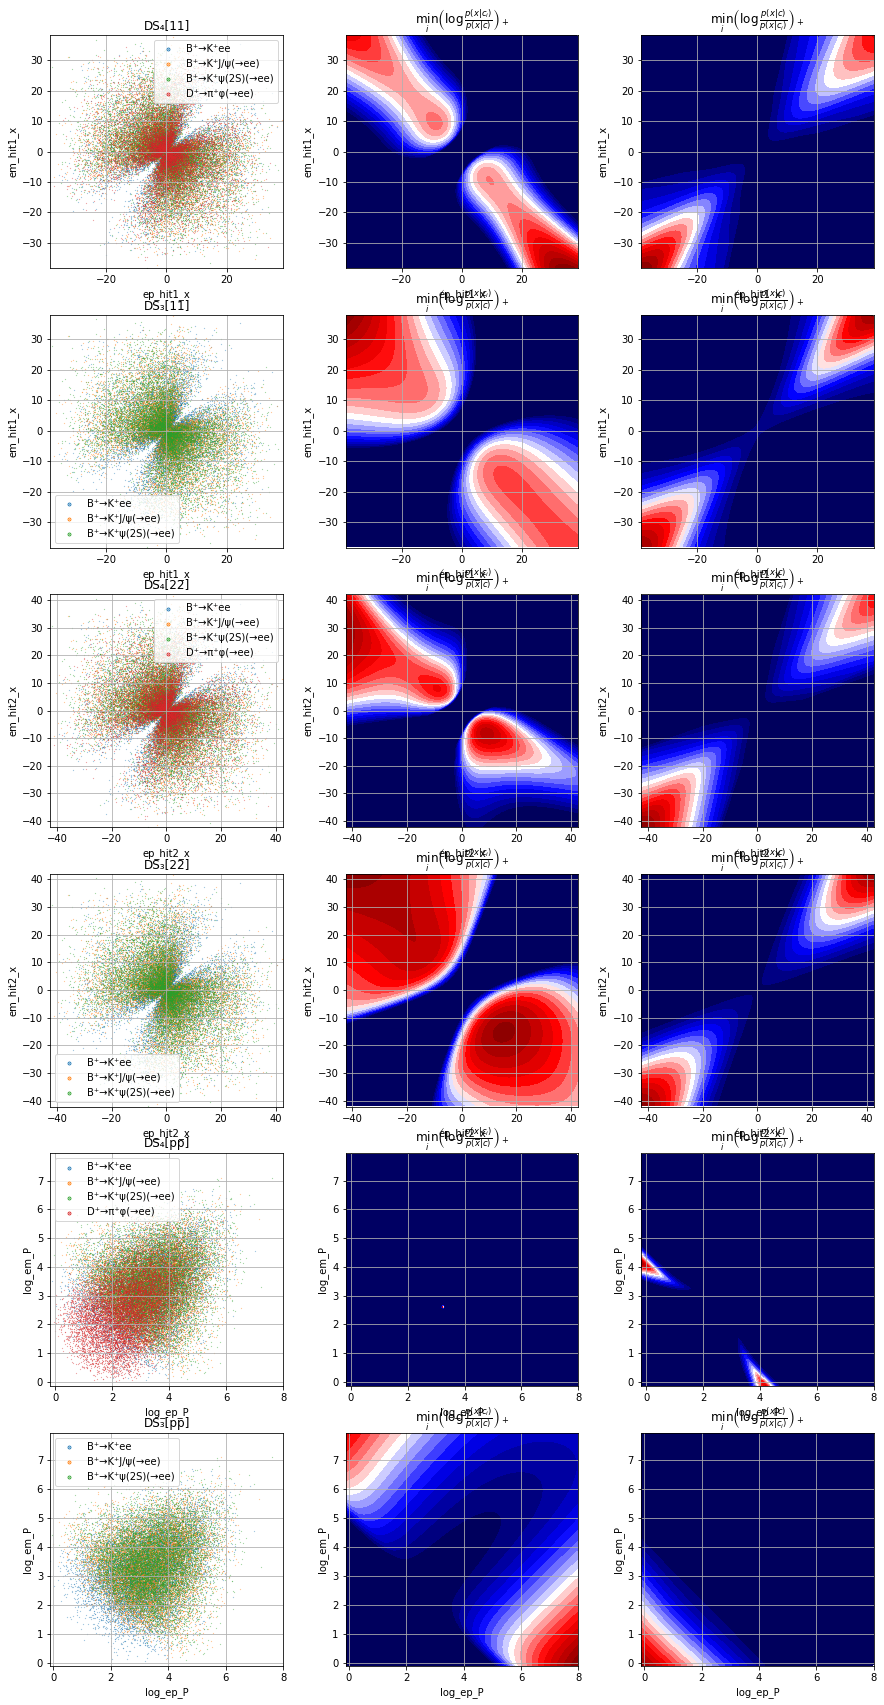

In [61]:
fig, ax = plt.subplots(6, 3, figsize=(15, 30))
for i in range(6):
    est = all_est[i]
    ds = all_datasets[i]
    plot_ds(ds, scaler=est[0], ax=ax[i,0])
    plot_clf_min_max(est, ax_min=ax[i,1], ax_max=ax[i,2])
plt.show()

### Weighting function

In [62]:
def compute_lipschitz(model, loader, device=device):
    model.eval().to(device)
    sc = model[0]
    fn = model[1:]
    L = 0
    for batch in loader:
        x, y = batch
        x.to(device)
        model.zero_grad()
        x_ = sc(x)
        x_.requires_grad = True
        fx = fn(x_)
        loss = torch.sum(fx)
        loss.backward()
        L = max(L, torch.max(x_.grad.norm(dim=1)).item())
    return L

In [63]:
def ratio_estimator(vec):
    m_minus = np.max(-vec)
    m_plus = np.max(vec)
    m_sum = m_minus + m_plus
    return 1/m_minus

In [64]:
def create_w(model, loader, n_outs, n_classes):
    totals = torch.zeros(n_classes, dtype=torch.long, device=device)
    wsum = torch.zeros(n_outs, n_classes, dtype=torch.float, device=device)
    for batch in loader:
        x, y = batch
        y_one_hot = torch.nn.functional.one_hot(y, num_classes=n_classes) # B*n
        pred = model(x) # B*N
        totals += torch.sum(y_one_hot, dim=0) # n
        wsum += torch.sum(pred.view(-1,n_outs,1)*y_one_hot.view(-1,1,n_classes), dim=0) # N*n
    W = wsum/totals.view(1,-1)
    return W, totals.view(1,-1)

In [65]:
def make_weighting_lp(Wpinv):
    import scipy.optimize
    n_classes, n_outs = Wpinv.shape
    c = np.asarray([-1]+[0]*(n_classes-1))
    bounds = [(0,1),(0.02,0.02), (0.01,0.03), (0,0.07)][:n_classes]
    A_ub = np.vstack([Wpinv.T, -Wpinv.T])
    b_ub = np.hstack([np.ones(n_outs), np.zeros(n_outs)])
    res = scipy.optimize.linprog(c=c, bounds=bounds, A_ub=A_ub, b_ub=b_ub)
    return np.maximum(Wpinv.T@res.x,0) if res.success else None

In [66]:
@torch.no_grad()
def make_weighting(Wpinv, linear, selected_class, n_outs, n_classes):
    assert Wpinv.shape == (n_classes, n_outs)
    weights = make_weighting_lp(Wpinv)
    if weights is None:
        w0 = Wpinv[selected_class]
        m_minus = np.max(-w0)
        m_plus = np.max(w0)
        m_sum = m_minus + m_plus
        k = np.maximum(m_minus*50, m_plus*50/49)
        weights = (w0 + k/50)/k
        #weights = (w0 + m_minus)/m_sum
    linear.weight.data = from_numpy(weights).view(linear.weight.data.shape)

In [67]:
def train_pinv(model, loader, n_outs, n_classes, selected_class, epochs=50, alpha=0.001, dxl=0.001, target_L=None):
    clone = clone_model(model)
    scaler = model[0]
    meat = model[1:3] # with softmax
    base = model[:3]
    linear = model[3]
    opt = torch.optim.SGD(params=meat.parameters(), lr=1e-4)    
    dx_ = torch.tensor([[[-1]],[[1]]], dtype=torch.float, device=device) * dxl
    try:
        for epoch in range(epochs):
            model.eval()
            with torch.no_grad():
                W, counts = create_w(base, loader, n_outs, n_classes)
            W_np = to_numpy(W)
            W_pinv = np.linalg.pinv(W_np)
            det = np.linalg.det(W_np.T@W_np)
            W_pinv_ = from_numpy(W_pinv)
            W_pinv_T = W_pinv_.T

            # fill linear coeffs
            make_weighting(W_pinv, linear, selected_class, n_outs, n_classes)

            wcj = W_pinv[selected_class]                   # N
            wcj_ = (wcj<0)*0.98 - (wcj>1)*0.02
            #ix_min = np.argmin(wcj)
            #ix_max = np.argmax(wcj)
            #wcj_ = np.zeros(n_outs)
            #if m_minus * 49 > m_plus:
            #    wcj_[ix_min] = 1
            #else:
            #    wcj_[ix_max] = -1
            #wcj_[ix_min] = 0.98
            #wcj_[ix_max] = -0.02
            #wcj_ = np.log(1-np.minimum(wcj,0))-np.log(1+np.maximum(wcj-1,0))
            wki = np.sum(W_pinv*wcj_[None,:], axis=1)      # n
            W_m = np.multiply.outer(wcj, wki)              # N*n ~ W
            W_m_ = W_m/np.maximum(1,np.max(np.abs(W_m)))
            W_m_t = from_numpy(W_m_)

            for clone_par, model_par in zip(clone.parameters(), model.parameters()): 
                clone_par.data.copy_(model_par.data)
            #clone.load_state_dict(model.state_dict())

            model.train()
            opt.zero_grad()
            total_loss = 0    
            L = 0
            for batch in loader:
                x, y = batch

                y_one_hot = torch.nn.functional.one_hot(y, num_classes=n_classes) # B*n
                pred = base(x)

                wsum = torch.sum(pred.view(-1,n_outs,1)*y_one_hot.view(-1,1,n_classes), dim=0) # N*n
                W = wsum/counts

                loss_c = torch.sum(W*W_m_t)
                loss_d = -torch.sum(W*W_pinv_T)
                loss = loss_d + alpha * loss_c
                total_loss += loss
                loss.backward()

                # Lipschitz part of the loss

                if True:
                    clone.zero_grad()
                    x_ = clone[0](x)
                    x_.requires_grad = True
                    fx = clone[1:](x_)
                    L_loss = torch.sum(fx)
                    L_loss.backward()
                    dx = x_.grad
                    L = max(L, torch.max(dx.norm(dim=1)).item())

                    if target_L is not None:
                        ext_dx = dx[None,...] * dx_ # 2*B*n_features
                        ext_x = x_[None,...] + ext_dx

                        pred_dfx = meat(ext_x) # 2*B*N
                        dfx = (pred_dfx[1] - pred_dfx[0])/(2*dxl)/target_L
                        loss_L = torch.sum(F.relu(torch.abs(dfx)-1)**2) / len(loader.dataset)

                        total_loss += loss_L
                        loss_L.backward()

            opt.step()
            #logging.info("Epoch %d, loss=%f est=%f", epoch, total_loss, ratio_estimator(W_pinv[selected_class]))
            print("Epoch %d loss=%f W+c=%s det=%f L=%f" % (epoch, total_loss, W_pinv[selected_class], det, L))
    except KeyboardInterrupt:
        pass
    model.eval()
    model.zero_grad(set_to_none=True)
    
    with torch.no_grad():
        W, counts = create_w(base, loader, n_outs, n_classes)
        W_np = to_numpy(W)
        W_pinv = np.linalg.pinv(W_np)
        make_weighting(W_pinv, linear, selected_class, n_outs, n_classes)
    L = compute_lipschitz(model, loader)
    print("W=", W_np)
    print("W+=", W_pinv)
    print("L=", L)
    print("coef=", linear.weight.data.detach().cpu().numpy())

    return model

In [68]:
def train_weighting(model, dataset, n_outs, n_classes, selected_class, device=device, **kwargs):
    model.to(device)
    data = torch.utils.data.TensorDataset(
        dataset.X(device=device, dtype=torch.float),
        dataset.Y(device=device, dtype=torch.int64)
    )
    loader = Loader(data, batch_size=100000, shuffle=False, device=device)
    train_pinv(model, loader, n_outs, n_classes, selected_class, epochs=200, alpha=0.001)
    train_pinv(model, loader, n_outs, n_classes, selected_class, epochs=500, alpha=300, **kwargs)
    return model.eval()

In [69]:
class Weighting(torch.nn.Module):
    def __init__(self, scaler, model, n_outs=None, name=None, device=device):
        super().__init__()
        
        scaler_ = clone_model(scaler)
        model_ = clone_model(model)
        
        n_inputs = len(scaler_.features)
        if n_outs is None:
            with torch.no_grad():
                z = torch.zeros(1, n_inputs, dtype=torch.float, device=device)
                n_outs = model_.to(device)(z).shape[1]
        
        self.features = scaler_.features
        self.n_inputs = n_inputs
        self.n_outs = n_outs
        self.name = name
        
        self.model = torch.nn.Sequential(
            scaler_,
            model_,
            torch.nn.Softmax(dim=-1),
            torch.nn.Linear(n_outs, 1, bias=False),
        ).to(device).eval()

    def forward(self, x):
        return self.model(x)
        
    def train(self, dataset, n_classes=None, selected_class=0, **kwargs):
        if n_classes is None:
            n_classes = len(dataset.sources)
        return train_weighting(self.model, dataset, self.n_outs, n_classes, selected_class, **kwargs)

In [70]:
def w_from_est(estimator, name=None):
    return Weighting(estimator[0], estimator[1:], name=name)

In [71]:
%%time
results = dict()
for target_L in [None]:
    for est, ds in zip(all_est, all_datasets):
        name = "w%s@%s"%(ds.name, target_L)
        w = w_from_est(est, name=name)
        w.train(ds, target_L=target_L)
        results[target_L, ds.name] = w

Epoch 0 loss=-3.999563 W+c=[ 137.8675 -344.3615  295.2927  -87.7763] det=0.000000 L=0.045710
Epoch 1 loss=-4.000326 W+c=[ 134.5332 -299.1253  254.6248  -92.1755] det=0.000000 L=0.045690
Epoch 2 loss=-4.000296 W+c=[ 132.1735 -268.727   227.2964  -95.0371] det=0.000000 L=0.045661
Epoch 3 loss=-3.999915 W+c=[ 130.3544 -246.402   207.2301  -97.0727] det=0.000000 L=0.045629
Epoch 4 loss=-3.999863 W+c=[ 128.8678 -229.0719  191.6557  -98.5924] det=0.000000 L=0.045621
Epoch 5 loss=-3.999952 W+c=[ 127.6132 -215.1319  179.125   -99.7655] det=0.000000 L=0.045605
Epoch 6 loss=-3.999959 W+c=[ 126.5154 -203.583   168.7403 -100.6843] det=0.000000 L=0.045598
Epoch 7 loss=-3.999797 W+c=[ 125.5411 -193.811   159.9528 -101.4233] det=0.000000 L=0.045580
Epoch 8 loss=-3.999856 W+c=[ 124.6625 -185.3788  152.3754 -102.032 ] det=-0.000000 L=0.045576
Epoch 9 loss=-4.000040 W+c=[ 123.8576 -178.0647  145.7894 -102.5145] det=0.000000 L=0.045576
Epoch 10 loss=-4.000093 W+c=[ 123.1137 -171.6095  139.9761 -102.911 ]

Epoch 89 loss=-4.000005 W+c=[ 98.1099 -72.3958  51.4376 -96.8363] det=0.000000 L=0.046228
Epoch 90 loss=-4.000042 W+c=[ 97.9052 -72.0727  51.1636 -96.7042] det=0.000000 L=0.046241
Epoch 91 loss=-3.999968 W+c=[ 97.703  -71.7377  50.8878 -96.5813] det=0.000000 L=0.046251
Epoch 92 loss=-4.000042 W+c=[ 97.499  -71.4372  50.6275 -96.4419] det=0.000000 L=0.046264
Epoch 93 loss=-3.999982 W+c=[ 97.2983 -71.1067  50.3584 -96.3206] det=0.000000 L=0.046274
Epoch 94 loss=-4.000002 W+c=[ 97.0986 -70.8062  50.1037 -96.1885] det=0.000000 L=0.046285
Epoch 95 loss=-4.000007 W+c=[ 96.9003 -70.4977  49.8482 -96.0624] det=0.000000 L=0.046296
Epoch 96 loss=-4.000068 W+c=[ 96.7021 -70.2087  49.6026 -95.9286] det=0.000000 L=0.046307
Epoch 97 loss=-4.000038 W+c=[ 96.5058 -69.901   49.3519 -95.806 ] det=0.000000 L=0.046318
Epoch 98 loss=-4.000077 W+c=[ 96.3101 -69.6149  49.112  -95.6756] det=0.000000 L=0.046330
Epoch 99 loss=-3.999960 W+c=[ 96.116  -69.3187  48.8704 -95.5522] det=0.000000 L=0.046340
Epoch 100 

Epoch 180 loss=-3.999995 W+c=[ 83.1694 -53.755   36.9357 -86.4707] det=0.000000 L=0.047236
Epoch 181 loss=-4.000010 W+c=[ 83.0363 -53.623   36.8438 -86.3711] det=0.000000 L=0.047248
Epoch 182 loss=-4.000043 W+c=[ 82.9045 -53.4863  36.7508 -86.2752] det=0.000000 L=0.047260
Epoch 183 loss=-4.000045 W+c=[ 82.7736 -53.3489  36.6583 -86.1808] det=0.000000 L=0.047270
Epoch 184 loss=-4.000023 W+c=[ 82.6421 -53.2153  36.5672 -86.0837] det=0.000000 L=0.047280
Epoch 185 loss=-4.000001 W+c=[ 82.5118 -53.0813  36.4768 -85.9887] det=0.000000 L=0.047289
Epoch 186 loss=-3.999958 W+c=[ 82.3818 -52.9572  36.3901 -85.8895] det=0.000000 L=0.047299
Epoch 187 loss=-3.999884 W+c=[ 82.2528 -52.8259  36.3017 -85.795 ] det=0.000000 L=0.047311
Epoch 188 loss=-4.000027 W+c=[ 82.1238 -52.6948  36.2135 -85.7001] det=0.000000 L=0.047322
Epoch 189 loss=-3.999984 W+c=[ 81.9954 -52.5625  36.1254 -85.6065] det=0.000000 L=0.047333
Epoch 190 loss=-3.999954 W+c=[ 81.8678 -52.4309  36.0381 -85.5137] det=0.000000 L=0.047343

Epoch 67 loss=-4.661118 W+c=[ 72.0748 -41.053   30.3704 -77.2309] det=0.000000 L=0.049669
Epoch 68 loss=-4.662089 W+c=[ 71.9649 -40.9284  30.3169 -77.1278] det=0.000000 L=0.049704
Epoch 69 loss=-4.662922 W+c=[ 71.856  -40.7925  30.2599 -77.031 ] det=0.000000 L=0.049740
Epoch 70 loss=-4.663825 W+c=[ 71.7477 -40.6658  30.2063 -76.9306] det=0.000000 L=0.049775
Epoch 71 loss=-4.664712 W+c=[ 71.639  -40.5339  30.1509 -76.832 ] det=0.000000 L=0.049812
Epoch 72 loss=-4.665486 W+c=[ 71.5313 -40.3988  30.0947 -76.7358] det=0.000000 L=0.049846
Epoch 73 loss=-4.666404 W+c=[ 71.4238 -40.272   30.0414 -76.6361] det=0.000000 L=0.049883
Epoch 74 loss=-4.667287 W+c=[ 71.317  -40.1455  29.9885 -76.5372] det=0.000000 L=0.049920
Epoch 75 loss=-4.668152 W+c=[ 71.2105 -40.0172  29.9352 -76.4393] det=0.000000 L=0.049955
Epoch 76 loss=-4.669002 W+c=[ 71.1047 -39.8895  29.8823 -76.3419] det=0.000000 L=0.049991
Epoch 77 loss=-4.669848 W+c=[ 70.9988 -39.7637  29.8301 -76.2432] det=0.000000 L=0.050027
Epoch 78 l

Epoch 158 loss=-4.734143 W+c=[ 63.7191 -30.6925  26.3992 -69.0218] det=0.000000 L=0.053180
Epoch 159 loss=-4.734920 W+c=[ 63.6429 -30.5987  26.3664 -68.9373] det=0.000000 L=0.053222
Epoch 160 loss=-4.735686 W+c=[ 63.5672 -30.4996  26.332  -68.8559] det=0.000000 L=0.053264
Epoch 161 loss=-4.736329 W+c=[ 63.4913 -30.398   26.2966 -68.7752] det=0.000000 L=0.053306
Epoch 162 loss=-4.737128 W+c=[ 63.4159 -30.3048  26.2641 -68.6912] det=0.000000 L=0.053348
Epoch 163 loss=-4.737811 W+c=[ 63.3408 -30.2034  26.2289 -68.6112] det=0.000000 L=0.053390
Epoch 164 loss=-4.738531 W+c=[ 63.2663 -30.105   26.1949 -68.5306] det=0.000000 L=0.053432
Epoch 165 loss=-4.739277 W+c=[ 63.1919 -30.0129  26.1631 -68.4471] det=0.000000 L=0.053474
Epoch 166 loss=-4.740012 W+c=[ 63.1178 -29.9127  26.1285 -68.3676] det=0.000000 L=0.053517
Epoch 167 loss=-4.740752 W+c=[ 63.0437 -29.8184  26.0959 -68.2853] det=0.000000 L=0.053560
Epoch 168 loss=-4.741447 W+c=[ 62.97   -29.7226  26.0628 -68.204 ] det=0.000000 L=0.053601

Epoch 249 loss=-4.795287 W+c=[ 57.8273 -22.7371  23.7475 -62.0541] det=0.000000 L=0.057356
Epoch 250 loss=-4.795867 W+c=[ 57.7728 -22.6578  23.7219 -61.9836] det=0.000000 L=0.057405
Epoch 251 loss=-4.796473 W+c=[ 57.7182 -22.5795  23.6966 -61.9125] det=0.000000 L=0.057457
Epoch 252 loss=-4.797058 W+c=[ 57.6641 -22.5017  23.6715 -61.8417] det=0.000000 L=0.057508
Epoch 253 loss=-4.797703 W+c=[ 57.6101 -22.4287  23.6482 -61.7688] det=0.000000 L=0.057557
Epoch 254 loss=-4.798315 W+c=[ 57.5563 -22.3524  23.6236 -61.6977] det=0.000000 L=0.057608
Epoch 255 loss=-4.798913 W+c=[ 57.5028 -22.2753  23.5989 -61.6272] det=0.000000 L=0.057660
Epoch 256 loss=-4.799516 W+c=[ 57.4493 -22.1999  23.5746 -61.5559] det=0.000000 L=0.057711
Epoch 257 loss=-4.800075 W+c=[ 57.3961 -22.1218  23.5495 -61.486 ] det=0.000000 L=0.057761
Epoch 258 loss=-4.800713 W+c=[ 57.3427 -22.048   23.5257 -61.4141] det=0.000000 L=0.057813
Epoch 259 loss=-4.801334 W+c=[ 57.2903 -21.9745  23.5023 -61.3431] det=0.000000 L=0.057863

Epoch 340 loss=-4.845010 W+c=[ 53.5501 -16.472   21.7426 -55.8992] det=0.000000 L=0.062371
Epoch 341 loss=-4.845522 W+c=[ 53.5095 -16.4135  21.7238 -55.8337] det=0.000000 L=0.062431
Epoch 342 loss=-4.845963 W+c=[ 53.4694 -16.3506  21.7035 -55.7707] det=0.000000 L=0.062492
Epoch 343 loss=-4.846430 W+c=[ 53.4294 -16.2902  21.6841 -55.7067] det=0.000000 L=0.062552
Epoch 344 loss=-4.846954 W+c=[ 53.3893 -16.2302  21.6648 -55.6426] det=0.000000 L=0.062614
Epoch 345 loss=-4.847413 W+c=[ 53.35   -16.1695  21.6454 -55.5795] det=0.000000 L=0.062674
Epoch 346 loss=-4.847836 W+c=[ 53.3104 -16.1071  21.6253 -55.5169] det=0.000000 L=0.062735
Epoch 347 loss=-4.848309 W+c=[ 53.2707 -16.0467  21.6058 -55.4532] det=0.000000 L=0.062797
Epoch 348 loss=-4.848783 W+c=[ 53.2311 -15.9876  21.5867 -55.3892] det=0.000000 L=0.062858
Epoch 349 loss=-4.849258 W+c=[ 53.1921 -15.9274  21.5674 -55.3263] det=0.000000 L=0.062920
Epoch 350 loss=-4.849691 W+c=[ 53.153  -15.8658  21.5475 -55.2639] det=0.000000 L=0.062981

Epoch 431 loss=-4.881761 W+c=[ 50.3416 -11.4712  20.1083 -50.3902] det=0.000000 L=0.068424
Epoch 432 loss=-4.882145 W+c=[ 50.3106 -11.4234  20.0924 -50.3323] det=0.000000 L=0.068503
Epoch 433 loss=-4.882367 W+c=[ 50.2801 -11.3743  20.076  -50.2755] det=0.000000 L=0.068579
Epoch 434 loss=-4.882219 W+c=[ 50.2494 -11.324   20.0591 -50.219 ] det=0.000000 L=0.068659
Epoch 435 loss=-4.882087 W+c=[ 50.2188 -11.2772  20.0435 -50.1613] det=0.000000 L=0.068736
Epoch 436 loss=-4.881896 W+c=[ 50.1882 -11.2255  20.0259 -50.1056] det=0.000000 L=0.068815
Epoch 437 loss=-4.881814 W+c=[ 50.1579 -11.1796  20.0107 -50.0478] det=0.000000 L=0.068893
Epoch 438 loss=-4.881646 W+c=[ 50.1275 -11.1304  19.9941 -49.9915] det=0.000000 L=0.068971
Epoch 439 loss=-4.881477 W+c=[ 50.0972 -11.082   19.9777 -49.935 ] det=0.000000 L=0.069049
Epoch 440 loss=-4.881350 W+c=[ 50.0671 -11.0346  19.9619 -49.8783] det=0.000000 L=0.069128
Epoch 441 loss=-4.881171 W+c=[ 50.0371 -10.9856  19.9453 -49.8225] det=0.000000 L=0.069206

Epoch 19 loss=-3.000083 W+c=[  64.429  -236.4294  132.7762] det=0.000000 L=0.047747
Epoch 20 loss=-2.999933 W+c=[  63.979  -233.2562  129.4464] det=0.000000 L=0.047793
Epoch 21 loss=-2.999951 W+c=[  63.5604 -230.3006  126.3359] det=0.000000 L=0.047846
Epoch 22 loss=-2.999949 W+c=[  63.1647 -227.5184  123.4099] det=0.000000 L=0.047896
Epoch 23 loss=-2.999939 W+c=[  62.7917 -224.9012  120.6555] det=0.000000 L=0.047944
Epoch 24 loss=-3.000044 W+c=[  62.438  -222.4268  118.0529] det=0.000000 L=0.047999
Epoch 25 loss=-3.000009 W+c=[  62.0997 -220.0746  115.5848] det=0.000000 L=0.048050
Epoch 26 loss=-3.000019 W+c=[  61.7784 -217.8467  113.2469] det=0.000000 L=0.048103
Epoch 27 loss=-2.999928 W+c=[  61.4713 -215.7266  111.025 ] det=0.000000 L=0.048153
Epoch 28 loss=-3.000036 W+c=[  61.1837 -213.7324  108.9246] det=0.000000 L=0.048206
Epoch 29 loss=-2.999963 W+c=[  60.9022 -211.8056  106.9098] det=0.000000 L=0.048258
Epoch 30 loss=-2.999979 W+c=[  60.6371 -209.9846  104.9978] det=0.000000 L=0

Epoch 117 loss=-2.999984 W+c=[  51.5727 -153.9613   49.0262] det=0.000000 L=0.052650
Epoch 118 loss=-2.999964 W+c=[  51.5201 -153.6892   48.7971] det=0.000000 L=0.052694
Epoch 119 loss=-2.999994 W+c=[  51.4701 -153.4282   48.5742] det=0.000000 L=0.052738
Epoch 120 loss=-2.999975 W+c=[  51.4182 -153.1611   48.3513] det=0.000000 L=0.052782
Epoch 121 loss=-3.000015 W+c=[  51.3682 -152.9024   48.1336] det=0.000000 L=0.052827
Epoch 122 loss=-2.999991 W+c=[  51.3184 -152.6457   47.9189] det=0.000000 L=0.052869
Epoch 123 loss=-2.999975 W+c=[  51.2672 -152.3849   47.7047] det=0.000000 L=0.052914
Epoch 124 loss=-3.000009 W+c=[  51.2178 -152.132    47.4954] det=0.000000 L=0.052958
Epoch 125 loss=-3.000005 W+c=[  51.1685 -151.8804   47.2886] det=0.000000 L=0.053001
Epoch 126 loss=-3.000008 W+c=[  51.12   -151.6331   47.0852] det=0.000000 L=0.053044
Epoch 127 loss=-3.000007 W+c=[  51.0711 -151.3853   46.8837] det=0.000000 L=0.053088
Epoch 128 loss=-3.000035 W+c=[  51.0236 -151.1436   46.6862] det=

Epoch 11 loss=-3.424202 W+c=[  47.9154 -134.479    36.0591] det=0.000000 L=0.056629
Epoch 12 loss=-3.424991 W+c=[  47.8972 -134.2227   35.969 ] det=0.000000 L=0.056694
Epoch 13 loss=-3.425846 W+c=[  47.8811 -133.9743   35.8819] det=0.000000 L=0.056759
Epoch 14 loss=-3.426652 W+c=[  47.8629 -133.7197   35.7936] det=0.000000 L=0.056825
Epoch 15 loss=-3.427432 W+c=[  47.8445 -133.4646   35.7057] det=0.000000 L=0.056891
Epoch 16 loss=-3.428284 W+c=[  47.8284 -133.2183   35.621 ] det=0.000000 L=0.056956
Epoch 17 loss=-3.429114 W+c=[  47.8112 -132.9687   35.536 ] det=0.000000 L=0.057022
Epoch 18 loss=-3.429966 W+c=[  47.7953 -132.724    35.453 ] det=0.000000 L=0.057087
Epoch 19 loss=-3.430763 W+c=[  47.7779 -132.4752   35.3693] det=0.000000 L=0.057151
Epoch 20 loss=-3.431602 W+c=[  47.7602 -132.2258   35.286 ] det=0.000000 L=0.057218
Epoch 21 loss=-3.432430 W+c=[  47.744  -131.9819   35.2049] det=0.000000 L=0.057282
Epoch 22 loss=-3.433244 W+c=[  47.7263 -131.7336   35.123 ] det=0.000000 L=0

Epoch 109 loss=-3.509500 W+c=[  46.3586 -112.4321   30.1138] det=0.000000 L=0.062798
Epoch 110 loss=-3.510462 W+c=[  46.3449 -112.2319   30.0737] det=0.000000 L=0.062859
Epoch 111 loss=-3.511431 W+c=[  46.3302 -112.0294   30.033 ] det=0.000000 L=0.062922
Epoch 112 loss=-3.512334 W+c=[  46.3148 -111.8247   29.9919] det=0.000000 L=0.062982
Epoch 113 loss=-3.513281 W+c=[  46.3    -111.6225   29.9516] det=0.000000 L=0.063043
Epoch 114 loss=-3.514208 W+c=[  46.285  -111.4199   29.9114] det=0.000000 L=0.063104
Epoch 115 loss=-3.515159 W+c=[  46.2703 -111.2184   29.8716] det=0.000000 L=0.063165
Epoch 116 loss=-3.516109 W+c=[  46.2557 -111.0175   29.8322] det=0.000000 L=0.063226
Epoch 117 loss=-3.517075 W+c=[  46.2413 -110.8175   29.7932] det=0.000000 L=0.063288
Epoch 118 loss=-3.518053 W+c=[  46.2264 -110.6163   29.754 ] det=0.000000 L=0.063350
Epoch 119 loss=-3.518988 W+c=[  46.2121 -110.417    29.7155] det=0.000000 L=0.063409
Epoch 120 loss=-3.519962 W+c=[  46.1979 -110.2185   29.6774] det=

Epoch 207 loss=-3.611292 W+c=[ 45.0072 -93.9924  27.0341] det=0.000000 L=0.068870
Epoch 208 loss=-3.612425 W+c=[ 44.9943 -93.8176  27.0097] det=0.000000 L=0.068933
Epoch 209 loss=-3.613631 W+c=[ 44.9824 -93.6456  26.9863] det=0.000000 L=0.068998
Epoch 210 loss=-3.614753 W+c=[ 44.9695 -93.4711  26.9621] det=0.000000 L=0.069060
Epoch 211 loss=-3.615940 W+c=[ 44.9569 -93.2976  26.9382] det=0.000000 L=0.069125
Epoch 212 loss=-3.617082 W+c=[ 44.9438 -93.123   26.914 ] det=0.000000 L=0.069188
Epoch 213 loss=-3.618259 W+c=[ 44.9317 -92.951   26.8907] det=0.000000 L=0.069252
Epoch 214 loss=-3.619399 W+c=[ 44.9187 -92.7772  26.8667] det=0.000000 L=0.069315
Epoch 215 loss=-3.620611 W+c=[ 44.907  -92.6067  26.844 ] det=0.000000 L=0.069379
Epoch 216 loss=-3.621724 W+c=[ 44.8934 -92.4317  26.8197] det=0.000000 L=0.069443
Epoch 217 loss=-3.622933 W+c=[ 44.8823 -92.2632  26.7976] det=0.000000 L=0.069506
Epoch 218 loss=-3.624129 W+c=[ 44.8698 -92.0913  26.7743] det=0.000000 L=0.069570
Epoch 219 loss=-

Epoch 307 loss=-3.740343 W+c=[ 43.8716 -77.7728  25.0235] det=0.000000 L=0.075562
Epoch 308 loss=-3.741776 W+c=[ 43.8614 -77.6216  25.0063] det=0.000000 L=0.075634
Epoch 309 loss=-3.743239 W+c=[ 43.8517 -77.4717  24.9895] det=0.000000 L=0.075705
Epoch 310 loss=-3.744668 W+c=[ 43.8415 -77.3207  24.9723] det=0.000000 L=0.075776
Epoch 311 loss=-3.746113 W+c=[ 43.831  -77.1694  24.955 ] det=0.000000 L=0.075848
Epoch 312 loss=-3.747614 W+c=[ 43.8224 -77.0224  24.9392] det=0.000000 L=0.075921
Epoch 313 loss=-3.749073 W+c=[ 43.813  -76.8737  24.9227] det=0.000000 L=0.075992
Epoch 314 loss=-3.750527 W+c=[ 43.8029 -76.7238  24.9058] det=0.000000 L=0.076064
Epoch 315 loss=-3.751992 W+c=[ 43.7927 -76.5737  24.8888] det=0.000000 L=0.076137
Epoch 316 loss=-3.753457 W+c=[ 43.7831 -76.425   24.8722] det=0.000000 L=0.076209
Epoch 317 loss=-3.754951 W+c=[ 43.7742 -76.278   24.8563] det=0.000000 L=0.076280
Epoch 318 loss=-3.756425 W+c=[ 43.764  -76.1285  24.8393] det=0.000000 L=0.076353
Epoch 319 loss=-

Epoch 407 loss=-3.903615 W+c=[ 43.0524 -63.7845  23.516 ] det=0.000000 L=0.083428
Epoch 408 loss=-3.905457 W+c=[ 43.046  -63.6549  23.5023] det=0.000000 L=0.083524
Epoch 409 loss=-3.907310 W+c=[ 43.04   -63.5263  23.4891] det=0.000000 L=0.083620
Epoch 410 loss=-3.909174 W+c=[ 43.0336 -63.397   23.4754] det=0.000000 L=0.083717
Epoch 411 loss=-3.911036 W+c=[ 43.0277 -63.2686  23.4621] det=0.000000 L=0.083816
Epoch 412 loss=-3.912886 W+c=[ 43.0207 -63.1385  23.4479] det=0.000000 L=0.083913
Epoch 413 loss=-3.914757 W+c=[ 43.0154 -63.0115  23.4351] det=0.000000 L=0.084010
Epoch 414 loss=-3.916630 W+c=[ 43.0096 -62.8836  23.4218] det=0.000000 L=0.084107
Epoch 415 loss=-3.918494 W+c=[ 43.0029 -62.7544  23.4079] det=0.000000 L=0.084205
Epoch 416 loss=-3.920370 W+c=[ 42.997  -62.6267  23.3946] det=0.000000 L=0.084303
Epoch 417 loss=-3.922237 W+c=[ 42.9909 -62.4989  23.3811] det=0.000000 L=0.084400
Epoch 418 loss=-3.924137 W+c=[ 42.9852 -62.3718  23.3679] det=0.000000 L=0.084500
Epoch 419 loss=-

Epoch 4 loss=-3.999867 W+c=[ 102.2127 -230.5772  166.7263  -59.9945] det=0.000000 L=0.047762
Epoch 5 loss=-3.999975 W+c=[ 100.1294 -219.1314  153.8509  -59.1228] det=0.000000 L=0.047849
Epoch 6 loss=-4.000022 W+c=[  98.3896 -209.7047  143.2715  -58.4151] det=0.000000 L=0.047952
Epoch 7 loss=-3.999975 W+c=[  96.8984 -201.8337  134.4186  -57.798 ] det=-0.000000 L=0.048051
Epoch 8 loss=-4.000031 W+c=[  95.5942 -195.1834  126.8954  -57.2326] det=0.000000 L=0.048154
Epoch 9 loss=-4.000017 W+c=[  94.444  -189.3694  120.3494  -56.7565] det=0.000000 L=0.048262
Epoch 10 loss=-4.000114 W+c=[  93.4113 -184.3065  114.6268  -56.3157] det=0.000000 L=0.048369
Epoch 11 loss=-4.000005 W+c=[  92.4774 -179.8433  109.5685  -55.9114] det=0.000000 L=0.048479
Epoch 12 loss=-4.000147 W+c=[  91.6234 -175.8672  105.0536  -55.5368] det=0.000000 L=0.048597
Epoch 13 loss=-3.999952 W+c=[  90.841  -172.2754  100.9843  -55.2019] det=0.000000 L=0.048723
Epoch 14 loss=-3.999904 W+c=[  90.1149 -169.0428   97.3071  -54.8

Epoch 92 loss=-4.000009 W+c=[  70.7786 -114.6331   35.9184  -46.3625] det=0.000000 L=0.058723
Epoch 93 loss=-3.999950 W+c=[  70.6551 -114.435    35.7386  -46.3192] det=0.000000 L=0.058813
Epoch 94 loss=-3.999965 W+c=[  70.5345 -114.2218   35.5584  -46.2873] det=0.000000 L=0.058908
Epoch 95 loss=-3.999999 W+c=[  70.4132 -114.0239   35.3846  -46.2477] det=0.000000 L=0.058998
Epoch 96 loss=-4.000044 W+c=[  70.2932 -113.8248   35.2133  -46.2105] det=0.000000 L=0.059090
Epoch 97 loss=-3.999902 W+c=[  70.1729 -113.6434   35.0489  -46.1651] det=0.000000 L=0.059178
Epoch 98 loss=-3.999935 W+c=[  70.0562 -113.4415   34.8826  -46.1342] det=0.000000 L=0.059268
Epoch 99 loss=-4.000001 W+c=[  69.9402 -113.2482   34.721   -46.1007] det=0.000000 L=0.059364
Epoch 100 loss=-4.000135 W+c=[  69.8229 -113.0682   34.5648  -46.0592] det=0.000000 L=0.059474
Epoch 101 loss=-3.999939 W+c=[  69.7096 -112.8729   34.4079  -46.0304] det=0.000000 L=0.059577
Epoch 102 loss=-4.000056 W+c=[  69.5949 -112.6901   34.256

Epoch 179 loss=-4.000008 W+c=[  62.8973 -100.9901   27.5128  -44.8496] det=0.000000 L=0.066547
Epoch 180 loss=-4.000032 W+c=[  62.8288 -100.8606   27.464   -44.8434] det=0.000000 L=0.066629
Epoch 181 loss=-3.999967 W+c=[  62.7622 -100.7185   27.4131  -44.8459] det=0.000000 L=0.066710
Epoch 182 loss=-3.999968 W+c=[  62.6944 -100.591    27.3658  -44.8394] det=0.000000 L=0.066788
Epoch 183 loss=-3.999974 W+c=[  62.6276 -100.457    27.3175  -44.8372] det=0.000000 L=0.066869
Epoch 184 loss=-3.999954 W+c=[  62.5612 -100.3223   27.2696  -44.8358] det=0.000000 L=0.066948
Epoch 185 loss=-3.999981 W+c=[  62.4952 -100.1892   27.2225  -44.8339] det=0.000000 L=0.067027
Epoch 186 loss=-3.999973 W+c=[  62.4294 -100.0578   27.1763  -44.8314] det=0.000000 L=0.067104
Epoch 187 loss=-4.000043 W+c=[ 62.3647 -99.9207  27.1294 -44.833 ] det=0.000000 L=0.067181
Epoch 188 loss=-4.000008 W+c=[ 62.2984 -99.7962  27.0854 -44.8257] det=0.000000 L=0.067260
Epoch 189 loss=-3.999968 W+c=[ 62.2343 -99.6586  27.0392 -

Epoch 66 loss=-4.952003 W+c=[ 59.0851 -83.8631  24.1566 -44.2024] det=0.000000 L=0.076525
Epoch 67 loss=-4.956573 W+c=[ 59.0534 -83.658   24.1299 -44.1838] det=0.000000 L=0.076652
Epoch 68 loss=-4.961182 W+c=[ 59.0239 -83.4373  24.1    -44.1764] det=0.000000 L=0.076776
Epoch 69 loss=-4.965923 W+c=[ 58.9938 -83.2235  24.0717 -44.1642] det=0.000000 L=0.076909
Epoch 70 loss=-4.970642 W+c=[ 58.9641 -83.0089  24.0434 -44.1525] det=0.000000 L=0.077036
Epoch 71 loss=-4.975359 W+c=[ 58.9346 -82.7907  24.0143 -44.1427] det=0.000000 L=0.077162
Epoch 72 loss=-4.980160 W+c=[ 58.9052 -82.5759  23.9861 -44.1309] det=0.000000 L=0.077295
Epoch 73 loss=-4.984888 W+c=[ 58.8751 -82.3667  23.9593 -44.1147] det=0.000000 L=0.077421
Epoch 74 loss=-4.989674 W+c=[ 58.8458 -82.153   23.9316 -44.1016] det=0.000000 L=0.077549
Epoch 75 loss=-4.994507 W+c=[ 58.8171 -81.9373  23.9036 -44.0904] det=0.000000 L=0.077678
Epoch 76 loss=-4.999306 W+c=[ 58.7886 -81.7229  23.876  -44.0782] det=0.000000 L=0.077803
Epoch 77 l

Epoch 157 loss=-5.501893 W+c=[ 57.0235 -64.7137  21.877  -42.3582] det=0.000000 L=0.089246
Epoch 158 loss=-5.509571 W+c=[ 57.0081 -64.5114  21.8543 -42.3237] det=0.000000 L=0.089404
Epoch 159 loss=-5.517433 W+c=[ 56.9932 -64.308   21.8312 -42.29  ] det=0.000000 L=0.089566
Epoch 160 loss=-5.525428 W+c=[ 56.9793 -64.0981  21.8066 -42.2613] det=0.000000 L=0.089728
Epoch 161 loss=-5.533315 W+c=[ 56.9652 -63.891   21.7826 -42.23  ] det=0.000000 L=0.089887
Epoch 162 loss=-5.541357 W+c=[ 56.9519 -63.6815  21.758  -42.2008] det=0.000000 L=0.090050
Epoch 163 loss=-5.549261 W+c=[ 56.9375 -63.4817  21.7358 -42.1639] det=0.000000 L=0.090211
Epoch 164 loss=-5.557434 W+c=[ 56.924  -63.2731  21.7113 -42.1329] det=0.000000 L=0.090377
Epoch 165 loss=-5.565503 W+c=[ 56.9103 -63.0696  21.6881 -42.0983] det=0.000000 L=0.090538
Epoch 166 loss=-5.573724 W+c=[ 56.8971 -62.8625  21.6639 -42.0658] det=0.000000 L=0.090707
Epoch 167 loss=-5.581890 W+c=[ 56.8842 -62.6577  21.6403 -42.032 ] det=0.000000 L=0.090867

Epoch 248 loss=-5.987894 W+c=[ 56.1967 -47.0306  19.6802 -38.5441] det=0.000000 L=0.105615
Epoch 249 loss=-5.989799 W+c=[ 56.1884 -46.8623  19.6571 -38.4943] det=0.000000 L=0.105800
Epoch 250 loss=-5.991659 W+c=[ 56.1802 -46.6945  19.6341 -38.4446] det=0.000000 L=0.105980
Epoch 251 loss=-5.993530 W+c=[ 56.1724 -46.5246  19.6103 -38.397 ] det=0.000000 L=0.106164
Epoch 252 loss=-5.995381 W+c=[ 56.1641 -46.355   19.5863 -38.3491] det=0.000000 L=0.106347
Epoch 253 loss=-5.997147 W+c=[ 56.1559 -46.1885  19.5632 -38.2998] det=0.000000 L=0.106528
Epoch 254 loss=-5.998823 W+c=[ 56.1482 -46.0164  19.5383 -38.2548] det=0.000000 L=0.106713
Epoch 255 loss=-6.000565 W+c=[ 56.1399 -45.8511  19.5152 -38.2054] det=0.000000 L=0.106895
Epoch 256 loss=-6.002239 W+c=[ 56.1315 -45.6856  19.4919 -38.1561] det=0.000000 L=0.107077
Epoch 257 loss=-6.003877 W+c=[ 56.1236 -45.5186  19.4681 -38.109 ] det=0.000000 L=0.107261
Epoch 258 loss=-6.005411 W+c=[ 56.1152 -45.3538  19.4447 -38.0602] det=0.000000 L=0.107438

Epoch 339 loss=-6.014099 W+c=[ 55.3149 -33.8649  17.6454 -34.2371] det=0.000000 L=0.121291
Epoch 340 loss=-6.012904 W+c=[ 55.3026 -33.746   17.625  -34.192 ] det=0.000000 L=0.121448
Epoch 341 loss=-6.011522 W+c=[ 55.2904 -33.6265  17.6043 -34.148 ] det=0.000000 L=0.121605
Epoch 342 loss=-6.010215 W+c=[ 55.2782 -33.5086  17.5839 -34.1034] det=0.000000 L=0.121762
Epoch 343 loss=-6.008765 W+c=[ 55.2663 -33.388   17.5626 -34.0614] det=0.000000 L=0.121916
Epoch 344 loss=-6.007503 W+c=[ 55.2534 -33.2729  17.5429 -34.0152] det=0.000000 L=0.122076
Epoch 345 loss=-6.006029 W+c=[ 55.241  -33.1561  17.5226 -33.9711] det=0.000000 L=0.122231
Epoch 346 loss=-6.004599 W+c=[ 55.2283 -33.0406  17.5026 -33.9264] det=0.000000 L=0.122385
Epoch 347 loss=-6.003134 W+c=[ 55.2155 -32.9264  17.4828 -33.8812] det=0.000000 L=0.122541
Epoch 348 loss=-6.001620 W+c=[ 55.2031 -32.8086  17.4618 -33.8394] det=0.000000 L=0.122695
Epoch 349 loss=-6.000133 W+c=[ 55.1906 -32.6927  17.4413 -33.7966] det=0.000000 L=0.122853

Epoch 430 loss=-5.818253 W+c=[ 53.9195 -24.853   15.9528 -30.6441] det=0.000000 L=0.139432
Epoch 431 loss=-5.815517 W+c=[ 53.9007 -24.7728  15.9363 -30.6094] det=0.000000 L=0.139630
Epoch 432 loss=-5.812873 W+c=[ 53.8823 -24.6915  15.9194 -30.5762] det=0.000000 L=0.139834
Epoch 433 loss=-5.810232 W+c=[ 53.8634 -24.6132  15.9036 -30.541 ] det=0.000000 L=0.140037
Epoch 434 loss=-5.807550 W+c=[ 53.8446 -24.534   15.8873 -30.5069] det=0.000000 L=0.140235
Epoch 435 loss=-5.804885 W+c=[ 53.8259 -24.4537  15.8705 -30.474 ] det=0.000000 L=0.140434
Epoch 436 loss=-5.802258 W+c=[ 53.8071 -24.3742  15.8539 -30.4409] det=0.000000 L=0.140635
Epoch 437 loss=-5.799572 W+c=[ 53.788  -24.2956  15.8376 -30.4073] det=0.000000 L=0.140837
Epoch 438 loss=-5.796874 W+c=[ 53.7692 -24.2158  15.8208 -30.3751] det=0.000000 L=0.141034
Epoch 439 loss=-5.794225 W+c=[ 53.7501 -24.1393  15.805  -30.3409] det=0.000000 L=0.141234
Epoch 440 loss=-5.791564 W+c=[ 53.7307 -24.0621  15.789  -30.3072] det=0.000000 L=0.141429

Epoch 18 loss=-2.999987 W+c=[  86.7578 -344.6479  244.5666] det=0.000000 L=0.053799
Epoch 19 loss=-3.000033 W+c=[  86.0772 -339.8734  240.0466] det=0.000000 L=0.053778
Epoch 20 loss=-2.999781 W+c=[  85.4056 -335.2339  235.6752] det=0.000000 L=0.053751
Epoch 21 loss=-3.000018 W+c=[  84.7878 -330.9258  231.5936] det=0.000000 L=0.053733
Epoch 22 loss=-3.000071 W+c=[  84.1804 -326.7462  227.6489] det=0.000000 L=0.053710
Epoch 23 loss=-2.999959 W+c=[  83.5912 -322.7253  223.8609] det=0.000000 L=0.053689
Epoch 24 loss=-2.999957 W+c=[  83.0262 -318.8835  220.2414] det=0.000000 L=0.053665
Epoch 25 loss=-2.999957 W+c=[  82.4779 -315.1837  216.7608] det=0.000000 L=0.053643
Epoch 26 loss=-3.000058 W+c=[  81.9549 -311.6575  213.4395] det=0.000000 L=0.053621
Epoch 27 loss=-2.999978 W+c=[  81.4412 -308.2314  210.2226] det=0.000000 L=0.053599
Epoch 28 loss=-2.999989 W+c=[  80.9424 -304.9274  207.1239] det=0.000000 L=0.053583
Epoch 29 loss=-3.000018 W+c=[  80.4635 -301.7611  204.1524] det=0.000000 L=0

Epoch 116 loss=-3.000006 W+c=[  60.1483 -187.8756  100.8486] det=0.000000 L=0.053172
Epoch 117 loss=-3.000039 W+c=[  60.0192 -187.2866  100.3452] det=0.000000 L=0.053176
Epoch 118 loss=-2.999995 W+c=[  59.888  -186.6922   99.8411] det=0.000000 L=0.053178
Epoch 119 loss=-3.000043 W+c=[  59.7635 -186.1253   99.3552] det=0.000000 L=0.053180
Epoch 120 loss=-2.999980 W+c=[  59.6301 -185.528    98.854 ] det=0.000000 L=0.053185
Epoch 121 loss=-2.999973 W+c=[  59.5035 -184.9583   98.3711] det=0.000000 L=0.053187
Epoch 122 loss=-2.999997 W+c=[  59.3778 -184.3945   97.8939] det=0.000000 L=0.053191
Epoch 123 loss=-3.000030 W+c=[  59.2564 -183.8481   97.4287] det=0.000000 L=0.053193
Epoch 124 loss=-3.000001 W+c=[  59.1298 -183.2856   96.9565] det=0.000000 L=0.053197
Epoch 125 loss=-3.000000 W+c=[  59.0085 -182.7445   96.4987] det=0.000000 L=0.053196
Epoch 126 loss=-3.000014 W+c=[  58.8865 -182.2032   96.043 ] det=0.000000 L=0.053201
Epoch 127 loss=-3.000039 W+c=[  58.7661 -181.6697   95.5938] det=

Epoch 10 loss=-3.393701 W+c=[  51.0667 -148.916    69.7155] det=0.000000 L=0.053855
Epoch 11 loss=-3.394845 W+c=[  50.999  -148.533    69.4591] det=0.000000 L=0.053876
Epoch 12 loss=-3.395909 W+c=[  50.9305 -148.1487   69.203 ] det=0.000000 L=0.053896
Epoch 13 loss=-3.396940 W+c=[  50.8612 -147.7627   68.9471] det=0.000000 L=0.053916
Epoch 14 loss=-3.398078 W+c=[  50.7959 -147.3914   68.6996] det=0.000000 L=0.053938
Epoch 15 loss=-3.399143 W+c=[  50.7291 -147.0157   68.4507] det=0.000000 L=0.053958
Epoch 16 loss=-3.400231 W+c=[  50.6614 -146.6385   68.2021] det=0.000000 L=0.053980
Epoch 17 loss=-3.401312 W+c=[  50.5966 -146.2716   67.9596] det=0.000000 L=0.054000
Epoch 18 loss=-3.402354 W+c=[  50.529  -145.8962   67.7136] det=0.000000 L=0.054021
Epoch 19 loss=-3.403466 W+c=[  50.4656 -145.5363   67.4766] det=0.000000 L=0.054040
Epoch 20 loss=-3.404509 W+c=[  50.3983 -145.1643   67.2342] det=0.000000 L=0.054061
Epoch 21 loss=-3.405572 W+c=[  50.3342 -144.8036   66.9984] det=0.000000 L=0

Epoch 108 loss=-3.497866 W+c=[  45.8176 -119.3751   51.9089] det=0.000000 L=0.056119
Epoch 109 loss=-3.499007 W+c=[  45.7782 -119.1415   51.7849] det=0.000000 L=0.056146
Epoch 110 loss=-3.500015 W+c=[  45.7347 -118.8959   51.6554] det=0.000000 L=0.056172
Epoch 111 loss=-3.501093 W+c=[  45.6936 -118.6575   51.5297] det=0.000000 L=0.056205
Epoch 112 loss=-3.502199 W+c=[  45.6531 -118.4216   51.4055] det=0.000000 L=0.056245
Epoch 113 loss=-3.503230 W+c=[  45.6109 -118.1805   51.2792] det=0.000000 L=0.056286
Epoch 114 loss=-3.504330 W+c=[  45.5711 -117.9473   51.157 ] det=0.000000 L=0.056327
Epoch 115 loss=-3.505381 W+c=[  45.5299 -117.7097   51.033 ] det=0.000000 L=0.056367
Epoch 116 loss=-3.506487 W+c=[  45.4899 -117.4763   50.9114] det=0.000000 L=0.056409
Epoch 117 loss=-3.507541 W+c=[  45.4496 -117.2422   50.7897] det=0.000000 L=0.056449
Epoch 118 loss=-3.508601 W+c=[  45.4092 -117.008    50.6683] det=0.000000 L=0.056490
Epoch 119 loss=-3.509703 W+c=[  45.3689 -116.7747   50.5477] det=

Epoch 205 loss=-3.605546 W+c=[ 42.4861 -99.1723  42.2658] det=0.000000 L=0.060394
Epoch 206 loss=-3.606709 W+c=[ 42.459  -98.9924  42.1895] det=0.000000 L=0.060442
Epoch 207 loss=-3.607901 W+c=[ 42.431  -98.8104  42.1124] det=0.000000 L=0.060491
Epoch 208 loss=-3.609056 W+c=[ 42.4029 -98.6283  42.0353] det=0.000000 L=0.060540
Epoch 209 loss=-3.610222 W+c=[ 42.3754 -98.4478  41.9592] det=0.000000 L=0.060588
Epoch 210 loss=-3.611423 W+c=[ 42.3483 -98.2687  41.8838] det=0.000000 L=0.060639
Epoch 211 loss=-3.612581 W+c=[ 42.3201 -98.0864  41.8071] det=0.000000 L=0.060688
Epoch 212 loss=-3.613771 W+c=[ 42.2937 -97.9093  41.733 ] det=0.000000 L=0.060736
Epoch 213 loss=-3.614943 W+c=[ 42.2667 -97.7307  41.6583] det=0.000000 L=0.060785
Epoch 214 loss=-3.616136 W+c=[ 42.2393 -97.5514  41.5834] det=0.000000 L=0.060835
Epoch 215 loss=-3.617293 W+c=[ 42.2115 -97.3707  41.5079] det=0.000000 L=0.060884
Epoch 216 loss=-3.618493 W+c=[ 42.186  -97.1967  41.4359] det=0.000000 L=0.060932
Epoch 217 loss=-

Epoch 305 loss=-3.731407 W+c=[ 40.1872 -82.7748  35.937 ] det=0.000000 L=0.065783
Epoch 306 loss=-3.732759 W+c=[ 40.1686 -82.6263  35.8852] det=0.000000 L=0.065841
Epoch 307 loss=-3.734121 W+c=[ 40.1495 -82.4765  35.8327] det=0.000000 L=0.065901
Epoch 308 loss=-3.735514 W+c=[ 40.1315 -82.3295  35.7818] det=0.000000 L=0.065960
Epoch 309 loss=-3.736878 W+c=[ 40.1131 -82.1815  35.7304] det=0.000000 L=0.066020
Epoch 310 loss=-3.738272 W+c=[ 40.0956 -82.0359  35.6802] det=0.000000 L=0.066079
Epoch 311 loss=-3.739646 W+c=[ 40.0773 -81.8883  35.6291] det=0.000000 L=0.066138
Epoch 312 loss=-3.741000 W+c=[ 40.0586 -81.7397  35.5775] det=0.000000 L=0.066197
Epoch 313 loss=-3.742368 W+c=[ 40.0403 -81.5926  35.5267] det=0.000000 L=0.066257
Epoch 314 loss=-3.743754 W+c=[ 40.0227 -81.4468  35.4767] det=0.000000 L=0.066316
Epoch 315 loss=-3.745163 W+c=[ 40.0049 -81.3008  35.4266] det=0.000000 L=0.066376
Epoch 316 loss=-3.746559 W+c=[ 39.9872 -81.155   35.3766] det=0.000000 L=0.066435
Epoch 317 loss=-

Epoch 405 loss=-3.881406 W+c=[ 38.6963 -69.0916  31.521 ] det=0.000000 L=0.072328
Epoch 406 loss=-3.883081 W+c=[ 38.6848 -68.9653  31.4834] det=0.000000 L=0.072402
Epoch 407 loss=-3.884704 W+c=[ 38.6731 -68.8387  31.4455] det=0.000000 L=0.072473
Epoch 408 loss=-3.886381 W+c=[ 38.6621 -68.7136  31.4085] det=0.000000 L=0.072547
Epoch 409 loss=-3.888049 W+c=[ 38.6507 -68.5877  31.371 ] det=0.000000 L=0.072620
Epoch 410 loss=-3.889715 W+c=[ 38.6391 -68.4615  31.3334] det=0.000000 L=0.072693
Epoch 411 loss=-3.891356 W+c=[ 38.628  -68.3363  31.2963] det=0.000000 L=0.072765
Epoch 412 loss=-3.893052 W+c=[ 38.6167 -68.2109  31.2592] det=0.000000 L=0.072840
Epoch 413 loss=-3.894758 W+c=[ 38.6068 -68.0884  31.2235] det=0.000000 L=0.072913
Epoch 414 loss=-3.896451 W+c=[ 38.5957 -67.9634  31.1866] det=0.000000 L=0.072987
Epoch 415 loss=-3.898144 W+c=[ 38.5847 -67.8387  31.1498] det=0.000000 L=0.073062
Epoch 416 loss=-3.899814 W+c=[ 38.5735 -67.7137  31.1129] det=0.000000 L=0.073135
Epoch 417 loss=-

Epoch 2 loss=-4.000030 W+c=[ 197.2429 -352.4387  182.9897  -33.1575] det=0.000000 L=0.080419
Epoch 3 loss=-3.999956 W+c=[ 194.7091 -345.5959  175.6516  -32.8787] det=0.000000 L=0.080762
Epoch 4 loss=-4.000005 W+c=[ 192.3752 -339.3131  168.9381  -32.6293] det=0.000000 L=0.081108
Epoch 5 loss=-3.999999 W+c=[ 190.1941 -333.462   162.7348  -32.4035] det=0.000000 L=0.081457
Epoch 6 loss=-4.000044 W+c=[ 188.1575 -328.0125  156.9941  -32.1995] det=0.000000 L=0.081809
Epoch 7 loss=-4.000009 W+c=[ 186.2506 -322.926   151.6687  -32.0147] det=0.000000 L=0.082161
Epoch 8 loss=-3.999990 W+c=[ 184.4517 -318.1409  146.7002  -31.8464] det=0.000000 L=0.082516
Epoch 9 loss=-4.000002 W+c=[ 182.7589 -313.6502  142.0659  -31.6936] det=0.000000 L=0.082875
Epoch 10 loss=-4.000010 W+c=[ 181.1576 -309.4114  137.7246  -31.5545] det=0.000000 L=0.083234
Epoch 11 loss=-3.999997 W+c=[ 179.6459 -305.4166  133.6572  -31.4285] det=0.000000 L=0.083592
Epoch 12 loss=-4.000031 W+c=[ 178.2092 -301.6298  129.8314  -31.3135

Epoch 90 loss=-4.000006 W+c=[ 135.9905 -191.5038   42.2431  -31.5333] det=0.000000 L=0.117613
Epoch 91 loss=-4.000010 W+c=[ 135.7383 -190.8269   41.9165  -31.5632] det=0.000000 L=0.118070
Epoch 92 loss=-4.000001 W+c=[ 135.4867 -190.1531   41.5951  -31.5927] det=0.000000 L=0.118528
Epoch 93 loss=-3.999971 W+c=[ 135.2371 -189.4831   41.2786  -31.6222] det=0.000000 L=0.118986
Epoch 94 loss=-4.000008 W+c=[ 134.9957 -188.8318   40.972   -31.6526] det=0.000000 L=0.119443
Epoch 95 loss=-3.999990 W+c=[ 134.7519 -188.177    40.6681  -31.6821] det=0.000000 L=0.119900
Epoch 96 loss=-4.000012 W+c=[ 134.5132 -187.5332   40.3712  -31.7121] det=0.000000 L=0.120357
Epoch 97 loss=-4.000008 W+c=[ 134.2755 -186.8934   40.0792  -31.7419] det=0.000000 L=0.120814
Epoch 98 loss=-4.000011 W+c=[ 134.0397 -186.2578   39.7917  -31.7716] det=0.000000 L=0.121271
Epoch 99 loss=-4.000015 W+c=[ 133.8065 -185.6286   39.5097  -31.8012] det=0.000000 L=0.121728
Epoch 100 loss=-3.999998 W+c=[ 133.5732 -185.0003   39.2311 

Epoch 177 loss=-3.999989 W+c=[ 120.1231 -148.4275   26.8801  -33.7695] det=0.000000 L=0.160125
Epoch 178 loss=-4.000007 W+c=[ 119.9873 -148.0615   26.7904  -33.7889] det=0.000000 L=0.160645
Epoch 179 loss=-4.000007 W+c=[ 119.8508 -147.6939   26.7004  -33.8082] det=0.000000 L=0.161165
Epoch 180 loss=-4.000009 W+c=[ 119.7147 -147.3288   26.6117  -33.8272] det=0.000000 L=0.161685
Epoch 181 loss=-4.000006 W+c=[ 119.5792 -146.9657   26.5242  -33.8459] det=0.000000 L=0.162204
Epoch 182 loss=-4.000010 W+c=[ 119.4439 -146.6035   26.4373  -33.8644] det=0.000000 L=0.162726
Epoch 183 loss=-4.000014 W+c=[ 119.3114 -146.2468   26.3523  -33.8833] det=0.000000 L=0.163245
Epoch 184 loss=-3.999996 W+c=[ 119.177  -145.8878   26.2672  -33.9015] det=0.000000 L=0.163766
Epoch 185 loss=-3.999995 W+c=[ 119.0444 -145.5332   26.1838  -33.9197] det=0.000000 L=0.164285
Epoch 186 loss=-4.000007 W+c=[ 118.9117 -145.1786   26.1007  -33.9377] det=0.000000 L=0.164808
Epoch 187 loss=-4.000007 W+c=[ 118.782  -144.8308 

Epoch 61 loss=-5.393148 W+c=[110.8081 -95.1629  22.6067 -34.9688] det=0.000000 L=0.178300
Epoch 62 loss=-5.395372 W+c=[110.7285 -94.6945  22.5708 -34.9574] det=0.000000 L=0.178447
Epoch 63 loss=-5.397622 W+c=[110.6515 -94.2358  22.5364 -34.9457] det=0.000000 L=0.178594
Epoch 64 loss=-5.399846 W+c=[110.5738 -93.7822  22.5015 -34.9332] det=0.000000 L=0.178740
Epoch 65 loss=-5.402082 W+c=[110.4966 -93.3351  22.4668 -34.9202] det=0.000000 L=0.178885
Epoch 66 loss=-5.404293 W+c=[110.419  -92.8932  22.4318 -34.9065] det=0.000000 L=0.179029
Epoch 67 loss=-5.406524 W+c=[110.342  -92.458   22.3973 -34.8921] det=0.000000 L=0.179172
Epoch 68 loss=-5.408741 W+c=[110.2653 -92.028   22.3623 -34.8773] det=0.000000 L=0.179314
Epoch 69 loss=-5.410977 W+c=[110.1884 -91.6045  22.3281 -34.8616] det=0.000000 L=0.179456
Epoch 70 loss=-5.413179 W+c=[110.1121 -91.1863  22.2936 -34.8456] det=0.000000 L=0.179596
Epoch 71 loss=-5.415414 W+c=[110.0362 -90.7741  22.2593 -34.829 ] det=0.000000 L=0.179736
Epoch 72 l

Epoch 152 loss=-5.598867 W+c=[103.7114 -69.1791  19.8723 -32.2226] det=0.000000 L=0.188421
Epoch 153 loss=-5.601257 W+c=[103.6293 -69.0055  19.8493 -32.1817] det=0.000000 L=0.188500
Epoch 154 loss=-5.603639 W+c=[103.546  -68.8324  19.8262 -32.1404] det=0.000000 L=0.188580
Epoch 155 loss=-5.606027 W+c=[103.4637 -68.6616  19.8035 -32.0993] det=0.000000 L=0.188658
Epoch 156 loss=-5.608420 W+c=[103.3808 -68.4915  19.7808 -32.0581] det=0.000000 L=0.188737
Epoch 157 loss=-5.610811 W+c=[103.2974 -68.3225  19.7581 -32.0166] det=0.000000 L=0.188814
Epoch 158 loss=-5.613203 W+c=[103.2139 -68.1547  19.7354 -31.9752] det=0.000000 L=0.188891
Epoch 159 loss=-5.615590 W+c=[103.1304 -67.9883  19.713  -31.9337] det=0.000000 L=0.188968
Epoch 160 loss=-5.617984 W+c=[103.0476 -67.8242  19.6913 -31.8921] det=0.000000 L=0.189045
Epoch 161 loss=-5.620388 W+c=[102.9634 -67.6599  19.6691 -31.8503] det=0.000000 L=0.189120
Epoch 162 loss=-5.622804 W+c=[102.8799 -67.4977  19.6474 -31.8085] det=0.000000 L=0.189194

Epoch 243 loss=-5.829645 W+c=[ 95.9417 -57.3138  18.4506 -28.3741] det=0.000000 L=0.194055
Epoch 244 loss=-5.832349 W+c=[ 95.8563 -57.2149  18.4428 -28.3326] det=0.000000 L=0.194104
Epoch 245 loss=-5.835047 W+c=[ 95.7701 -57.1156  18.4346 -28.291 ] det=0.000000 L=0.194153
Epoch 246 loss=-5.837757 W+c=[ 95.6847 -57.0175  18.4271 -28.2496] det=0.000000 L=0.194202
Epoch 247 loss=-5.840456 W+c=[ 95.5986 -56.9191  18.4192 -28.2081] det=0.000000 L=0.194250
Epoch 248 loss=-5.843175 W+c=[ 95.5136 -56.8221  18.412  -28.1668] det=0.000000 L=0.194298
Epoch 249 loss=-5.845891 W+c=[ 95.4274 -56.7246  18.4045 -28.1253] det=0.000000 L=0.194346
Epoch 250 loss=-5.848619 W+c=[ 95.3422 -56.6283  18.3975 -28.084 ] det=0.000000 L=0.194394
Epoch 251 loss=-5.851326 W+c=[ 95.2562 -56.5316  18.3902 -28.0427] det=0.000000 L=0.194442
Epoch 252 loss=-5.854055 W+c=[ 95.1712 -56.4364  18.3837 -28.0015] det=0.000000 L=0.194490
Epoch 253 loss=-5.856795 W+c=[ 95.0859 -56.3412  18.3772 -27.9603] det=0.000000 L=0.194537

Epoch 334 loss=-6.088630 W+c=[ 88.3816 -49.7494  18.2902 -24.7896] det=0.000000 L=0.197975
Epoch 335 loss=-6.091638 W+c=[ 88.3025 -49.6796  18.2946 -24.7526] det=0.000000 L=0.198015
Epoch 336 loss=-6.094627 W+c=[ 88.223  -49.6094  18.2986 -24.7157] det=0.000000 L=0.198053
Epoch 337 loss=-6.097626 W+c=[ 88.1437 -49.5397  18.3031 -24.6787] det=0.000000 L=0.198093
Epoch 338 loss=-6.100631 W+c=[ 88.0645 -49.4702  18.3075 -24.6418] det=0.000000 L=0.198132
Epoch 339 loss=-6.103652 W+c=[ 87.9857 -49.4012  18.3124 -24.605 ] det=0.000000 L=0.198171
Epoch 340 loss=-6.106653 W+c=[ 87.9066 -49.3319  18.3169 -24.5682] det=0.000000 L=0.198210
Epoch 341 loss=-6.109665 W+c=[ 87.8278 -49.263   18.3216 -24.5316] det=0.000000 L=0.198249
Epoch 342 loss=-6.112688 W+c=[ 87.7491 -49.1946  18.3268 -24.4948] det=0.000000 L=0.198288
Epoch 343 loss=-6.115701 W+c=[ 87.6706 -49.1262  18.3319 -24.4582] det=0.000000 L=0.198327
Epoch 344 loss=-6.118731 W+c=[ 87.5919 -49.0578  18.337  -24.4216] det=0.000000 L=0.198366

Epoch 425 loss=-6.374897 W+c=[ 81.5423 -44.1278  19.117  -21.612 ] det=0.000000 L=0.201461
Epoch 426 loss=-6.378200 W+c=[ 81.4719 -44.0735  19.131  -21.5791] det=0.000000 L=0.201500
Epoch 427 loss=-6.381512 W+c=[ 81.4012 -44.019   19.1449 -21.5463] det=0.000000 L=0.201538
Epoch 428 loss=-6.384844 W+c=[ 81.3306 -43.9649  19.1591 -21.5133] det=0.000000 L=0.201577
Epoch 429 loss=-6.388157 W+c=[ 81.2598 -43.9105  19.1731 -21.4805] det=0.000000 L=0.201616
Epoch 430 loss=-6.391465 W+c=[ 81.1893 -43.8563  19.1872 -21.4477] det=0.000000 L=0.201654
Epoch 431 loss=-6.394801 W+c=[ 81.1189 -43.8024  19.2015 -21.4149] det=0.000000 L=0.201692
Epoch 432 loss=-6.398140 W+c=[ 81.049  -43.7489  19.2162 -21.3822] det=0.000000 L=0.201731
Epoch 433 loss=-6.401473 W+c=[ 80.9789 -43.6954  19.2308 -21.3496] det=0.000000 L=0.201770
Epoch 434 loss=-6.404810 W+c=[ 80.9085 -43.6417  19.2454 -21.3169] det=0.000000 L=0.201809
Epoch 435 loss=-6.408158 W+c=[ 80.8387 -43.5884  19.2602 -21.2843] det=0.000000 L=0.201847

Epoch 13 loss=-2.999994 W+c=[ 27.8789 -74.0061  47.7954] det=0.000000 L=0.059483
Epoch 14 loss=-2.999995 W+c=[ 27.8568 -73.6318  47.5023] det=0.000000 L=0.059591
Epoch 15 loss=-2.999990 W+c=[ 27.8351 -73.2628  47.2134] det=0.000000 L=0.059697
Epoch 16 loss=-2.999992 W+c=[ 27.8137 -72.8983  46.9284] det=0.000000 L=0.059806
Epoch 17 loss=-2.999988 W+c=[ 27.7927 -72.5381  46.6468] det=0.000000 L=0.059913
Epoch 18 loss=-3.000000 W+c=[ 27.7718 -72.182   46.3687] det=0.000000 L=0.060022
Epoch 19 loss=-3.000005 W+c=[ 27.7515 -71.8312  46.0951] det=0.000000 L=0.060129
Epoch 20 loss=-3.000001 W+c=[ 27.7311 -71.4833  45.8239] det=0.000000 L=0.060237
Epoch 21 loss=-2.999996 W+c=[ 27.711  -71.1393  45.5559] det=0.000000 L=0.060345
Epoch 22 loss=-2.999985 W+c=[ 27.6913 -70.8001  45.2919] det=0.000000 L=0.060452
Epoch 23 loss=-3.000013 W+c=[ 27.6722 -70.4661  45.0321] det=0.000000 L=0.060560
Epoch 24 loss=-3.000009 W+c=[ 27.653  -70.1345  44.7744] det=0.000000 L=0.060668
Epoch 25 loss=-3.000006 W+c=

Epoch 114 loss=-3.000010 W+c=[ 26.5701 -50.3936  29.8435] det=0.000000 L=0.071202
Epoch 115 loss=-3.000013 W+c=[ 26.5622 -50.2464  29.7356] det=0.000000 L=0.071321
Epoch 116 loss=-3.000017 W+c=[ 26.5545 -50.1006  29.6288] det=0.000000 L=0.071440
Epoch 117 loss=-2.999996 W+c=[ 26.5464 -49.9545  29.5218] det=0.000000 L=0.071559
Epoch 118 loss=-3.000007 W+c=[ 26.5388 -49.8108  29.4167] det=0.000000 L=0.071679
Epoch 119 loss=-2.999991 W+c=[ 26.5311 -49.6673  29.3117] det=0.000000 L=0.071797
Epoch 120 loss=-2.999991 W+c=[ 26.5235 -49.5254  29.2079] det=0.000000 L=0.071917
Epoch 121 loss=-2.999999 W+c=[ 26.5161 -49.3846  29.105 ] det=0.000000 L=0.072036
Epoch 122 loss=-2.999989 W+c=[ 26.5086 -49.2445  29.0027] det=0.000000 L=0.072155
Epoch 123 loss=-2.999998 W+c=[ 26.5012 -49.1054  28.9012] det=0.000000 L=0.072275
Epoch 124 loss=-3.000009 W+c=[ 26.494  -48.968   28.8009] det=0.000000 L=0.072394
Epoch 125 loss=-3.000012 W+c=[ 26.4866 -48.8306  28.7008] det=0.000000 L=0.072514
Epoch 126 loss=-

Epoch 12 loss=-4.986816 W+c=[ 26.6917 -35.8316  20.3833] det=0.000000 L=0.087018
Epoch 13 loss=-5.005590 W+c=[ 26.7531 -35.4553  20.1916] det=0.000000 L=0.087636
Epoch 14 loss=-5.024559 W+c=[ 26.8158 -35.0833  20.0022] det=0.000000 L=0.088257
Epoch 15 loss=-5.043671 W+c=[ 26.8793 -34.7144  19.8141] det=0.000000 L=0.088875
Epoch 16 loss=-5.062979 W+c=[ 26.9438 -34.3492  19.6279] det=0.000000 L=0.089492
Epoch 17 loss=-5.082446 W+c=[ 27.0096 -33.9881  19.4437] det=0.000000 L=0.090107
Epoch 18 loss=-5.102086 W+c=[ 27.0763 -33.6301  19.261 ] det=0.000000 L=0.090721
Epoch 19 loss=-5.121922 W+c=[ 27.1443 -33.2762  19.0804] det=0.000000 L=0.091330
Epoch 20 loss=-5.141916 W+c=[ 27.2133 -32.9256  18.9013] det=0.000000 L=0.091937
Epoch 21 loss=-5.162091 W+c=[ 27.2832 -32.578   18.7235] det=0.000000 L=0.092541
Epoch 22 loss=-5.182440 W+c=[ 27.3544 -32.2343  18.5477] det=0.000000 L=0.093141
Epoch 23 loss=-5.202984 W+c=[ 27.4268 -31.8941  18.3737] det=0.000000 L=0.093758
Epoch 24 loss=-5.223723 W+c=

Epoch 113 loss=-4.881549 W+c=[ 33.937  -15.9544  10.0376] det=0.000000 L=0.164485
Epoch 114 loss=-4.877401 W+c=[ 33.9861 -15.8755   9.9966] det=0.000000 L=0.165346
Epoch 115 loss=-4.873325 W+c=[ 34.0346 -15.7977   9.9562] det=0.000000 L=0.166206
Epoch 116 loss=-4.869288 W+c=[ 34.0826 -15.7208   9.9164] det=0.000000 L=0.167062
Epoch 117 loss=-4.865315 W+c=[ 34.13   -15.6448   9.877 ] det=0.000000 L=0.167917
Epoch 118 loss=-4.861379 W+c=[ 34.1768 -15.5697   9.8382] det=0.000000 L=0.168770
Epoch 119 loss=-4.857503 W+c=[ 34.2229 -15.4955   9.7998] det=0.000000 L=0.169621
Epoch 120 loss=-4.853685 W+c=[ 34.2686 -15.4223   9.762 ] det=0.000000 L=0.170472
Epoch 121 loss=-4.849901 W+c=[ 34.3137 -15.3499   9.7247] det=0.000000 L=0.171318
Epoch 122 loss=-4.846170 W+c=[ 34.3583 -15.2783   9.6879] det=0.000000 L=0.172165
Epoch 123 loss=-4.842484 W+c=[ 34.4022 -15.2076   9.6515] det=0.000000 L=0.173009
Epoch 124 loss=-4.838855 W+c=[ 34.4456 -15.1377   9.6156] det=0.000000 L=0.173853
Epoch 125 loss=-

Epoch 213 loss=-4.644765 W+c=[ 36.5342 -11.001    7.5769] det=0.000000 L=0.256488
Epoch 214 loss=-4.643511 W+c=[ 36.5431 -10.9694   7.5618] det=0.000000 L=0.257489
Epoch 215 loss=-4.642278 W+c=[ 36.5519 -10.9381   7.5469] det=0.000000 L=0.258493
Epoch 216 loss=-4.641047 W+c=[ 36.5604 -10.9069   7.5319] det=0.000000 L=0.259499
Epoch 217 loss=-4.639829 W+c=[ 36.5686 -10.8758   7.5171] det=0.000000 L=0.260506
Epoch 218 loss=-4.638639 W+c=[ 36.5768 -10.8451   7.5025] det=0.000000 L=0.261516
Epoch 219 loss=-4.637445 W+c=[ 36.5846 -10.8145   7.4879] det=0.000000 L=0.262526
Epoch 220 loss=-4.636267 W+c=[ 36.5923 -10.7842   7.4734] det=0.000000 L=0.263538
Epoch 221 loss=-4.635093 W+c=[ 36.5998 -10.754    7.4589] det=0.000000 L=0.264553
Epoch 222 loss=-4.633940 W+c=[ 36.6072 -10.7241   7.4447] det=0.000000 L=0.265568
Epoch 223 loss=-4.632782 W+c=[ 36.6142 -10.6942   7.4303] det=0.000000 L=0.266586
Epoch 224 loss=-4.631651 W+c=[ 36.6211 -10.6646   7.4162] det=0.000000 L=0.267606
Epoch 225 loss=-

Epoch 316 loss=-4.555415 W+c=[36.7509 -8.5461  6.3596] det=0.000000 L=0.371027
Epoch 317 loss=-4.554762 W+c=[36.7491 -8.5279  6.3498] det=0.000000 L=0.372269
Epoch 318 loss=-4.554130 W+c=[36.7474 -8.51    6.3402] det=0.000000 L=0.373516
Epoch 319 loss=-4.553475 W+c=[36.7455 -8.492   6.3305] det=0.000000 L=0.374766
Epoch 320 loss=-4.552841 W+c=[36.7438 -8.4742  6.3209] det=0.000000 L=0.376016
Epoch 321 loss=-4.552187 W+c=[36.7418 -8.4564  6.3112] det=0.000000 L=0.377271
Epoch 322 loss=-4.551561 W+c=[36.74   -8.4387  6.3016] det=0.000000 L=0.378528
Epoch 323 loss=-4.550920 W+c=[36.738  -8.4211  6.2921] det=0.000000 L=0.379788
Epoch 324 loss=-4.550284 W+c=[36.736  -8.4035  6.2825] det=0.000000 L=0.381051
Epoch 325 loss=-4.549657 W+c=[36.7341 -8.3861  6.273 ] det=0.000000 L=0.382317
Epoch 326 loss=-4.549016 W+c=[36.7321 -8.3687  6.2635] det=0.000000 L=0.383584
Epoch 327 loss=-4.548395 W+c=[36.7301 -8.3514  6.254 ] det=0.000000 L=0.384857
Epoch 328 loss=-4.547768 W+c=[36.7281 -8.3342  6.244

Epoch 420 loss=-4.494350 W+c=[36.4963 -7.0124  5.4519] det=0.000000 L=0.516326
Epoch 421 loss=-4.493800 W+c=[36.4937 -7.0004  5.444 ] det=0.000000 L=0.517888
Epoch 422 loss=-4.493243 W+c=[36.4911 -6.9884  5.4361] det=0.000000 L=0.519454
Epoch 423 loss=-4.492698 W+c=[36.4887 -6.9765  5.4283] det=0.000000 L=0.521022
Epoch 424 loss=-4.492144 W+c=[36.4861 -6.9647  5.4204] det=0.000000 L=0.522595
Epoch 425 loss=-4.491589 W+c=[36.4835 -6.9528  5.4125] det=0.000000 L=0.524170
Epoch 426 loss=-4.491041 W+c=[36.481  -6.941   5.4046] det=0.000000 L=0.525749
Epoch 427 loss=-4.490490 W+c=[36.4785 -6.9293  5.3968] det=0.000000 L=0.527331
Epoch 428 loss=-4.489938 W+c=[36.476  -6.9176  5.389 ] det=0.000000 L=0.528916
Epoch 429 loss=-4.489385 W+c=[36.4735 -6.9059  5.3812] det=0.000000 L=0.530505
Epoch 430 loss=-4.488834 W+c=[36.4709 -6.8943  5.3734] det=0.000000 L=0.532097
Epoch 431 loss=-4.488289 W+c=[36.4684 -6.8827  5.3656] det=0.000000 L=0.533693
Epoch 432 loss=-4.487739 W+c=[36.466  -6.8712  5.357

Epoch 20 loss=-4.000278 W+c=[ 1.5161 -0.241  -0.0258 -0.2179] det=0.058360 L=2.447005
Epoch 21 loss=-4.000278 W+c=[ 1.5163 -0.2413 -0.0257 -0.2168] det=0.058414 L=2.445610
Epoch 22 loss=-4.000278 W+c=[ 1.5165 -0.2416 -0.0256 -0.2158] det=0.058464 L=2.443882
Epoch 23 loss=-4.000278 W+c=[ 1.5166 -0.242  -0.0255 -0.2149] det=0.058512 L=2.441838
Epoch 24 loss=-4.000278 W+c=[ 1.5167 -0.2423 -0.0255 -0.2139] det=0.058558 L=2.439465
Epoch 25 loss=-4.000277 W+c=[ 1.5168 -0.2426 -0.0254 -0.2131] det=0.058600 L=2.436767
Epoch 26 loss=-4.000277 W+c=[ 1.5169 -0.2429 -0.0253 -0.2122] det=0.058641 L=2.433751
Epoch 27 loss=-4.000277 W+c=[ 1.517  -0.2433 -0.0253 -0.2114] det=0.058680 L=2.430413
Epoch 28 loss=-4.000277 W+c=[ 1.5171 -0.2436 -0.0252 -0.2106] det=0.058716 L=2.426758
Epoch 29 loss=-4.000277 W+c=[ 1.5171 -0.2439 -0.0252 -0.2098] det=0.058751 L=2.422898
Epoch 30 loss=-4.000277 W+c=[ 1.5171 -0.2443 -0.0251 -0.2091] det=0.058785 L=2.421807
Epoch 31 loss=-4.000277 W+c=[ 1.5171 -0.2446 -0.0251 -

Epoch 116 loss=-4.000280 W+c=[ 1.5057 -0.265  -0.0242 -0.1876] det=0.060085 L=2.174551
Epoch 117 loss=-4.000280 W+c=[ 1.5056 -0.2652 -0.0242 -0.1876] det=0.060094 L=2.174566
Epoch 118 loss=-4.000280 W+c=[ 1.5054 -0.2653 -0.0242 -0.1875] det=0.060103 L=2.174537
Epoch 119 loss=-4.000281 W+c=[ 1.5053 -0.2654 -0.0242 -0.1874] det=0.060112 L=2.174459
Epoch 120 loss=-4.000281 W+c=[ 1.5052 -0.2656 -0.0242 -0.1874] det=0.060122 L=2.174339
Epoch 121 loss=-4.000281 W+c=[ 1.505  -0.2657 -0.0242 -0.1873] det=0.060131 L=2.174174
Epoch 122 loss=-4.000281 W+c=[ 1.5049 -0.2659 -0.0242 -0.1872] det=0.060140 L=2.173972
Epoch 123 loss=-4.000281 W+c=[ 1.5048 -0.266  -0.0242 -0.1872] det=0.060149 L=2.173729
Epoch 124 loss=-4.000281 W+c=[ 1.5046 -0.2661 -0.0242 -0.1871] det=0.060158 L=2.173450
Epoch 125 loss=-4.000281 W+c=[ 1.5045 -0.2663 -0.0242 -0.1871] det=0.060167 L=2.173132
Epoch 126 loss=-4.000281 W+c=[ 1.5044 -0.2664 -0.0241 -0.187 ] det=0.060176 L=2.172783
Epoch 127 loss=-4.000281 W+c=[ 1.5042 -0.26

Epoch 7 loss=-16.497236 W+c=[ 3.5779 -0.085   0.0168 -0.0537] det=0.011198 L=13.538930
Epoch 8 loss=-16.505861 W+c=[ 3.5258 -0.0838  0.0142 -0.0537] det=0.012207 L=13.565634
Epoch 9 loss=-16.468355 W+c=[ 3.489  -0.0826  0.0123 -0.0534] det=0.013033 L=13.588460
Epoch 10 loss=-16.399767 W+c=[ 3.463  -0.0814  0.0108 -0.053 ] det=0.013702 L=13.742288
Epoch 11 loss=-16.311357 W+c=[ 3.4445 -0.0804  0.0097 -0.0524] det=0.014241 L=13.939039
Epoch 12 loss=-16.211246 W+c=[ 3.4314 -0.0794  0.0089 -0.0517] det=0.014676 L=14.097065
Epoch 13 loss=-16.105169 W+c=[ 3.4219 -0.0784  0.0083 -0.0509] det=0.015029 L=14.218774
Epoch 14 loss=-15.996983 W+c=[ 3.415  -0.0775  0.0079 -0.0502] det=0.015318 L=14.273633
Epoch 15 loss=-15.889271 W+c=[ 3.4099 -0.0766  0.0075 -0.0494] det=0.015556 L=14.324972
Epoch 16 loss=-15.783713 W+c=[ 3.4059 -0.0757  0.0072 -0.0486] det=0.015754 L=14.368852
Epoch 17 loss=-15.681359 W+c=[ 3.4028 -0.0749  0.007  -0.0479] det=0.015920 L=14.407478
Epoch 18 loss=-15.582762 W+c=[ 3.40

Epoch 101 loss=-12.822651 W+c=[ 3.2838 -0.0463  0.0113 -0.0216] det=0.017891 L=16.383150
Epoch 102 loss=-12.810143 W+c=[ 3.2833 -0.0461  0.0114 -0.0215] det=0.017897 L=16.369202
Epoch 103 loss=-12.797860 W+c=[ 3.2827 -0.046   0.0114 -0.0214] det=0.017903 L=16.352882
Epoch 104 loss=-12.785774 W+c=[ 3.2822 -0.0459  0.0114 -0.0212] det=0.017909 L=16.363750
Epoch 105 loss=-12.773900 W+c=[ 3.2816 -0.0457  0.0114 -0.0211] det=0.017915 L=16.392002
Epoch 106 loss=-12.762217 W+c=[ 3.2811 -0.0456  0.0115 -0.021 ] det=0.017921 L=16.417877
Epoch 107 loss=-12.750747 W+c=[ 3.2805 -0.0455  0.0115 -0.0209] det=0.017927 L=16.441496
Epoch 108 loss=-12.739474 W+c=[ 3.28   -0.0454  0.0115 -0.0208] det=0.017933 L=16.462862
Epoch 109 loss=-12.728360 W+c=[ 3.2794 -0.0452  0.0115 -0.0207] det=0.017939 L=16.482079
Epoch 110 loss=-12.717444 W+c=[ 3.2788 -0.0451  0.0116 -0.0206] det=0.017946 L=16.499176
Epoch 111 loss=-12.706710 W+c=[ 3.2783 -0.045   0.0116 -0.0205] det=0.017952 L=16.514250
Epoch 112 loss=-12.69

Epoch 194 loss=-12.208216 W+c=[ 3.22   -0.0386  0.013  -0.0151] det=0.018521 L=17.260925
Epoch 195 loss=-12.205025 W+c=[ 3.2192 -0.0385  0.013  -0.015 ] det=0.018527 L=17.265438
Epoch 196 loss=-12.201887 W+c=[ 3.2185 -0.0385  0.013  -0.015 ] det=0.018534 L=17.269661
Epoch 197 loss=-12.198771 W+c=[ 3.2178 -0.0384  0.013  -0.015 ] det=0.018540 L=17.273602
Epoch 198 loss=-12.195714 W+c=[ 3.2171 -0.0384  0.013  -0.0149] det=0.018547 L=17.277269
Epoch 199 loss=-12.192691 W+c=[ 3.2164 -0.0383  0.013  -0.0149] det=0.018553 L=17.280676
Epoch 200 loss=-12.189706 W+c=[ 3.2157 -0.0383  0.0131 -0.0148] det=0.018559 L=17.283819
Epoch 201 loss=-12.186737 W+c=[ 3.215  -0.0382  0.0131 -0.0148] det=0.018566 L=17.286726
Epoch 202 loss=-12.183823 W+c=[ 3.2143 -0.0382  0.0131 -0.0148] det=0.018572 L=17.289358
Epoch 203 loss=-12.180918 W+c=[ 3.2136 -0.0381  0.0131 -0.0147] det=0.018578 L=17.291767
Epoch 204 loss=-12.178071 W+c=[ 3.2129 -0.0381  0.0131 -0.0147] det=0.018585 L=17.293947
Epoch 205 loss=-12.17

Epoch 287 loss=-12.027716 W+c=[ 3.1625 -0.0349  0.014  -0.0123] det=0.019013 L=17.281822
Epoch 288 loss=-12.026681 W+c=[ 3.1619 -0.0349  0.014  -0.0123] det=0.019018 L=17.285486
Epoch 289 loss=-12.025650 W+c=[ 3.1614 -0.0348  0.014  -0.0123] det=0.019022 L=17.289015
Epoch 290 loss=-12.024627 W+c=[ 3.1609 -0.0348  0.014  -0.0123] det=0.019026 L=17.292421
Epoch 291 loss=-12.023633 W+c=[ 3.1604 -0.0348  0.014  -0.0122] det=0.019031 L=17.295696
Epoch 292 loss=-12.022636 W+c=[ 3.1598 -0.0348  0.014  -0.0122] det=0.019035 L=17.298843
Epoch 293 loss=-12.021657 W+c=[ 3.1593 -0.0347  0.014  -0.0122] det=0.019039 L=17.301857
Epoch 294 loss=-12.020684 W+c=[ 3.1588 -0.0347  0.014  -0.0122] det=0.019043 L=17.304743
Epoch 295 loss=-12.019730 W+c=[ 3.1583 -0.0347  0.0141 -0.0122] det=0.019048 L=17.307499
Epoch 296 loss=-12.018787 W+c=[ 3.1578 -0.0346  0.0141 -0.0121] det=0.019052 L=17.310122
Epoch 297 loss=-12.017866 W+c=[ 3.1573 -0.0346  0.0141 -0.0121] det=0.019056 L=17.312618
Epoch 298 loss=-12.01

Epoch 380 loss=-11.972124 W+c=[ 3.1202 -0.0326  0.0147 -0.0108] det=0.019363 L=17.586857
Epoch 381 loss=-11.971845 W+c=[ 3.1198 -0.0326  0.0147 -0.0108] det=0.019367 L=17.598869
Epoch 382 loss=-11.971545 W+c=[ 3.1194 -0.0325  0.0147 -0.0108] det=0.019370 L=17.610771
Epoch 383 loss=-11.971271 W+c=[ 3.119  -0.0325  0.0147 -0.0108] det=0.019373 L=17.622570
Epoch 384 loss=-11.971033 W+c=[ 3.1186 -0.0325  0.0147 -0.0108] det=0.019376 L=17.634193
Epoch 385 loss=-11.970760 W+c=[ 3.1183 -0.0325  0.0147 -0.0108] det=0.019379 L=17.645653
Epoch 386 loss=-11.970481 W+c=[ 3.1179 -0.0325  0.0148 -0.0107] det=0.019382 L=17.657064
Epoch 387 loss=-11.970231 W+c=[ 3.1175 -0.0324  0.0148 -0.0107] det=0.019386 L=17.668221
Epoch 388 loss=-11.969975 W+c=[ 3.1171 -0.0324  0.0148 -0.0107] det=0.019389 L=17.679211
Epoch 389 loss=-11.969731 W+c=[ 3.1168 -0.0324  0.0148 -0.0107] det=0.019392 L=17.690140
Epoch 390 loss=-11.969491 W+c=[ 3.1164 -0.0324  0.0148 -0.0107] det=0.019395 L=17.700861
Epoch 391 loss=-11.96

Epoch 473 loss=-11.958535 W+c=[ 3.0894 -0.0309  0.0152 -0.0099] det=0.019613 L=18.033789
Epoch 474 loss=-11.958485 W+c=[ 3.0891 -0.0309  0.0152 -0.0099] det=0.019615 L=18.030800
Epoch 475 loss=-11.958425 W+c=[ 3.0888 -0.0308  0.0153 -0.0099] det=0.019617 L=18.027592
Epoch 476 loss=-11.958376 W+c=[ 3.0886 -0.0308  0.0153 -0.0098] det=0.019619 L=18.024267
Epoch 477 loss=-11.958313 W+c=[ 3.0883 -0.0308  0.0153 -0.0098] det=0.019621 L=18.020761
Epoch 478 loss=-11.958269 W+c=[ 3.088  -0.0308  0.0153 -0.0098] det=0.019624 L=18.017099
Epoch 479 loss=-11.958220 W+c=[ 3.0877 -0.0308  0.0153 -0.0098] det=0.019626 L=18.013283
Epoch 480 loss=-11.958191 W+c=[ 3.0874 -0.0308  0.0153 -0.0098] det=0.019628 L=18.009279
Epoch 481 loss=-11.958116 W+c=[ 3.0872 -0.0308  0.0153 -0.0098] det=0.019630 L=18.005096
Epoch 482 loss=-11.958075 W+c=[ 3.0869 -0.0307  0.0153 -0.0098] det=0.019632 L=18.000755
Epoch 483 loss=-11.958013 W+c=[ 3.0866 -0.0307  0.0153 -0.0098] det=0.019634 L=17.996281
Epoch 484 loss=-11.95

Epoch 71 loss=-3.000209 W+c=[ 1.2428 -0.2471 -0.0306] det=0.107264 L=1.599843
Epoch 72 loss=-3.000211 W+c=[ 1.2427 -0.2472 -0.0306] det=0.107271 L=1.598763
Epoch 73 loss=-3.000211 W+c=[ 1.2426 -0.2473 -0.0306] det=0.107278 L=1.597688
Epoch 74 loss=-3.000210 W+c=[ 1.2425 -0.2474 -0.0306] det=0.107284 L=1.596619
Epoch 75 loss=-3.000211 W+c=[ 1.2424 -0.2475 -0.0306] det=0.107291 L=1.595554
Epoch 76 loss=-3.000210 W+c=[ 1.2423 -0.2476 -0.0306] det=0.107297 L=1.594493
Epoch 77 loss=-3.000210 W+c=[ 1.2422 -0.2477 -0.0306] det=0.107304 L=1.593438
Epoch 78 loss=-3.000211 W+c=[ 1.2421 -0.2478 -0.0306] det=0.107310 L=1.592562
Epoch 79 loss=-3.000211 W+c=[ 1.242  -0.2479 -0.0306] det=0.107317 L=1.592211
Epoch 80 loss=-3.000211 W+c=[ 1.2419 -0.248  -0.0306] det=0.107323 L=1.591857
Epoch 81 loss=-3.000211 W+c=[ 1.2418 -0.2481 -0.0306] det=0.107329 L=1.591497
Epoch 82 loss=-3.000211 W+c=[ 1.2417 -0.2482 -0.0306] det=0.107336 L=1.591132
Epoch 83 loss=-3.000211 W+c=[ 1.2416 -0.2483 -0.0306] det=0.1073

Epoch 176 loss=-3.000215 W+c=[ 1.2361 -0.2534 -0.0309] det=0.107870 L=1.557841
Epoch 177 loss=-3.000215 W+c=[ 1.2361 -0.2534 -0.0309] det=0.107876 L=1.557600
Epoch 178 loss=-3.000215 W+c=[ 1.2361 -0.2534 -0.0309] det=0.107881 L=1.557362
Epoch 179 loss=-3.000215 W+c=[ 1.236  -0.2535 -0.0309] det=0.107886 L=1.557126
Epoch 180 loss=-3.000215 W+c=[ 1.236  -0.2535 -0.0309] det=0.107892 L=1.556895
Epoch 181 loss=-3.000215 W+c=[ 1.236  -0.2535 -0.0309] det=0.107897 L=1.556665
Epoch 182 loss=-3.000215 W+c=[ 1.236  -0.2535 -0.0309] det=0.107902 L=1.556437
Epoch 183 loss=-3.000215 W+c=[ 1.2359 -0.2536 -0.0309] det=0.107908 L=1.556213
Epoch 184 loss=-3.000215 W+c=[ 1.2359 -0.2536 -0.0309] det=0.107913 L=1.555993
Epoch 185 loss=-3.000215 W+c=[ 1.2359 -0.2536 -0.0309] det=0.107918 L=1.555774
Epoch 186 loss=-3.000215 W+c=[ 1.2358 -0.2537 -0.0309] det=0.107924 L=1.555559
Epoch 187 loss=-3.000215 W+c=[ 1.2358 -0.2537 -0.0309] det=0.107929 L=1.555346
Epoch 188 loss=-3.000215 W+c=[ 1.2358 -0.2537 -0.030

Epoch 77 loss=-9.340123 W+c=[ 2.3561 -0.028   0.0046] det=0.036830 L=11.719713
Epoch 78 loss=-9.337698 W+c=[ 2.3552 -0.028   0.0046] det=0.036855 L=11.715747
Epoch 79 loss=-9.335314 W+c=[ 2.3542 -0.028   0.0046] det=0.036879 L=11.706153
Epoch 80 loss=-9.332971 W+c=[ 2.3532 -0.028   0.0046] det=0.036903 L=11.691091
Epoch 81 loss=-9.330642 W+c=[ 2.3523 -0.028   0.0047] det=0.036927 L=11.698483
Epoch 82 loss=-9.328390 W+c=[ 2.3514 -0.0279  0.0047] det=0.036951 L=11.705082
Epoch 83 loss=-9.326163 W+c=[ 2.3504 -0.0279  0.0047] det=0.036974 L=11.707860
Epoch 84 loss=-9.323964 W+c=[ 2.3495 -0.0279  0.0047] det=0.036998 L=11.707098
Epoch 85 loss=-9.321816 W+c=[ 2.3486 -0.0279  0.0047] det=0.037021 L=11.721514
Epoch 86 loss=-9.319695 W+c=[ 2.3477 -0.0279  0.0047] det=0.037044 L=11.740560
Epoch 87 loss=-9.317576 W+c=[ 2.3468 -0.0279  0.0047] det=0.037067 L=11.765468
Epoch 88 loss=-9.315535 W+c=[ 2.3459 -0.0278  0.0047] det=0.037090 L=11.786427
Epoch 89 loss=-9.313510 W+c=[ 2.345  -0.0278  0.0047

Epoch 180 loss=-9.203019 W+c=[ 2.2937 -0.027   0.0053] det=0.038495 L=12.211277
Epoch 181 loss=-9.202357 W+c=[ 2.2933 -0.027   0.0053] det=0.038505 L=12.235658
Epoch 182 loss=-9.201694 W+c=[ 2.293  -0.027   0.0053] det=0.038515 L=12.258375
Epoch 183 loss=-9.201067 W+c=[ 2.2926 -0.0269  0.0053] det=0.038525 L=12.279493
Epoch 184 loss=-9.200438 W+c=[ 2.2923 -0.0269  0.0053] det=0.038535 L=12.299054
Epoch 185 loss=-9.199806 W+c=[ 2.292  -0.0269  0.0053] det=0.038544 L=12.317040
Epoch 186 loss=-9.199184 W+c=[ 2.2917 -0.0269  0.0053] det=0.038554 L=12.333505
Epoch 187 loss=-9.198572 W+c=[ 2.2913 -0.0269  0.0053] det=0.038564 L=12.348467
Epoch 188 loss=-9.197957 W+c=[ 2.291  -0.0269  0.0053] det=0.038574 L=12.361944
Epoch 189 loss=-9.197384 W+c=[ 2.2907 -0.0269  0.0053] det=0.038583 L=12.373960
Epoch 190 loss=-9.196795 W+c=[ 2.2904 -0.0269  0.0053] det=0.038593 L=12.384543
Epoch 191 loss=-9.196219 W+c=[ 2.2901 -0.0269  0.0053] det=0.038602 L=12.393732
Epoch 192 loss=-9.195648 W+c=[ 2.2897 -0

Epoch 283 loss=-9.172944 W+c=[ 2.2688 -0.0263  0.0056] det=0.039327 L=12.347686
Epoch 284 loss=-9.172956 W+c=[ 2.2686 -0.0263  0.0056] det=0.039334 L=12.346535
Epoch 285 loss=-9.172971 W+c=[ 2.2684 -0.0263  0.0056] det=0.039341 L=12.345182
Epoch 286 loss=-9.172998 W+c=[ 2.2683 -0.0263  0.0056] det=0.039348 L=12.343665
Epoch 287 loss=-9.173010 W+c=[ 2.2681 -0.0263  0.0056] det=0.039354 L=12.341971
Epoch 288 loss=-9.173048 W+c=[ 2.2679 -0.0263  0.0056] det=0.039361 L=12.340096
Epoch 289 loss=-9.173053 W+c=[ 2.2678 -0.0263  0.0056] det=0.039368 L=12.338069
Epoch 290 loss=-9.173107 W+c=[ 2.2676 -0.0263  0.0056] det=0.039375 L=12.335874
Epoch 291 loss=-9.173148 W+c=[ 2.2674 -0.0263  0.0056] det=0.039382 L=12.337256
Epoch 292 loss=-9.173196 W+c=[ 2.2672 -0.0263  0.0056] det=0.039389 L=12.338969
Epoch 293 loss=-9.173240 W+c=[ 2.2671 -0.0263  0.0056] det=0.039396 L=12.340535
Epoch 294 loss=-9.173282 W+c=[ 2.2669 -0.0263  0.0056] det=0.039402 L=12.341971
Epoch 295 loss=-9.173368 W+c=[ 2.2667 -0

Epoch 386 loss=-9.193373 W+c=[ 2.2537 -0.0259  0.0059] det=0.040001 L=12.749188
Epoch 387 loss=-9.193726 W+c=[ 2.2536 -0.0259  0.0059] det=0.040008 L=12.751395
Epoch 388 loss=-9.194089 W+c=[ 2.2535 -0.0259  0.0059] det=0.040014 L=12.753469
Epoch 389 loss=-9.194443 W+c=[ 2.2533 -0.0259  0.0059] det=0.040020 L=12.755422
Epoch 390 loss=-9.194822 W+c=[ 2.2532 -0.0259  0.0059] det=0.040027 L=12.757244
Epoch 391 loss=-9.195169 W+c=[ 2.2531 -0.0259  0.0059] det=0.040033 L=12.758941
Epoch 392 loss=-9.195535 W+c=[ 2.253  -0.0259  0.0059] det=0.040039 L=12.760518
Epoch 393 loss=-9.195892 W+c=[ 2.2528 -0.0259  0.0059] det=0.040045 L=12.761970
Epoch 394 loss=-9.196274 W+c=[ 2.2527 -0.0259  0.0059] det=0.040052 L=12.763304
Epoch 395 loss=-9.196645 W+c=[ 2.2526 -0.0258  0.0059] det=0.040058 L=12.764516
Epoch 396 loss=-9.197006 W+c=[ 2.2525 -0.0258  0.0059] det=0.040064 L=12.765610
Epoch 397 loss=-9.197390 W+c=[ 2.2523 -0.0258  0.0059] det=0.040070 L=12.766587
Epoch 398 loss=-9.197762 W+c=[ 2.2522 -0

Epoch 489 loss=-9.239550 W+c=[ 2.2419 -0.0255  0.0061] det=0.040634 L=12.813647
Epoch 490 loss=-9.240082 W+c=[ 2.2418 -0.0255  0.0061] det=0.040640 L=12.815226
Epoch 491 loss=-9.240601 W+c=[ 2.2417 -0.0255  0.0061] det=0.040646 L=12.816792
Epoch 492 loss=-9.241129 W+c=[ 2.2416 -0.0255  0.0061] det=0.040652 L=12.818337
Epoch 493 loss=-9.241662 W+c=[ 2.2415 -0.0255  0.0061] det=0.040658 L=12.819859
Epoch 494 loss=-9.242201 W+c=[ 2.2414 -0.0255  0.0061] det=0.040664 L=12.821358
Epoch 495 loss=-9.242724 W+c=[ 2.2413 -0.0255  0.0061] det=0.040670 L=12.822835
Epoch 496 loss=-9.243263 W+c=[ 2.2412 -0.0255  0.0061] det=0.040676 L=12.824297
Epoch 497 loss=-9.243784 W+c=[ 2.2411 -0.0255  0.0061] det=0.040682 L=12.825734
Epoch 498 loss=-9.244327 W+c=[ 2.241  -0.0255  0.0062] det=0.040688 L=12.827156
Epoch 499 loss=-9.244860 W+c=[ 2.2409 -0.0255  0.0062] det=0.040694 L=12.828553
W= [[0.4515 0.0083 0.0019]
 [0.4746 0.7798 0.329 ]
 [0.074  0.2119 0.6691]]
W+= [[ 2.2408 -0.0255  0.0062]
 [-1.4534  1.

### Result analysis

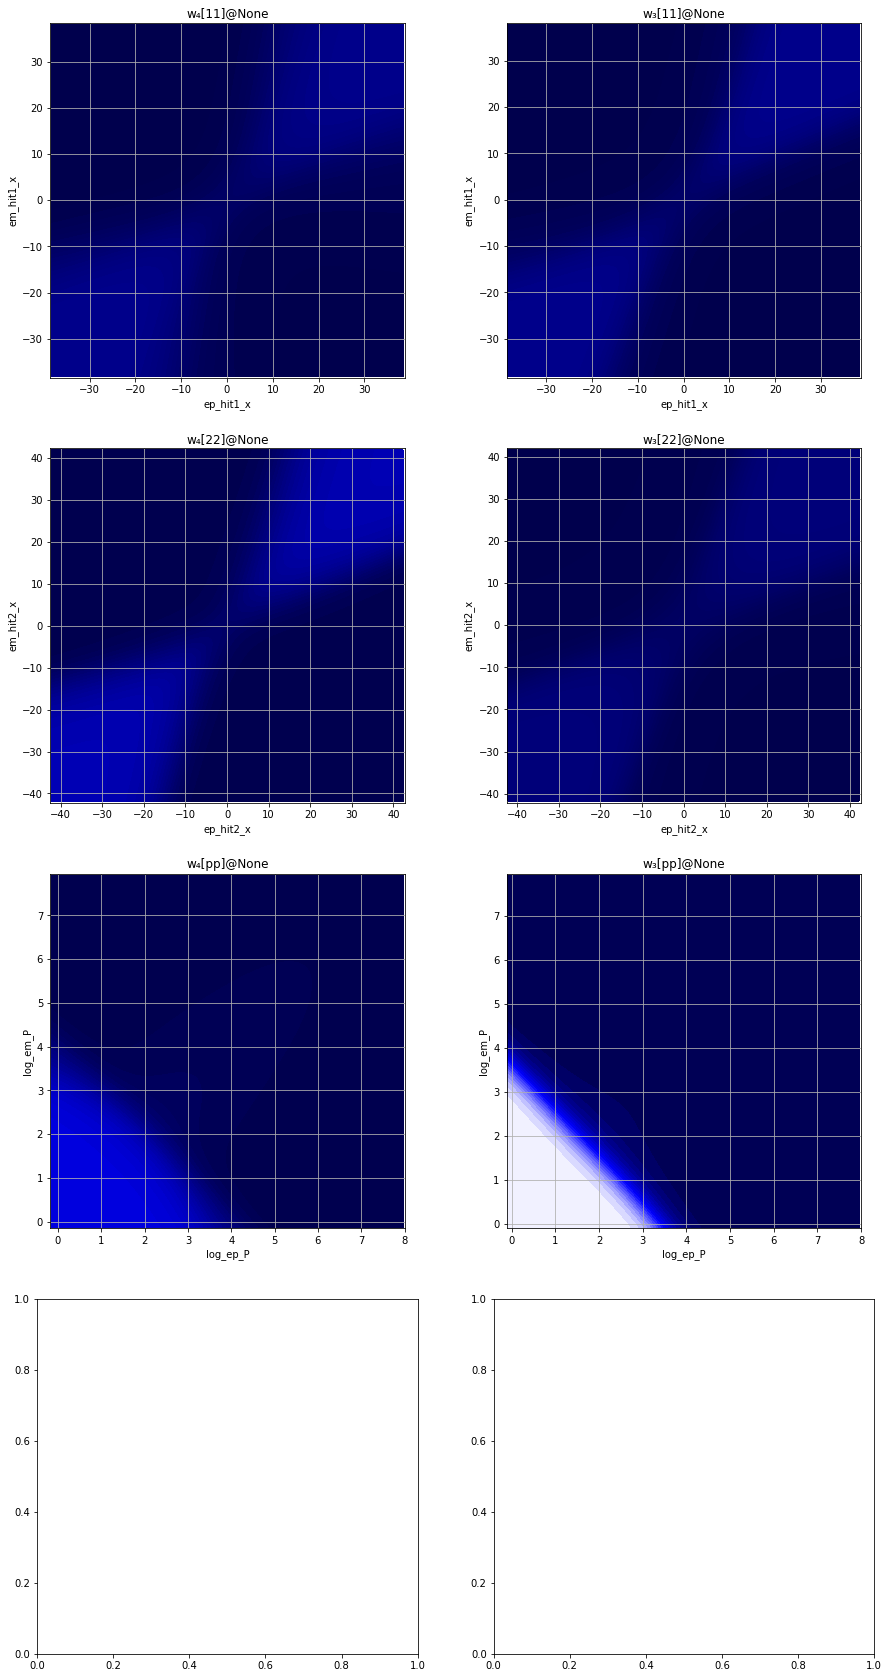

In [72]:
fig, ax = plt.subplots(4, 2, figsize=(15, 30))
for j, ds in enumerate(all_datasets):
    ax_ = ax[j//2, j%2]
    w = results[target_L, ds.name]
    sc = w.model[0]
    w_np = as_numpy(lambda x : w.model(x))
    feat = len(sc.features)
    if feat == 2:
        plot_field(w_np, sc, name=w.name, ax=ax_, color_bar=False)
    elif feat == 1:
        plot_one(w_np, sc, name=w.name, ax=ax_, vmax=None)
plt.show()

In [73]:
def make_R(df, name):
    res = ((df.iloc[1,:]/df) - 1) * 100
    res.columns.name = name
    return res

In [74]:
def make_w(datasets, estimators, name):
    df_w = pd.DataFrame()
    for w in estimators:
        df_w[w.name] = None
        for s in datasets:
            ds = Dataset(w.model[0].features, [s], aliases, name)
            x = ds.X(device=device)
            wd = w.model(x)
            df_w.loc[s.name(),w.name] = torch.mean(wd).item()
    df_w.columns.name = name
    return df_w

In [76]:
w_train = make_w(train_ds, results.values(), "train, w")
w_train

train, w        w₄[11]@None w₃[11]@None w₄[22]@None w₃[22]@None w₄[pp]@None  \
B⁺→K⁺ee            0.026232    0.026593    0.029141    0.025439    0.031063   
B⁺→K⁺J/ψ(→ee)          0.02        0.02    0.020001        0.02        0.02   
B⁺→K⁺ψ(2S)(→ee)    0.018591    0.018518    0.018054    0.018691    0.017215   
D⁺→π⁺φ(→ee)        0.023779    0.024164    0.025276    0.023576        0.07   

train, w        w₃[pp]@None w₄[6]@None w₃[6]@None  
B⁺→K⁺ee            0.037987   0.353296   0.458293  
B⁺→K⁺J/ψ(→ee)          0.02       0.02       0.02  
B⁺→K⁺ψ(2S)(→ee)    0.016972       0.01       0.01  
D⁺→π⁺φ(→ee)        0.118508       0.07   0.872343

In [78]:
w_test = make_w(test_ds, results.values(), "test, w")
w_test

test, w         w₄[11]@None w₃[11]@None w₄[22]@None w₃[22]@None w₄[pp]@None  \
B⁺→K⁺ee            0.026224    0.026612    0.029149    0.025476     0.03087   
B⁺→K⁺J/ψ(→ee)      0.020017    0.020018    0.020033    0.020016     0.01996   
B⁺→K⁺ψ(2S)(→ee)    0.018607    0.018534    0.018079    0.018708    0.017229   
D⁺→π⁺φ(→ee)        0.023867    0.024261    0.025423    0.023658    0.069627   

test, w         w₃[pp]@None w₄[6]@None w₃[6]@None  
B⁺→K⁺ee            0.037586    0.35276   0.458095  
B⁺→K⁺J/ψ(→ee)      0.019965   0.020173   0.020098  
B⁺→K⁺ψ(2S)(→ee)    0.016983   0.010005   0.010004  
D⁺→π⁺φ(→ee)        0.117579   0.070025   0.869769

In [77]:
make_R(1-w_train, "train, (R-1)*100")

train, (R-1)*100 w₄[11]@None w₃[11]@None w₄[22]@None w₃[22]@None w₄[pp]@None  \
B⁺→K⁺ee             0.640007    0.677362    0.941419    0.558082     1.14173   
B⁺→K⁺J/ψ(→ee)            0.0         0.0         0.0         0.0         0.0   
B⁺→K⁺ψ(2S)(→ee)    -0.143535   -0.150949   -0.198208   -0.133343    -0.28334   
D⁺→π⁺φ(→ee)         0.387137    0.426734     0.54119    0.366278    5.376344   

train, (R-1)*100 w₃[pp]@None w₄[6]@None  w₃[6]@None  
B⁺→K⁺ee             1.869761  51.537625   80.909693  
B⁺→K⁺J/ψ(→ee)            0.0        0.0         0.0  
B⁺→K⁺ψ(2S)(→ee)    -0.307996  -1.010101   -1.010104  
D⁺→π⁺φ(→ee)        11.175143   5.376345  667.683924

In [79]:
make_R(1-w_test, "test, (R-1)*100")

test, (R-1)*100 w₄[11]@None w₃[11]@None w₄[22]@None w₃[22]@None w₄[pp]@None  \
B⁺→K⁺ee            0.637389    0.677469    0.938943     0.56021    1.125701   
B⁺→K⁺J/ψ(→ee)           0.0         0.0         0.0         0.0         0.0   
B⁺→K⁺ψ(2S)(→ee)   -0.143643   -0.151202   -0.198976   -0.133343   -0.277883   
D⁺→π⁺φ(→ee)        0.394439    0.434837    0.553099    0.373028    5.338392   

test, (R-1)*100 w₃[pp]@None w₄[6]@None  w₃[6]@None  
B⁺→K⁺ee            1.830917  51.385296   80.825495  
B⁺→K⁺J/ψ(→ee)           0.0        0.0         0.0  
B⁺→K⁺ψ(2S)(→ee)   -0.303355  -1.027109   -1.019584  
D⁺→π⁺φ(→ee)       11.062043   5.360521  652.436705

In [83]:
def map_all(fn, results, name=None, **kwargs):
    df = pd.Series(**kwargs)
    df.name = name
    for k, w in results.items():
        for j, ds in enumerate(all_datasets):
            if len(ds.sources) != 4:
                continue
            if ds.features != w.model[0].features:
                continue
            df.loc[w.name] = fn(w, ds)
    return df

In [84]:
def compute_L(w, ds, device=device):
    data = torch.utils.data.TensorDataset(ds.X().to(device), ds.Y().to(device))
    loader = Loader(data, batch_size=100000, shuffle=True, device=device)
    return compute_lipschitz(w.model, loader, device=device)

In [85]:
map_all(compute_L, results, "L", dtype=float)

w₄[11]@None     0.074012
w₃[11]@None     0.093452
w₄[22]@None     0.152437
w₃[22]@None     0.079997
w₄[pp]@None     0.204443
w₃[pp]@None     0.651918
w₄[6]@None     17.894691
w₃[6]@None     12.829933
Name: L, dtype: float64

### L

In [92]:
%%time
L_results = dict()
for target_L in [0.05, 0.07, 0.10, 0.5, 1.0, None]:
    ds = all_datasets[6]
    est = all_est[6]
    name = "w%s@%s"%(ds.name, target_L)
    w = w_from_est(est, name=name)
    w.train(ds, target_L=target_L)
    L_results[target_L] = w

Epoch 0 loss=-4.000276 W+c=[ 1.5056 -0.2364 -0.0282 -0.2549] det=0.055601 L=2.536557
Epoch 1 loss=-4.000277 W+c=[ 1.5066 -0.2365 -0.0281 -0.2519] det=0.055891 L=2.532067
Epoch 2 loss=-4.000278 W+c=[ 1.5075 -0.2365 -0.0279 -0.249 ] det=0.056153 L=2.527499
Epoch 3 loss=-4.000278 W+c=[ 1.5083 -0.2366 -0.0277 -0.2464] det=0.056390 L=2.522830
Epoch 4 loss=-4.000279 W+c=[ 1.5091 -0.2368 -0.0276 -0.2439] det=0.056605 L=2.518022
Epoch 5 loss=-4.000279 W+c=[ 1.5099 -0.2369 -0.0274 -0.2415] det=0.056800 L=2.513050
Epoch 6 loss=-4.000280 W+c=[ 1.5106 -0.2371 -0.0273 -0.2393] det=0.056977 L=2.507893
Epoch 7 loss=-4.000281 W+c=[ 1.5112 -0.2373 -0.0271 -0.2372] det=0.057138 L=2.502532
Epoch 8 loss=-4.000281 W+c=[ 1.5118 -0.2375 -0.027  -0.2352] det=0.057286 L=2.496946
Epoch 9 loss=-4.000282 W+c=[ 1.5124 -0.2378 -0.0269 -0.2333] det=0.057420 L=2.491122
Epoch 10 loss=-4.000283 W+c=[ 1.5129 -0.238  -0.0268 -0.2315] det=0.057544 L=2.485051
Epoch 11 loss=-4.000282 W+c=[ 1.5133 -0.2383 -0.0266 -0.2299] de

Epoch 96 loss=-4.000279 W+c=[ 1.5087 -0.2617 -0.0243 -0.1894] det=0.059885 L=2.164442
Epoch 97 loss=-4.000279 W+c=[ 1.5085 -0.2619 -0.0243 -0.1893] det=0.059896 L=2.162902
Epoch 98 loss=-4.000279 W+c=[ 1.5084 -0.2621 -0.0243 -0.1892] det=0.059906 L=2.164175
Epoch 99 loss=-4.000280 W+c=[ 1.5082 -0.2623 -0.0243 -0.1891] det=0.059917 L=2.165357
Epoch 100 loss=-4.000280 W+c=[ 1.5081 -0.2625 -0.0243 -0.189 ] det=0.059927 L=2.166452
Epoch 101 loss=-4.000279 W+c=[ 1.5079 -0.2626 -0.0243 -0.1889] det=0.059938 L=2.167470
Epoch 102 loss=-4.000280 W+c=[ 1.5078 -0.2628 -0.0243 -0.1888] det=0.059948 L=2.168416
Epoch 103 loss=-4.000280 W+c=[ 1.5076 -0.263  -0.0243 -0.1887] det=0.059958 L=2.169276
Epoch 104 loss=-4.000279 W+c=[ 1.5075 -0.2631 -0.0243 -0.1886] det=0.059968 L=2.170070
Epoch 105 loss=-4.000279 W+c=[ 1.5073 -0.2633 -0.0243 -0.1885] det=0.059978 L=2.170789
Epoch 106 loss=-4.000280 W+c=[ 1.5072 -0.2635 -0.0243 -0.1884] det=0.059988 L=2.171437
Epoch 107 loss=-4.000280 W+c=[ 1.507  -0.2636 -

Epoch 191 loss=-4.000284 W+c=[ 1.4973 -0.2721 -0.0237 -0.1851] det=0.060697 L=2.118975
Epoch 192 loss=-4.000284 W+c=[ 1.4973 -0.2722 -0.0237 -0.1851] det=0.060704 L=2.118083
Epoch 193 loss=-4.000283 W+c=[ 1.4972 -0.2723 -0.0237 -0.1851] det=0.060712 L=2.117195
Epoch 194 loss=-4.000284 W+c=[ 1.4971 -0.2723 -0.0237 -0.1851] det=0.060719 L=2.116311
Epoch 195 loss=-4.000284 W+c=[ 1.497  -0.2724 -0.0237 -0.1851] det=0.060726 L=2.115433
Epoch 196 loss=-4.000284 W+c=[ 1.4969 -0.2724 -0.0237 -0.1851] det=0.060733 L=2.114561
Epoch 197 loss=-4.000285 W+c=[ 1.4968 -0.2725 -0.0237 -0.185 ] det=0.060741 L=2.113694
Epoch 198 loss=-4.000285 W+c=[ 1.4967 -0.2725 -0.0237 -0.185 ] det=0.060748 L=2.112832
Epoch 199 loss=-4.000284 W+c=[ 1.4967 -0.2726 -0.0237 -0.185 ] det=0.060755 L=2.111973
W= [[0.707  0.1262 0.0551 0.1101]
 [0.1033 0.6664 0.2359 0.0095]
 [0.0321 0.1931 0.7003 0.0041]
 [0.1576 0.0143 0.0087 0.8762]]
W+= [[ 1.4966 -0.2726 -0.0237 -0.185 ]
 [-0.2266  1.7045 -0.5566  0.0125]
 [-0.0045 -0.45

<ipython-input-65-324d27039fe8>:8: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  res = scipy.optimize.linprog(c=c, bounds=bounds, A_ub=A_ub, b_ub=b_ub)
<ipython-input-65-324d27039fe8>:8: OptimizeWarning: Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'sym_pos' to False.
  res = scipy.optimize.linprog(c=c, bounds=bounds, A_ub=A_ub, b_ub=b_ub)
<ipython-input-65-324d27039fe8>:8: OptimizeWarning: Solving system with option 'sym_pos':False failed. This may happen occasionally, especially as the solution is approached. However, if you see this frequently, your problem may be numerically challenging. If you cannot improve the formulation, consider setti

Epoch 2 loss=-4.000005 W+c=[ 2.6290e+08  6.0263e+04 -2.1638e+08 -2.1042e+00] det=0.000000 L=0.024549
Epoch 3 loss=-3.999990 W+c=[16973528.         -518.6252 -3353702.           -0.2673] det=0.000000 L=0.055018
Epoch 4 loss=-3.999975 W+c=[13878101.         -317.1781 -1915154.6          -0.2887] det=0.000000 L=0.051122
Epoch 5 loss=208.230057 W+c=[12284574.         -219.579  -1251645.1          -0.3235] det=0.000000 L=0.392238
Epoch 6 loss=-3.999990 W+c=[-1.2639e+10  1.8818e+10 -1.9636e+11  8.2977e-01] det=0.000000 L=0.000006


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.09722e-36): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.69904e-30): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=8.17259e-37): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=8.55882e-40): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.2531e-43): re

Epoch 7 loss=-3.999995 W+c=[-6.9306e+09  7.6172e+09 -5.3234e+10  6.9215e-01] det=0.000000 L=0.000018


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.41417e-34): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.86283e-52): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=7.03555e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=6.2604e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=7.57274e-38): re

Epoch 8 loss=-4.000010 W+c=[-3.8978e+09  3.1614e+09 -1.4786e+10  5.8785e-01] det=0.000000 L=0.000060
Epoch 9 loss=-4.000006 W+c=[-2.2133e+09  1.3225e+09 -4.1491e+09  5.0132e-01] det=0.000000 L=0.000201


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=7.46893e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=9.18164e-39): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.44995e-26): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.99206e-41): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.6881e-36): re

/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.00049e-25): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.85646e-38): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.2017e-28): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.7617e-35): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=8.97399e-30): res

Epoch 10 loss=-3.999995 W+c=[-1.2567e+09  5.5167e+08 -1.1665e+09  4.2562e-01] det=0.000000 L=0.000623


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.95037e-32): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.40181e-33): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.50679e-32): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.02362e-30): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 11 loss=-4.000000 W+c=[-7.0755e+08  2.2749e+08 -3.2667e+08  3.5646e-01] det=0.000000 L=0.001036


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.21712e-28): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.1201e-32): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 12 loss=-4.000003 W+c=[-3.9004e+08  9.1763e+07 -9.0728e+07  2.8915e-01] det=0.000000 L=0.001700
Epoch 13 loss=-3.999999 W+c=[-2.0604e+08  3.5716e+07 -2.5071e+07  2.1798e-01] det=0.000000 L=0.002598
Epoch 14 loss=-3.999998 W+c=[-1.0541e+08  1.3749e+07 -7.2930e+06  1.4911e-01] det=0.000000 L=0.003148


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.01579e-17): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 15 loss=-4.000003 W+c=[-58256370.       5898990.      -2577513.             0.1033] det=0.000000 L=0.002468
Epoch 16 loss=-4.000000 W+c=[-27277098.       2415467.       -990374.1            0.0283] det=0.000000 L=0.001688
Epoch 17 loss=-4.000007 W+c=[-5014117.       707096.5     -335556.97         -0.0899] det=-0.000000 L=0.004471
Epoch 18 loss=-3.999956 W+c=[1441618.8    257250.62  -146889.81       -0.163] det=0.000000 L=0.062831
Epoch 19 loss=-3.999834 W+c=[1150653.1    191464.86   -97362.44       -0.188] det=0.000000 L=0.071793
Epoch 20 loss=-4.000014 W+c=[-242111.86    185309.66    -77901.66        -0.1913] det=-0.000000 L=0.023224
Epoch 21 loss=-4.000017 W+c=[-1474662.       183146.62     -66715.12         -0.1846] det=-0.000000 L=0.003878
Epoch 22 loss=-4.000025 W+c=[-2371687.       179776.45     -59615.496        -0.1741] det=-0.000000 L=0.002318
Epoch 23 loss=-4.000018 W+c=[-2971404.5     177401.44    -55762.547       -0.166] det=-0.000000 L=0.001710
Epoch 24 loss=-4.0000

Epoch 93 loss=-3.583987 W+c=[315714.06   10127.739 -41231.965     -0.812] det=0.000000 L=0.210631
Epoch 94 loss=-3.551323 W+c=[310281.62     9696.014  -40596.707      -0.8237] det=-0.000000 L=0.215590
Epoch 95 loss=-3.516461 W+c=[304126.6      9304.396  -39980.08       -0.8335] det=0.000000 L=0.217896
Epoch 96 loss=-3.479843 W+c=[297415.7      8950.802  -39386.64       -0.8415] det=-0.000000 L=0.219423
Epoch 97 loss=-3.442102 W+c=[290380.88     8631.969  -38822.13       -0.8483] det=-0.000000 L=0.228744
Epoch 98 loss=-3.403949 W+c=[283239.94     8344.165  -38291.73       -0.8544] det=-0.000000 L=0.238585
Epoch 99 loss=-3.365731 W+c=[276144.03     8083.5723 -37797.633      -0.8601] det=-0.000000 L=0.245279
Epoch 100 loss=-3.327609 W+c=[269155.47     7846.3623 -37337.246      -0.8657] det=0.000000 L=0.243847
Epoch 101 loss=-3.289607 W+c=[262279.88     7629.4766 -36906.35       -0.8711] det=0.000000 L=0.240329
Epoch 102 loss=-3.251492 W+c=[255475.12     7430.2305 -36497.85       -0.8761] 

Epoch 173 loss=-2.260657 W+c=[ 40186.082    5122.519  -26215.836      -0.9286] det=0.000000 L=0.261623
Epoch 174 loss=-2.260645 W+c=[ 39267.887    5117.9883 -26162.266      -0.9305] det=-0.000000 L=0.261562
Epoch 175 loss=-2.260759 W+c=[ 38372.92     5113.4385 -26109.71       -0.9325] det=-0.000000 L=0.261514
Epoch 176 loss=-2.260942 W+c=[ 37499.656    5108.732  -26057.492      -0.9346] det=-0.000000 L=0.261468
Epoch 177 loss=-2.261179 W+c=[ 36648.67     5104.049  -26006.451      -0.9366] det=-0.000000 L=0.261432
Epoch 178 loss=-2.261523 W+c=[ 35818.035    5099.2104 -25955.713      -0.9387] det=-0.000000 L=0.261400
Epoch 179 loss=-2.261898 W+c=[ 35008.03     5094.3423 -25905.81       -0.9408] det=-0.000000 L=0.261373
Epoch 180 loss=-2.262373 W+c=[ 34218.13     5089.4604 -25856.816      -0.9429] det=0.000000 L=0.261352
Epoch 181 loss=-2.262809 W+c=[ 33447.156    5084.4507 -25808.238      -0.945 ] det=-0.000000 L=0.261337
Epoch 182 loss=-2.263443 W+c=[ 32694.748    5079.338  -25760.092  

Epoch 253 loss=-2.438980 W+c=[  6956.806    4645.8643 -23366.398      -1.1437] det=0.000000 L=0.250447
Epoch 254 loss=-2.442975 W+c=[  6812.752    4640.468  -23342.947      -1.1472] det=-0.000000 L=0.249978
Epoch 255 loss=-2.447007 W+c=[  6672.051    4635.1777 -23319.855      -1.1507] det=-0.000000 L=0.249500
Epoch 256 loss=-2.450959 W+c=[  6534.564    4629.921  -23296.85       -1.1542] det=-0.000000 L=0.249015
Epoch 257 loss=-2.454928 W+c=[  6400.193    4624.704  -23273.826      -1.1578] det=0.000000 L=0.248521
Epoch 258 loss=-2.458775 W+c=[  6268.9375   4619.575  -23251.016      -1.1614] det=-0.000000 L=0.248018
Epoch 259 loss=-2.462547 W+c=[  6140.6704   4614.496  -23228.182      -1.165 ] det=0.000000 L=0.247510
Epoch 260 loss=-2.466382 W+c=[  6015.2866   4609.409  -23205.11       -1.1686] det=-0.000000 L=0.246990
Epoch 261 loss=-2.470095 W+c=[  5892.8735   4604.412  -23182.248      -1.1723] det=0.000000 L=0.246463
Epoch 262 loss=-2.473767 W+c=[  5773.3135   4599.4966 -23159.418    

Epoch 333 loss=-2.271769 W+c=[  1785.05     4145.709  -19054.164      -1.3918] det=-0.000000 L=0.204438
Epoch 334 loss=-2.264040 W+c=[  1763.8131   4135.4736 -18947.176      -1.3933] det=-0.000000 L=0.204344
Epoch 335 loss=-2.256289 W+c=[  1743.0504   4125.24   -18839.723      -1.3948] det=-0.000000 L=0.204269
Epoch 336 loss=-2.248559 W+c=[  1722.7021   4114.863  -18731.314      -1.3962] det=-0.000000 L=0.204217
Epoch 337 loss=-2.240790 W+c=[  1702.7838   4104.426  -18622.271      -1.3976] det=-0.000000 L=0.204184
Epoch 338 loss=-2.233087 W+c=[  1683.2778   4093.9297 -18512.656      -1.399 ] det=-0.000000 L=0.204170
Epoch 339 loss=-2.225370 W+c=[  1664.1613   4083.3318 -18402.29       -1.4003] det=0.000000 L=0.204176
Epoch 340 loss=-2.217677 W+c=[  1645.4421   4072.6826 -18291.459      -1.4017] det=-0.000000 L=0.204200
Epoch 341 loss=-2.209949 W+c=[  1627.0978   4061.955  -18180.086      -1.403 ] det=0.000000 L=0.204242
Epoch 342 loss=-2.202264 W+c=[  1609.1318   4051.2139 -18068.42   

Epoch 413 loss=-1.746300 W+c=[   875.8854   3182.2632 -10582.706      -1.4757] det=-0.000000 L=0.205055
Epoch 414 loss=-1.741140 W+c=[   869.9191   3168.7837 -10495.216      -1.4763] det=0.000000 L=0.204814
Epoch 415 loss=-1.735975 W+c=[   864.0172   3155.2659 -10408.301      -1.4769] det=0.000000 L=0.204554
Epoch 416 loss=-1.730846 W+c=[   858.1812   3141.713  -10321.994      -1.4775] det=-0.000000 L=0.204273
Epoch 417 loss=-1.725843 W+c=[   852.4117   3128.1365 -10236.318      -1.478 ] det=0.000000 L=0.204430
Epoch 418 loss=-1.720822 W+c=[   846.7191   3114.5833 -10151.421      -1.4786] det=-0.000000 L=0.204678
Epoch 419 loss=-1.715850 W+c=[   841.084    3100.9673 -10067.045      -1.4791] det=0.000000 L=0.204901
Epoch 420 loss=-1.710738 W+c=[  835.5164  3087.343  -9983.342     -1.4796] det=-0.000000 L=0.205102
Epoch 421 loss=-1.705827 W+c=[  830.0032  3073.6665 -9900.164     -1.48  ] det=0.000000 L=0.205278
Epoch 422 loss=-1.700892 W+c=[  824.5587  3059.9954 -9817.689     -1.4805] de

Epoch 496 loss=-1.393442 W+c=[  538.3443  2070.2197 -5305.005     -1.4546] det=-0.000000 L=0.195326
Epoch 497 loss=-1.390201 W+c=[  535.5283  2058.7524 -5263.258     -1.4534] det=-0.000000 L=0.195534
Epoch 498 loss=-1.387024 W+c=[  532.7328  2047.3921 -5221.9946    -1.4522] det=0.000000 L=0.195719
Epoch 499 loss=-1.383947 W+c=[  529.9565  2036.132  -5181.1816    -1.451 ] det=0.000000 L=0.195879
W= [[0.0252 0.0444 0.0723 0.0044]
 [0.0043 0.0097 0.0221 0.0006]
 [0.0038 0.0081 0.0159 0.0004]
 [0.9666 0.9377 0.8897 0.9947]]
W+= [[  527.1969  2024.966  -5140.816     -1.4498]
 [ -339.0727 -1927.9196  4177.2393     0.943 ]
 [   52.5241   514.1244  -882.6868    -0.1746]
 [ -239.6483  -610.1708  1847.2635     1.6814]]
L= 0.19601713120937347
coef= [[0.     0.     0.     0.0213]]
Epoch 0 loss=-4.000276 W+c=[ 1.5056 -0.2364 -0.0282 -0.2549] det=0.055601 L=2.536557
Epoch 1 loss=-4.000277 W+c=[ 1.5066 -0.2365 -0.0281 -0.2519] det=0.055891 L=2.532067
Epoch 2 loss=-4.000278 W+c=[ 1.5075 -0.2365 -0.027

Epoch 87 loss=-4.000279 W+c=[ 1.5101 -0.26   -0.0243 -0.1905] det=0.059786 L=2.191406
Epoch 88 loss=-4.000278 W+c=[ 1.5099 -0.2602 -0.0243 -0.1904] det=0.059798 L=2.188480
Epoch 89 loss=-4.000278 W+c=[ 1.5098 -0.2604 -0.0243 -0.1902] det=0.059809 L=2.185507
Epoch 90 loss=-4.000278 W+c=[ 1.5096 -0.2606 -0.0243 -0.1901] det=0.059820 L=2.182491
Epoch 91 loss=-4.000278 W+c=[ 1.5095 -0.2608 -0.0243 -0.19  ] det=0.059831 L=2.179430
Epoch 92 loss=-4.000279 W+c=[ 1.5093 -0.261  -0.0243 -0.1899] det=0.059842 L=2.176332
Epoch 93 loss=-4.000278 W+c=[ 1.5091 -0.2612 -0.0243 -0.1897] det=0.059853 L=2.173198
Epoch 94 loss=-4.000279 W+c=[ 1.509  -0.2614 -0.0243 -0.1896] det=0.059864 L=2.170043
Epoch 95 loss=-4.000279 W+c=[ 1.5088 -0.2615 -0.0243 -0.1895] det=0.059875 L=2.167258
Epoch 96 loss=-4.000279 W+c=[ 1.5087 -0.2617 -0.0243 -0.1894] det=0.059885 L=2.164442
Epoch 97 loss=-4.000279 W+c=[ 1.5085 -0.2619 -0.0243 -0.1893] det=0.059896 L=2.162902
Epoch 98 loss=-4.000279 W+c=[ 1.5084 -0.2621 -0.0243 -

Epoch 182 loss=-4.000284 W+c=[ 1.4981 -0.2716 -0.0238 -0.1852] det=0.060630 L=2.127212
Epoch 183 loss=-4.000284 W+c=[ 1.4981 -0.2717 -0.0238 -0.1852] det=0.060637 L=2.126280
Epoch 184 loss=-4.000283 W+c=[ 1.498  -0.2717 -0.0238 -0.1852] det=0.060645 L=2.125353
Epoch 185 loss=-4.000283 W+c=[ 1.4979 -0.2718 -0.0238 -0.1852] det=0.060652 L=2.124433
Epoch 186 loss=-4.000284 W+c=[ 1.4978 -0.2718 -0.0238 -0.1852] det=0.060660 L=2.123513
Epoch 187 loss=-4.000284 W+c=[ 1.4977 -0.2719 -0.0238 -0.1852] det=0.060667 L=2.122595
Epoch 188 loss=-4.000283 W+c=[ 1.4976 -0.272  -0.0237 -0.1851] det=0.060675 L=2.121684
Epoch 189 loss=-4.000284 W+c=[ 1.4975 -0.272  -0.0237 -0.1851] det=0.060682 L=2.120778
Epoch 190 loss=-4.000284 W+c=[ 1.4974 -0.2721 -0.0237 -0.1851] det=0.060689 L=2.119875
Epoch 191 loss=-4.000284 W+c=[ 1.4973 -0.2721 -0.0237 -0.1851] det=0.060697 L=2.118975
Epoch 192 loss=-4.000284 W+c=[ 1.4973 -0.2722 -0.0237 -0.1851] det=0.060704 L=2.118083
Epoch 193 loss=-4.000283 W+c=[ 1.4972 -0.27

/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.7468e-34): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.58537e-36): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.68218e-35): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.19845e-56): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.44788e-33): re

Epoch 18 loss=-3.999918 W+c=[-1.7154e+12 -7.2799e-01  8.7523e+01  8.0639e+11] det=-0.000000 L=0.000000
Epoch 19 loss=-3.999647 W+c=[-1.5605e+12 -8.0806e-01  2.9386e+01  6.6602e+11] det=-0.000000 L=0.000000
Epoch 20 loss=-4.000543 W+c=[-1.5996e+12 -9.2362e-01  2.6358e+01  6.2066e+11] det=-0.000000 L=0.000000
Epoch 21 loss=-4.000254 W+c=[-1.4155e+12 -9.5014e-01  2.5842e+01  5.1473e+11] det=0.000000 L=0.000000
Epoch 22 loss=-4.000161 W+c=[-1.1993e+12 -9.4674e-01  2.5062e+01  4.1167e+11] det=-0.000000 L=0.000000
Epoch 23 loss=-3.999578 W+c=[-1.0108e+12 -9.3829e-01  2.4285e+01  3.2770e+11] det=-0.000000 L=0.000000
Epoch 24 loss=-4.000412 W+c=[-8.5483e+11 -9.3039e-01  2.3627e+01  2.6155e+11] det=-0.000000 L=0.000000
Epoch 25 loss=-4.000122 W+c=[-7.2349e+11 -9.2183e-01  2.3004e+01  2.0883e+11] det=-0.000000 L=0.000000
Epoch 26 loss=-4.000033 W+c=[-6.1413e+11 -9.1373e-01  2.2450e+01  1.6712e+11] det=-0.000000 L=0.000000
Epoch 27 loss=-3.999977 W+c=[-5.2251e+11 -9.0588e-01  2.1953e+01  1.3398e+

/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.17823e-37): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=7.82098e-32): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.82299e-31): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.73902e-78): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.73586e-78): r

Epoch 29 loss=-4.000008 W+c=[-3.8062e+11 -8.9106e-01  2.1090e+01  8.6547e+10] det=-0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=6.0429e-36): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=6.65472e-39): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.39117e-24): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.48393e-26): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.50515e-45): re

Epoch 30 loss=-3.999935 W+c=[-3.2578e+11 -8.8384e-01  2.0711e+01  6.9718e+10] det=-0.000000 L=0.000000
Epoch 31 loss=-4.000039 W+c=[-2.7939e+11 -8.7692e-01  2.0367e+01  5.6253e+10] det=-0.000000 L=0.000000
Epoch 32 loss=-4.000032 W+c=[-2.3996e+11 -8.6994e-01  2.0046e+01  4.5447e+10] det=-0.000000 L=0.000000
Epoch 33 loss=-4.000085 W+c=[-2.0646e+11 -8.6328e-01  1.9752e+01  3.6769e+10] det=0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.44595e-49): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 34 loss=-4.000015 W+c=[-1.7787e+11 -8.5657e-01  1.9475e+01  2.9783e+10] det=-0.000000 L=0.000000
Epoch 35 loss=-3.999996 W+c=[-1.5349e+11 -8.5006e-01  1.9219e+01  2.4158e+10] det=-0.000000 L=0.000000
Epoch 36 loss=-4.000000 W+c=[-1.3263e+11 -8.4360e-01  1.8981e+01  1.9620e+10] det=-0.000000 L=0.000000
Epoch 37 loss=-4.000019 W+c=[-1.1477e+11 -8.3729e-01  1.8758e+01  1.5954e+10] det=-0.000000 L=0.000000
Epoch 38 loss=-4.000046 W+c=[-9.9444e+10 -8.3100e-01  1.8550e+01  1.2988e+10] det=-0.000000 L=0.000000
Epoch 39 loss=-4.000024 W+c=[-8.6268e+10 -8.2481e-01  1.8353e+01  1.0586e+10] det=0.000000 L=0.000000
Epoch 40 loss=-4.000017 W+c=[-7.4932e+10 -8.1867e-01  1.8168e+01  8.6374e+09] det=0.000000 L=0.000000
Epoch 41 loss=-3.999985 W+c=[-6.5161e+10 -8.1259e-01  1.7993e+01  7.0554e+09] det=-0.000000 L=0.000000
Epoch 42 loss=-3.999993 W+c=[-5.6733e+10 -8.0660e-01  1.7829e+01  5.7696e+09] det=-0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.92569e-41): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.08879e-85): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=9.89368e-139): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.56657e-57): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.83454e-38): 

Epoch 43 loss=-3.999998 W+c=[-4.9448e+10 -8.0066e-01  1.7673e+01  4.7231e+09] det=0.000000 L=0.000000
Epoch 44 loss=-3.999989 W+c=[-4.3145e+10 -7.9476e-01  1.7525e+01  3.8704e+09] det=0.000000 L=0.000000
Epoch 45 loss=-3.999997 W+c=[-3.7686e+10 -7.8892e-01  1.7385e+01  3.1749e+09] det=0.000000 L=0.000000
Epoch 46 loss=-4.000010 W+c=[-3.2951e+10 -7.8313e-01  1.7252e+01  2.6070e+09] det=-0.000000 L=0.000000
Epoch 47 loss=-3.999998 W+c=[-2.8840e+10 -7.7737e-01  1.7125e+01  2.1427e+09] det=-0.000000 L=0.000000
Epoch 48 loss=-4.000006 W+c=[-2.5266e+10 -7.7165e-01  1.7004e+01  1.7628e+09] det=0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.40972e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 49 loss=-4.000010 W+c=[-2.2156e+10 -7.6597e-01  1.6888e+01  1.4516e+09] det=-0.000000 L=0.000000
Epoch 50 loss=-3.999995 W+c=[-1.9446e+10 -7.6032e-01  1.6777e+01  1.1965e+09] det=-0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.61667e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 51 loss=-3.999999 W+c=[-1.7083e+10 -7.5471e-01  1.6670e+01  9.8708e+08] det=-0.000000 L=0.000000
Epoch 52 loss=-4.000000 W+c=[-1.5021e+10 -7.4913e-01  1.6568e+01  8.1506e+08] det=-0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.61861e-22): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 53 loss=-3.999999 W+c=[-1.3219e+10 -7.4357e-01  1.6470e+01  6.7360e+08] det=-0.000000 L=0.000000
Epoch 54 loss=-3.999996 W+c=[-1.1642e+10 -7.3804e-01  1.6376e+01  5.5717e+08] det=-0.000000 L=0.000000
Epoch 55 loss=-4.000002 W+c=[-1.0262e+10 -7.3253e-01  1.6285e+01  4.6125e+08] det=-0.000000 L=0.000000
Epoch 56 loss=-4.000002 W+c=[-9.0532e+09 -7.2705e-01  1.6197e+01  3.8217e+08] det=-0.000000 L=0.000000
Epoch 57 loss=-4.000002 W+c=[-7.9926e+09 -7.2158e-01  1.6112e+01  3.1689e+08] det=0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.97467e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.47923e-22): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.63033e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=7.13183e-23): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.82368e-41): r

/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.05982e-40): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.46731e-40): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=5.59699e-44): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.50169e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.29847e-40): r

Epoch 58 loss=-3.999994 W+c=[-7.0617e+09 -7.1613e-01  1.6030e+01  2.6298e+08] det=-0.000000 L=0.000000
Epoch 59 loss=-4.000001 W+c=[-6.2439e+09 -7.1070e-01  1.5950e+01  2.1841e+08] det=-0.000000 L=0.000000
Epoch 60 loss=-4.000006 W+c=[-5.5247e+09 -7.0528e-01  1.5873e+01  1.8153e+08] det=-0.000000 L=0.000000
Epoch 61 loss=-4.000002 W+c=[-4.8918e+09 -6.9987e-01  1.5798e+01  1.5099e+08] det=0.000000 L=0.000000
Epoch 62 loss=-4.000003 W+c=[-4.3345e+09 -6.9447e-01  1.5724e+01  1.2568e+08] det=-0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.63984e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 63 loss=-4.000000 W+c=[-3.8432e+09 -6.8908e-01  1.5653e+01  1.0469e+08] det=-0.000000 L=0.000000
Epoch 64 loss=-3.999998 W+c=[-3.4098e+09 -6.8369e-01  1.5583e+01  8.7267e+07] det=-0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=6.26259e-25): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.07328e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=6.10508e-29): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.16872e-28): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.82593e-41): r

Epoch 65 loss=-3.988676 W+c=[-3.0273e+09 -6.7831e-01  1.5515e+01  7.2793e+07] det=-0.000000 L=0.059013
Epoch 66 loss=-4.000004 W+c=[-2.6792e+09 -6.7142e-01  1.5422e+01  6.0573e+07] det=-0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.15926e-40): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=6.84746e-44): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.38629e-48): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=8.03757e-38): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.7995e-38): re

Epoch 67 loss=-4.000002 W+c=[-2.3865e+09 -6.6683e-01  1.5372e+01  5.0675e+07] det=-0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.45702e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.9426e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=9.39909e-22): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 68 loss=-4.000001 W+c=[-2.1248e+09 -6.6183e-01  1.5316e+01  4.2388e+07] det=-0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=6.34962e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.28735e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.68033e-23): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.49973e-23): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 69 loss=-3.999998 W+c=[-1.8919e+09 -6.5664e-01  1.5256e+01  3.5465e+07] det=-0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.77027e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=7.3656e-28): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 70 loss=-4.000002 W+c=[-1.6851e+09 -6.5136e-01  1.5196e+01  2.9685e+07] det=-0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.16387e-24): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 71 loss=-4.000000 W+c=[-1.5016e+09 -6.4603e-01  1.5135e+01  2.4860e+07] det=-0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.167e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.07227e-38): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.83453e-34): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.0552e-33): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.22544e-19): resu

Epoch 72 loss=-3.999997 W+c=[-1.3386e+09 -6.4067e-01  1.5075e+01  2.0830e+07] det=-0.000000 L=0.000000
Epoch 73 loss=-4.000001 W+c=[-1.1940e+09 -6.3530e-01  1.5015e+01  1.7463e+07] det=-0.000000 L=0.000000
Epoch 74 loss=-4.000001 W+c=[-1.0655e+09 -6.2992e-01  1.4956e+01  1.4648e+07] det=0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=9.50238e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 75 loss=-4.000000 W+c=[-9.5132e+08 -6.2453e-01  1.4897e+01  1.2294e+07] det=0.000000 L=0.000000
Epoch 76 loss=-4.000003 W+c=[-8.4977e+08 -6.1914e-01  1.4839e+01  1.0324e+07] det=0.000000 L=0.000000
Epoch 77 loss=-4.000001 W+c=[-7.5941e+08 -6.1375e-01  1.4781e+01  8.6734e+06] det=0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.04922e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 78 loss=-4.000000 W+c=[-6.7897e+08 -6.0836e-01  1.4723e+01  7.2906e+06] det=-0.000000 L=0.000001
Epoch 79 loss=-4.000000 W+c=[-6.0732e+08 -6.0300e-01  1.4665e+01  6.1313e+06] det=0.000000 L=0.000001
Epoch 80 loss=-4.000001 W+c=[-5.4345e+08 -5.9765e-01  1.4608e+01  5.1587e+06] det=-0.000000 L=0.000001


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.16661e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 81 loss=-3.999997 W+c=[-4.8650e+08 -5.9236e-01  1.4550e+01  4.3423e+06] det=-0.000000 L=0.000001


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.07758e-22): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 82 loss=-3.999999 W+c=[-4.3568e+08 -5.8714e-01  1.4492e+01  3.6567e+06] det=-0.000000 L=0.000001
Epoch 83 loss=-4.000000 W+c=[-3.9030e+08 -5.8206e-01  1.4433e+01  3.0806e+06] det=-0.000000 L=0.000001
Epoch 84 loss=-4.000002 W+c=[-3.4977e+08 -5.7718e-01  1.4374e+01  2.5963e+06] det=-0.000000 L=0.000001
Epoch 85 loss=-4.000001 W+c=[-3.1353e+08 -5.7262e-01  1.4314e+01  2.1889e+06] det=-0.000000 L=0.000001
Epoch 86 loss=-4.000003 W+c=[-2.8110e+08 -5.6856e-01  1.4252e+01  1.8460e+06] det=0.000000 L=0.000001
Epoch 87 loss=-4.000000 W+c=[-2.5207e+08 -5.6532e-01  1.4188e+01  1.5572e+06] det=0.000000 L=0.000002
Epoch 88 loss=-4.000000 W+c=[-2.2603e+08 -5.6335e-01  1.4121e+01  1.3138e+06] det=0.000000 L=0.000002
Epoch 89 loss=-4.000001 W+c=[-2.0264e+08 -5.6342e-01  1.4048e+01  1.1086e+06] det=-0.000000 L=0.000002


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=6.97493e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 90 loss=-3.984701 W+c=[-1.8159e+08 -5.6678e-01  1.3967e+01  9.3543e+05] det=-0.000000 L=0.061386
Epoch 91 loss=-3.984867 W+c=[-1.6191e+08 -5.7428e-01  1.3848e+01  7.8650e+05] det=-0.000000 L=0.061278
Epoch 92 loss=-3.999999 W+c=[-1.4437e+08 -5.9107e-01  1.3721e+01  6.6185e+05] det=-0.000000 L=0.000010
Epoch 93 loss=-4.000002 W+c=[-1.2893e+08 -6.2436e-01  1.3589e+01  5.5841e+05] det=0.000000 L=0.000019


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.75046e-17): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 94 loss=-3.984097 W+c=[-1.1428e+08 -6.8336e-01  1.3387e+01  4.6948e+05] det=-0.000000 L=0.419899
Epoch 95 loss=-4.000002 W+c=[-99669624.            -0.787         13.0489    391448.8   ] det=-0.000000 L=0.000065
Epoch 96 loss=-3.982732 W+c=[-85396110.            -0.9815        12.5373    324937.53  ] det=0.000000 L=1.492006
Epoch 97 loss=-3.977568 W+c=[-69321976.            -1.3429        11.6111    264347.8   ] det=-0.000000 L=2.341173
Epoch 98 loss=-3.968369 W+c=[-49750028.            -2.0542         9.899     208165.34  ] det=-0.000000 L=2.599326
Epoch 99 loss=-3.930575 W+c=[-19624090.            -3.6789         6.1172    148752.44  ] det=-0.000000 L=3.134106
Epoch 100 loss=-4.000008 W+c=[33469454.           -7.4719       -2.58      76920.72  ] det=-0.000000 L=0.007537
Epoch 101 loss=7.851478 W+c=[91474100.          -12.83        -15.0796     8177.869 ] det=-0.000000 L=3.702436
Epoch 102 loss=-4.000001 W+c=[-2.6833e+08 -3.2641e-01  1.3293e+01  4.2218e+06] det=-0.000000 L=0.000

/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=6.50211e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 107 loss=-4.000006 W+c=[-1.9908e+08 -3.0010e-01  1.2645e+01  2.2458e+06] det=-0.000000 L=0.000002
Epoch 108 loss=-4.000000 W+c=[-1.8298e+08 -2.9193e-01  1.2683e+01  1.9420e+06] det=-0.000000 L=0.000003
Epoch 109 loss=-4.000003 W+c=[-1.6772e+08 -2.8346e-01  1.2702e+01  1.6757e+06] det=0.000000 L=0.000003
Epoch 110 loss=-3.999997 W+c=[-1.5348e+08 -2.7476e-01  1.2706e+01  1.4442e+06] det=0.000000 L=0.000003
Epoch 111 loss=-4.000000 W+c=[-1.4034e+08 -2.6589e-01  1.2701e+01  1.2441e+06] det=-0.000000 L=0.000003
Epoch 112 loss=-3.999999 W+c=[-1.2828e+08 -2.5688e-01  1.2690e+01  1.0716e+06] det=-0.000000 L=0.000004
Epoch 113 loss=-4.000003 W+c=[-1.1725e+08 -2.4774e-01  1.2675e+01  9.2319e+05] det=-0.000000 L=0.000004
Epoch 114 loss=-3.964703 W+c=[-1.0717e+08 -2.3848e-01  1.2656e+01  7.9553e+05] det=-0.000000 L=0.068233
Epoch 115 loss=-4.000002 W+c=[-97476120.            -0.2293        12.6002    682615.4   ] det=-0.000000 L=0.000005
Epoch 116 loss=-4.000003 W+c=[-89329500.            -0

Epoch 181 loss=-2.926339 W+c=[-1005326.           -0.1557       10.2795     1718.187 ] det=-0.000000 L=2.134703
Epoch 182 loss=-4.000169 W+c=[-963977.1         -0.1655      10.1763    1736.6951] det=-0.000000 L=0.000082
Epoch 183 loss=-2.681746 W+c=[-915281.44        -0.167       10.2508    1591.5725] det=0.000000 L=2.148079
Epoch 184 loss=-2.874757 W+c=[-877371.44        -0.1784      10.0975    1639.1007] det=0.000000 L=2.133485
Epoch 185 loss=-2.979011 W+c=[-842564.6         -0.188        9.9924    1665.8499] det=-0.000000 L=2.124566
Epoch 186 loss=-3.041878 W+c=[-809488.94        -0.1967       9.9088    1679.8553] det=0.000000 L=2.117833
Epoch 187 loss=-3.082379 W+c=[-777643.          -0.2049       9.8367    1685.3989] det=0.000000 L=2.112712
Epoch 188 loss=-3.109671 W+c=[-746839.6         -0.2127       9.7713    1685.0842] det=-0.000000 L=2.108741
Epoch 189 loss=-3.128707 W+c=[-717029.94        -0.2203       9.7101    1680.6427] det=-0.000000 L=2.105582
Epoch 190 loss=-3.142360 W+c

Epoch 258 loss=-3.300162 W+c=[-43240.934      -0.6015      6.6473    918.229 ] det=-0.000000 L=2.116576
Epoch 259 loss=-3.302075 W+c=[-41550.566      -0.6061      6.6102    909.6776] det=0.000000 L=2.116383
Epoch 260 loss=-3.303984 W+c=[-39926.69       -0.6107      6.5732    901.1928] det=0.000000 L=2.116165
Epoch 261 loss=-3.305888 W+c=[-38366.773      -0.6153      6.5364    892.7759] det=-0.000000 L=2.115922
Epoch 262 loss=-3.307776 W+c=[-36868.164      -0.6198      6.4997    884.4247] det=-0.000000 L=2.115656
Epoch 263 loss=-3.309661 W+c=[-35428.727      -0.6243      6.4631    876.1467] det=-0.000000 L=2.115361
Epoch 264 loss=-3.311524 W+c=[-34045.773      -0.6288      6.4267    867.9332] det=0.000000 L=2.115041
Epoch 265 loss=-3.313388 W+c=[-32717.164      -0.6333      6.3903    859.7878] det=-0.000000 L=2.114694
Epoch 266 loss=-3.315233 W+c=[-31440.697      -0.6378      6.3541    851.7086] det=-0.000000 L=2.114322
Epoch 267 loss=-3.317089 W+c=[-30214.504      -0.6422      6.3181  

Epoch 339 loss=-3.479521 W+c=[-1684.7639    -0.9352     4.0021   418.7706] det=0.000000 L=1.992108
Epoch 340 loss=-3.483125 W+c=[-1615.8037    -0.939      3.9727   414.5499] det=0.000000 L=1.988551
Epoch 341 loss=-3.486826 W+c=[-1549.483     -0.9429     3.9434   410.3633] det=0.000000 L=1.984923
Epoch 342 loss=-3.490605 W+c=[-1485.6953    -0.9468     3.914    406.2097] det=-0.000000 L=1.981226
Epoch 343 loss=-3.494483 W+c=[-1424.3494    -0.9507     3.8847   402.0893] det=0.000000 L=1.977457
Epoch 344 loss=-3.498451 W+c=[-1365.3467    -0.9545     3.8554   398.0012] det=0.000000 L=1.973614
Epoch 345 loss=-3.502517 W+c=[-1308.5996    -0.9584     3.8262   393.9454] det=0.000000 L=1.969695
Epoch 346 loss=-3.506682 W+c=[-1254.0276    -0.9623     3.7969   389.9232] det=0.000000 L=1.965702
Epoch 347 loss=-3.510963 W+c=[-1201.5415    -0.9662     3.7676   385.9335] det=0.000000 L=1.961630
Epoch 348 loss=-3.515365 W+c=[-1151.074     -0.9701     3.7383   381.9798] det=0.000000 L=1.957469
Epoch 349

Epoch 426 loss=-3.690575 W+c=[-28.6819  -1.2464   1.7965 202.3282] det=0.000000 L=2.569471
Epoch 427 loss=-3.686548 W+c=[-27.2502  -1.25     1.7771 201.0842] det=0.000000 L=2.564432
Epoch 428 loss=-3.682383 W+c=[-25.8801  -1.2535   1.7579 199.8543] det=0.000000 L=2.559486
Epoch 429 loss=-3.678135 W+c=[-24.5689  -1.2571   1.7388 198.6396] det=0.000000 L=2.554436
Epoch 430 loss=-3.673765 W+c=[-23.3137  -1.2607   1.7197 197.438 ] det=0.000000 L=2.549573
Epoch 431 loss=-3.669258 W+c=[-22.1118  -1.2643   1.7007 196.2502] det=0.000000 L=2.544770
Epoch 432 loss=-3.664692 W+c=[-20.9611  -1.2679   1.6819 195.077 ] det=0.000000 L=2.539930
Epoch 433 loss=-3.659930 W+c=[-19.8587  -1.2715   1.6631 193.9157] det=0.000000 L=2.535254
Epoch 434 loss=-3.655137 W+c=[-18.803   -1.2752   1.6444 192.7699] det=0.000000 L=2.530456
Epoch 435 loss=-3.650210 W+c=[-17.7913  -1.2788   1.6258 191.6362] det=0.000000 L=2.525752
Epoch 436 loss=-3.645174 W+c=[-16.8217  -1.2825   1.6073 190.5155] det=0.000000 L=2.521144

Epoch 13 loss=-4.000281 W+c=[ 1.5142 -0.2388 -0.0264 -0.2267] det=0.057857 L=2.465242
Epoch 14 loss=-4.000281 W+c=[ 1.5146 -0.2391 -0.0263 -0.2253] det=0.057946 L=2.458088
Epoch 15 loss=-4.000281 W+c=[ 1.5149 -0.2394 -0.0262 -0.2239] det=0.058028 L=2.450659
Epoch 16 loss=-4.000280 W+c=[ 1.5152 -0.2397 -0.0261 -0.2226] det=0.058104 L=2.449467
Epoch 17 loss=-4.000280 W+c=[ 1.5155 -0.24   -0.026  -0.2213] det=0.058175 L=2.449315
Epoch 18 loss=-4.000279 W+c=[ 1.5157 -0.2403 -0.0259 -0.2201] det=0.058240 L=2.448860
Epoch 19 loss=-4.000279 W+c=[ 1.5159 -0.2407 -0.0258 -0.219 ] det=0.058302 L=2.448087
Epoch 20 loss=-4.000278 W+c=[ 1.5161 -0.241  -0.0258 -0.2179] det=0.058360 L=2.447005
Epoch 21 loss=-4.000278 W+c=[ 1.5163 -0.2413 -0.0257 -0.2168] det=0.058414 L=2.445610
Epoch 22 loss=-4.000278 W+c=[ 1.5165 -0.2416 -0.0256 -0.2158] det=0.058464 L=2.443882
Epoch 23 loss=-4.000278 W+c=[ 1.5166 -0.242  -0.0255 -0.2149] det=0.058512 L=2.441838
Epoch 24 loss=-4.000278 W+c=[ 1.5167 -0.2423 -0.0255 -

Epoch 109 loss=-4.000279 W+c=[ 1.5067 -0.264  -0.0242 -0.1882] det=0.060018 L=2.172992
Epoch 110 loss=-4.000279 W+c=[ 1.5066 -0.2641 -0.0242 -0.1881] det=0.060027 L=2.173379
Epoch 111 loss=-4.000280 W+c=[ 1.5064 -0.2643 -0.0242 -0.188 ] det=0.060037 L=2.173718
Epoch 112 loss=-4.000280 W+c=[ 1.5063 -0.2644 -0.0242 -0.1879] det=0.060047 L=2.173993
Epoch 113 loss=-4.000280 W+c=[ 1.5061 -0.2646 -0.0242 -0.1879] det=0.060056 L=2.174208
Epoch 114 loss=-4.000280 W+c=[ 1.506  -0.2647 -0.0242 -0.1878] det=0.060066 L=2.174371
Epoch 115 loss=-4.000280 W+c=[ 1.5059 -0.2649 -0.0242 -0.1877] det=0.060075 L=2.174485
Epoch 116 loss=-4.000280 W+c=[ 1.5057 -0.265  -0.0242 -0.1876] det=0.060085 L=2.174551
Epoch 117 loss=-4.000280 W+c=[ 1.5056 -0.2652 -0.0242 -0.1876] det=0.060094 L=2.174566
Epoch 118 loss=-4.000280 W+c=[ 1.5054 -0.2653 -0.0242 -0.1875] det=0.060103 L=2.174537
Epoch 119 loss=-4.000281 W+c=[ 1.5053 -0.2654 -0.0242 -0.1874] det=0.060112 L=2.174459
Epoch 120 loss=-4.000281 W+c=[ 1.5052 -0.26

Epoch 0 loss=92.351013 W+c=[ 1.4966 -0.2726 -0.0237 -0.185 ] det=0.060762 L=2.111126
Epoch 1 loss=1545.142212 W+c=[41.4007 -0.0732  0.1332 -0.1372] det=0.000009 L=14.596147


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.56235e-30): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.7605e-28): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=8.27366e-28): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.46198e-27): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.2896e-26): res

Epoch 2 loss=-3.000000 W+c=[-1.9845e+01 -3.5583e+00 -3.8889e+04  1.5357e+09] det=0.000000 L=0.011115
Epoch 3 loss=-3.000000 W+c=[-5.5221e+01 -3.5784e-01 -4.9650e+05  3.9002e+08] det=0.000000 L=0.000048
Epoch 4 loss=-3.000001 W+c=[ 2.4093e+01 -3.4693e-01 -4.2921e+05  2.9031e+08] det=0.000000 L=0.000071


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=7.40611e-31): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=7.11939e-33): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.55601e-36): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 5 loss=-3.000001 W+c=[ 4.0444e+00 -3.3626e-01 -3.6904e+05  2.1579e+08] det=0.000000 L=0.000067
Epoch 6 loss=-3.000002 W+c=[-1.7828e+00 -3.2583e-01 -3.1535e+05  1.6014e+08] det=0.000000 L=0.000149
Epoch 7 loss=-3.000002 W+c=[ 2.4518e-01 -3.1564e-01 -2.6758e+05  1.1863e+08] det=0.000000 L=0.000217


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.73905e-31): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 8 loss=-3.000003 W+c=[       3.6235       -0.3057  -225211.86   87702904.    ] det=0.000000 L=0.000314
Epoch 9 loss=-3.000005 W+c=[      -0.4928       -0.296   -187777.81   64691444.    ] det=0.000000 L=0.000188
Epoch 10 loss=-3.000005 W+c=[      -0.22         -0.2865  -154860.56   47596464.    ] det=0.000000 L=0.000296
Epoch 11 loss=-3.000009 W+c=[       0.2779       -0.2773  -126083.1    34919724.    ] det=0.000000 L=0.000445
Epoch 12 loss=-3.000012 W+c=[       0.1803       -0.2683  -101103.8    25538634.    ] det=0.000000 L=0.000657
Epoch 13 loss=-3.000016 W+c=[       0.082        -0.2595   -79615.67   18612650.    ] det=0.000000 L=0.000945
Epoch 14 loss=-3.000022 W+c=[       0.1088       -0.2509   -61338.375  13512941.    ] det=0.000000 L=0.002718
Epoch 15 loss=-3.000031 W+c=[      0.0679      -0.2425  -46014.125  9769343.    ] det=0.000000 L=0.004000
Epoch 16 loss=-3.000043 W+c=[      0.0356      -0.2343  -33400.973  7030740.    ] det=-0.000000 L=0.005890
Epoch 17 loss=-3.00

/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=8.0066e-31): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.99567e-31): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 59 loss=-3.941346 W+c=[-2.8594e+14  1.9258e+00 -2.9482e+00  9.1632e+03] det=-0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.57431e-27): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.63832e-28): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 60 loss=-3.966390 W+c=[-1.9049e+14  1.3745e+00 -9.9237e-01  5.9994e+03] det=-0.000000 L=0.000000
Epoch 61 loss=-4.034703 W+c=[-1.4561e+14  1.0063e+00  2.4408e-01  4.5216e+03] det=0.000000 L=0.000000
Epoch 62 loss=-4.021914 W+c=[-1.0690e+14  7.2347e-01  1.1657e+00  3.2772e+03] det=-0.000000 L=0.000000
Epoch 63 loss=-3.959888 W+c=[-7.7589e+13  4.6234e-01  1.4352e+00  2.3537e+03] det=0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=8.17272e-34): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 64 loss=-3.979809 W+c=[-6.3302e+13  3.1592e-01  1.8829e+00  1.8964e+03] det=0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.99036e-26): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.09345e-28): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=8.26223e-30): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 65 loss=-4.015677 W+c=[-5.3142e+13  2.0429e-01  2.6137e+00  1.5721e+03] det=-0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=8.75963e-33): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=5.34119e-35): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.53532e-31): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 66 loss=-3.989861 W+c=[-4.2282e+13  7.3292e-02  2.6358e+00  1.2419e+03] det=0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.22038e-29): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 67 loss=-4.007156 W+c=[-3.5651e+13 -1.6902e-02  2.9352e+00  1.0388e+03] det=0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.04818e-29): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=6.25767e-29): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 68 loss=-3.998110 W+c=[-2.9498e+13 -1.0029e-01  3.0480e+00  8.5540e+02] det=0.000000 L=0.000000
Epoch 69 loss=-3.996494 W+c=[-2.4841e+13 -1.6503e-01  3.1093e+00  7.1810e+02] det=-0.000000 L=0.000000
Epoch 70 loss=-3.993367 W+c=[-2.1067e+13 -2.3104e-01  3.1730e+00  6.0846e+02] det=0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.59277e-28): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.27205e-30): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.82543e-32): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 71 loss=-3.996859 W+c=[-1.8131e+13 -2.7944e-01  3.2638e+00  5.2395e+02] det=0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.11874e-28): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.93949e-29): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 72 loss=-4.000040 W+c=[-1.5705e+13 -3.2584e-01  3.2798e+00  4.5557e+02] det=-0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.47047e-31): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=8.07102e-30): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=8.79815e-31): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 73 loss=-3.998621 W+c=[-1.3628e+13 -3.6458e-01  3.2825e+00  3.9760e+02] det=-0.000000 L=0.000000
Epoch 74 loss=-4.000936 W+c=[-1.1947e+13 -4.0054e-01  3.3129e+00  3.5126e+02] det=0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.77563e-30): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.75263e-30): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=9.78486e-31): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 75 loss=-4.002577 W+c=[-1.0523e+13 -4.3463e-01  3.3046e+00  3.1266e+02] det=0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.03496e-27): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 76 loss=-3.999700 W+c=[-9.2745e+12 -4.6592e-01  3.2822e+00  2.7915e+02] det=-0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=8.37299e-25): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=8.8007e-27): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 77 loss=-3.998257 W+c=[-8.2282e+12 -4.9262e-01  3.2499e+00  2.5137e+02] det=-0.000000 L=0.000000
Epoch 78 loss=-3.999876 W+c=[-7.3560e+12 -5.1936e-01  3.2498e+00  2.2842e+02] det=0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.06526e-27): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.91252e-27): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 79 loss=-3.997348 W+c=[-6.5744e+12 -5.4129e-01  3.2170e+00  2.0794e+02] det=-0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=6.6146e-28): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=9.08869e-28): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 80 loss=-3.999260 W+c=[-5.9252e+12 -5.6312e-01  3.2135e+00  1.9113e+02] det=0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.10022e-24): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.96907e-26): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=5.40537e-29): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 81 loss=-4.001687 W+c=[-5.3600e+12 -5.8449e-01  3.2006e+00  1.7668e+02] det=-0.000000 L=0.000000
Epoch 82 loss=-3.999782 W+c=[-4.8416e+12 -6.0389e-01  3.1723e+00  1.6343e+02] det=0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.37089e-27): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 83 loss=-3.999858 W+c=[-4.3951e+12 -6.2295e-01  3.1437e+00  1.5211e+02] det=0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.97024e-24): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.28015e-29): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 84 loss=-4.001429 W+c=[-4.0060e+12 -6.4150e-01  3.1320e+00  1.4234e+02] det=-0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=5.81257e-27): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=7.95692e-28): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.64951e-29): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=7.65067e-29): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=6.86492e-27): r

Epoch 85 loss=-3.999084 W+c=[-3.6452e+12 -6.5704e-01  3.0925e+00  1.3322e+02] det=0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.76157e-42): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 86 loss=-4.000170 W+c=[-3.3361e+12 -6.7317e-01  3.0736e+00  1.2550e+02] det=-0.000000 L=0.000000
Epoch 87 loss=-4.000240 W+c=[-3.0560e+12 -6.8973e-01  3.0497e+00  1.1852e+02] det=0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=8.59768e-24): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 88 loss=-3.999785 W+c=[-2.8029e+12 -7.0396e-01  3.0287e+00  1.1217e+02] det=0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.02848e-27): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 89 loss=-3.999771 W+c=[-2.5764e+12 -7.1791e-01  3.0071e+00  1.0651e+02] det=0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=5.73898e-26): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 90 loss=-4.000154 W+c=[-2.3728e+12 -7.3278e-01  2.9801e+00  1.0146e+02] det=0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=5.79952e-22): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.48647e-23): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 91 loss=-3.999778 W+c=[-2.1866e+12 -7.4610e-01  2.9585e+00  9.6800e+01] det=0.000000 L=0.000000
Epoch 92 loss=-4.000261 W+c=[-2.0195e+12 -7.5942e-01  2.9408e+00  9.2630e+01] det=0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.07152e-28): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 93 loss=-3.999992 W+c=[-1.8660e+12 -7.7185e-01  2.9152e+00  8.8763e+01] det=0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.78427e-26): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=5.88429e-27): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 94 loss=-4.000517 W+c=[-1.7275e+12 -7.8429e-01  2.9002e+00  8.5284e+01] det=0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.95794e-23): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.2745e-27): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.34132e-27): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 95 loss=-3.999435 W+c=[-1.5984e+12 -7.9611e-01  2.8692e+00  8.1999e+01] det=0.000000 L=0.000000
Epoch 96 loss=-3.999556 W+c=[-1.4822e+12 -8.0803e-01  2.8483e+00  7.9050e+01] det=-0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.61805e-27): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 97 loss=-3.999857 W+c=[-1.3760e+12 -8.1958e-01  2.8291e+00  7.6342e+01] det=0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.94703e-25): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=5.33707e-26): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.28324e-26): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.74094e-29): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.32705e-130): 

Epoch 98 loss=-3.999509 W+c=[-1.2776e+12 -8.3065e-01  2.8068e+00  7.3799e+01] det=0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=5.58669e-27): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 99 loss=-4.000272 W+c=[-1.1885e+12 -8.4196e-01  2.7926e+00  7.1507e+01] det=0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=9.82735e-25): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.99347e-26): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 100 loss=-4.000645 W+c=[-1.1060e+12 -8.5292e-01  2.7734e+00  6.9360e+01] det=0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.55978e-28): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 101 loss=-4.000201 W+c=[-1.0291e+12 -8.6292e-01  2.7532e+00  6.7312e+01] det=0.000000 L=0.000000
Epoch 102 loss=-3.999880 W+c=[-9.5825e+11 -8.7308e-01  2.7293e+00  6.5419e+01] det=-0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=5.70595e-29): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 103 loss=-4.000190 W+c=[-8.9344e+11 -8.8333e-01  2.7127e+00  6.3684e+01] det=0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.00273e-29): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 104 loss=-3.999900 W+c=[-8.3297e+11 -8.9326e-01  2.6898e+00  6.2037e+01] det=0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.92518e-25): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.60459e-26): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.88335e-26): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=8.6361e-31): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 105 loss=-3.999787 W+c=[-7.7716e+11 -9.0246e-01  2.6714e+00  6.0489e+01] det=0.000000 L=0.000000
Epoch 106 loss=-3.999914 W+c=[-7.2565e+11 -9.1211e-01  2.6527e+00  5.9059e+01] det=0.000000 L=0.000000
Epoch 107 loss=-3.999979 W+c=[-6.7783e+11 -9.2114e-01  2.6348e+00  5.7705e+01] det=0.000000 L=0.000000
Epoch 108 loss=-3.999924 W+c=[-6.3337e+11 -9.3036e-01  2.6156e+00  5.6431e+01] det=0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.516e-31): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 109 loss=-4.000103 W+c=[-5.9223e+11 -9.3975e-01  2.5970e+00  5.5246e+01] det=0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.32297e-32): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=9.71609e-31): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.72247e-26): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.08581e-25): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 110 loss=-3.999966 W+c=[-5.5380e+11 -9.4826e-01  2.5782e+00  5.4108e+01] det=-0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=8.63354e-29): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 111 loss=-4.000020 W+c=[-5.1818e+11 -9.5706e-01  2.5599e+00  5.3044e+01] det=0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.36271e-27): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=6.9325e-26): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 112 loss=-4.000265 W+c=[-4.8511e+11 -9.6554e-01  2.5434e+00  5.2040e+01] det=0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=6.88799e-23): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 113 loss=-4.000110 W+c=[-4.5412e+11 -9.7393e-01  2.5250e+00  5.1079e+01] det=0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.69159e-24): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=6.73165e-25): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.63905e-28): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.20687e-26): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 114 loss=-3.999984 W+c=[-4.2528e+11 -9.8223e-01  2.5066e+00  5.0167e+01] det=-0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.91994e-24): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=6.5682e-26): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 115 loss=-3.999872 W+c=[-3.9840e+11 -9.9030e-01  2.4878e+00  4.9303e+01] det=-0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.29712e-26): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.0418e-25): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 116 loss=-4.000028 W+c=[-3.7344e+11 -9.9831e-01  2.4710e+00  4.8491e+01] det=0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.17221e-27): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 117 loss=-4.000106 W+c=[-3.5011e+11 -1.0063e+00  2.4534e+00  4.7717e+01] det=0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=7.60568e-25): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 118 loss=-3.999854 W+c=[-3.2823e+11 -1.0139e+00  2.4349e+00  4.6967e+01] det=0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=9.46273e-25): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.14613e-31): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 119 loss=-3.999906 W+c=[-3.0789e+11 -1.0217e+00  2.4180e+00  4.6265e+01] det=0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.62509e-26): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 120 loss=-4.000003 W+c=[-2.8890e+11 -1.0294e+00  2.4009e+00  4.5598e+01] det=-0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=6.07414e-25): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.54453e-24): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=9.96192e-25): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=9.20879e-25): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 121 loss=-3.999980 W+c=[-2.7111e+11 -1.0368e+00  2.3837e+00  4.4955e+01] det=0.000000 L=0.000000
Epoch 122 loss=-4.000002 W+c=[-2.5449e+11 -1.0442e+00  2.3662e+00  4.4343e+01] det=0.000000 L=0.000000
Epoch 123 loss=-4.000095 W+c=[-2.3896e+11 -1.0515e+00  2.3501e+00  4.3760e+01] det=0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=7.55758e-22): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 124 loss=-3.999956 W+c=[-2.2438e+11 -1.0587e+00  2.3320e+00  4.3195e+01] det=0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.93273e-24): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.01997e-24): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 125 loss=-3.999996 W+c=[-2.1077e+11 -1.0659e+00  2.3152e+00  4.2661e+01] det=-0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.42072e-25): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.27231e-25): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=7.62915e-29): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=5.69266e-26): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.9869e-28): re

Epoch 126 loss=-3.999996 W+c=[-1.9802e+11 -1.0730e+00  2.2978e+00  4.2147e+01] det=-0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.47574e-26): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=6.65148e-25): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.01048e-29): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 127 loss=-3.999990 W+c=[-1.8607e+11 -1.0800e+00  2.2810e+00  4.1653e+01] det=-0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.10885e-24): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.23455e-25): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=9.91725e-24): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.16786e-26): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 128 loss=-3.999974 W+c=[-1.7488e+11 -1.0868e+00  2.2641e+00  4.1179e+01] det=0.000000 L=0.000000
Epoch 129 loss=-4.000043 W+c=[-1.6441e+11 -1.0938e+00  2.2476e+00  4.0728e+01] det=-0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=5.37233e-24): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.253e-28): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 130 loss=-3.999959 W+c=[-1.5457e+11 -1.1005e+00  2.2300e+00  4.0289e+01] det=0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.69823e-24): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.61955e-24): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=7.31824e-24): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.65783e-23): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=9.97521e-39): r

/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.14227e-38): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.91167e-38): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.42309e-57): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.51816e-65): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=5.56219e-41): r

Epoch 131 loss=-3.999998 W+c=[-1.4536e+11 -1.1072e+00  2.2136e+00  3.9870e+01] det=0.000000 L=0.000000
Epoch 132 loss=-3.999985 W+c=[-1.3672e+11 -1.1139e+00  2.1967e+00  3.9466e+01] det=-0.000000 L=0.000000
Epoch 133 loss=-3.999996 W+c=[-1.2861e+11 -1.1205e+00  2.1800e+00  3.9079e+01] det=-0.000000 L=0.000000
Epoch 134 loss=-4.000005 W+c=[-1.2100e+11 -1.1270e+00  2.1633e+00  3.8705e+01] det=0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=6.14095e-24): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 135 loss=-4.000026 W+c=[-1.1387e+11 -1.1335e+00  2.1466e+00  3.8345e+01] det=-0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.37847e-23): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.13318e-23): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 136 loss=-4.000060 W+c=[-1.0717e+11 -1.1400e+00  2.1303e+00  3.7998e+01] det=-0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.67467e-23): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.00222e-25): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=8.01999e-24): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 137 loss=-3.999980 W+c=[-1.0087e+11 -1.1463e+00  2.1132e+00  3.7660e+01] det=-0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.83807e-22): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.35858e-26): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.70161e-30): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 138 loss=-4.000005 W+c=[-9.4966e+10 -1.1527e+00  2.0966e+00  3.7338e+01] det=0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=8.65298e-25): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.35235e-23): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.06593e-25): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 139 loss=-3.999988 W+c=[-8.9416e+10 -1.1589e+00  2.0800e+00  3.7024e+01] det=0.000000 L=0.000000
Epoch 140 loss=-3.999997 W+c=[-8.4204e+10 -1.1652e+00  2.0635e+00  3.6723e+01] det=0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.07972e-23): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.77856e-29): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 141 loss=-3.999984 W+c=[-7.9305e+10 -1.1714e+00  2.0468e+00  3.6431e+01] det=0.000000 L=0.000000
Epoch 142 loss=-4.000013 W+c=[-7.4704e+10 -1.1775e+00  2.0303e+00  3.6149e+01] det=-0.000000 L=0.000000
Epoch 143 loss=-3.999983 W+c=[-7.0375e+10 -1.1836e+00  2.0135e+00  3.5876e+01] det=0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.38761e-28): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 144 loss=-3.999998 W+c=[-6.6309e+10 -1.1897e+00  1.9972e+00  3.5612e+01] det=-0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.94018e-23): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.89078e-23): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.71383e-28): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 145 loss=-4.000000 W+c=[-6.2485e+10 -1.1958e+00  1.9806e+00  3.5356e+01] det=-0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.01115e-26): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.07404e-24): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 146 loss=-4.000000 W+c=[-5.8888e+10 -1.2018e+00  1.9640e+00  3.5108e+01] det=0.000000 L=0.000000
Epoch 147 loss=-3.999997 W+c=[-5.5506e+10 -1.2078e+00  1.9475e+00  3.4868e+01] det=0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=9.51174e-23): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.71831e-23): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.65898e-23): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.40234e-23): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.66969e-25): r

Epoch 148 loss=-3.999986 W+c=[-5.2323e+10 -1.2137e+00  1.9310e+00  3.4635e+01] det=-0.000000 L=0.000000
Epoch 149 loss=-4.000008 W+c=[-4.9330e+10 -1.2196e+00  1.9146e+00  3.4410e+01] det=-0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.0757e-25): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=5.92021e-25): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.59866e-34): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.49004e-37): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.24923e-70): re

Epoch 150 loss=-3.999981 W+c=[-4.6512e+10 -1.2255e+00  1.8980e+00  3.4190e+01] det=-0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.10014e-24): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.96828e-32): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 151 loss=-3.999992 W+c=[-4.3862e+10 -1.2314e+00  1.8815e+00  3.3978e+01] det=-0.000000 L=0.000000
Epoch 152 loss=-4.000005 W+c=[-4.1367e+10 -1.2372e+00  1.8650e+00  3.3772e+01] det=-0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.00352e-24): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.03327e-24): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 153 loss=-4.000014 W+c=[-3.9018e+10 -1.2430e+00  1.8486e+00  3.3572e+01] det=0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.34227e-25): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.47823e-25): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.38564e-22): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.06016e-24): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=6.05507e-24): r

/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.7179e-25): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=7.52887e-32): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.82318e-72): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.19771e-84): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.43857e-51): re

Epoch 154 loss=-4.000002 W+c=[-3.6806e+10 -1.2488e+00  1.8320e+00  3.3377e+01] det=0.000000 L=0.000000
Epoch 155 loss=-4.000002 W+c=[-3.4723e+10 -1.2546e+00  1.8155e+00  3.3188e+01] det=-0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.71054e-27): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 156 loss=-4.000000 W+c=[-3.2762e+10 -1.2603e+00  1.7991e+00  3.3004e+01] det=0.000000 L=0.000000
Epoch 157 loss=-4.000001 W+c=[-3.0915e+10 -1.2661e+00  1.7826e+00  3.2826e+01] det=-0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=8.26512e-23): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.78148e-23): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=7.24618e-27): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 158 loss=-3.999991 W+c=[-2.9174e+10 -1.2718e+00  1.7660e+00  3.2652e+01] det=0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.56627e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 159 loss=-3.999999 W+c=[-2.7535e+10 -1.2774e+00  1.7496e+00  3.2483e+01] det=0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.03029e-22): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.86397e-22): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.79916e-22): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.07898e-22): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.80394e-51): r

Epoch 160 loss=-4.000002 W+c=[-2.5991e+10 -1.2831e+00  1.7332e+00  3.2318e+01] det=-0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.81334e-25): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 161 loss=-4.000001 W+c=[-2.4535e+10 -1.2888e+00  1.7167e+00  3.2158e+01] det=-0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=6.4368e-23): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.73501e-24): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.13704e-22): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=5.67238e-22): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 162 loss=-3.999991 W+c=[-2.3163e+10 -1.2944e+00  1.7002e+00  3.2002e+01] det=0.000000 L=0.000000
Epoch 163 loss=-4.000000 W+c=[-2.1870e+10 -1.3001e+00  1.6837e+00  3.1850e+01] det=0.000000 L=0.000000
Epoch 164 loss=-4.000002 W+c=[-2.0651e+10 -1.3057e+00  1.6672e+00  3.1702e+01] det=-0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.14861e-23): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 165 loss=-3.999999 W+c=[-1.9502e+10 -1.3113e+00  1.6507e+00  3.1558e+01] det=-0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.53088e-25): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=5.01196e-25): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.31777e-25): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 166 loss=-3.999997 W+c=[-1.8419e+10 -1.3169e+00  1.6342e+00  3.1417e+01] det=-0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.94356e-23): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.38682e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.64363e-22): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.41267e-25): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=5.12528e-23): r

Epoch 167 loss=-4.000001 W+c=[-1.7397e+10 -1.3224e+00  1.6178e+00  3.1280e+01] det=0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.41076e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 168 loss=-4.000002 W+c=[-1.6434e+10 -1.3280e+00  1.6013e+00  3.1147e+01] det=-0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.69688e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.48769e-25): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.68941e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.87251e-23): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=7.82499e-23): r

Epoch 169 loss=-3.999996 W+c=[-1.5525e+10 -1.3336e+00  1.5848e+00  3.1016e+01] det=0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.81874e-24): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 170 loss=-3.999998 W+c=[-1.4667e+10 -1.3391e+00  1.5683e+00  3.0889e+01] det=-0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.23692e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=7.22727e-23): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 171 loss=-4.000002 W+c=[-1.3859e+10 -1.3447e+00  1.5518e+00  3.0765e+01] det=0.000000 L=0.000000
Epoch 172 loss=-4.000004 W+c=[-1.3096e+10 -1.3502e+00  1.5353e+00  3.0644e+01] det=-0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.84549e-26): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=7.35365e-23): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.13511e-22): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 173 loss=-3.999997 W+c=[-1.2376e+10 -1.3557e+00  1.5188e+00  3.0526e+01] det=-0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.33043e-22): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.39361e-25): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.28736e-68): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.2638e-57): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.0742e-56): res

Epoch 174 loss=-3.999999 W+c=[-1.1696e+10 -1.3613e+00  1.5023e+00  3.0411e+01] det=-0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=5.91882e-24): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.69176e-22): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 175 loss=-4.000002 W+c=[-1.1055e+10 -1.3668e+00  1.4858e+00  3.0298e+01] det=-0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.1589e-28): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.68647e-27): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.22988e-26): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 176 loss=-3.999998 W+c=[-1.0450e+10 -1.3723e+00  1.4692e+00  3.0188e+01] det=-0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=7.12699e-25): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 177 loss=-4.000001 W+c=[-9.8785e+09 -1.3778e+00  1.4528e+00  3.0080e+01] det=-0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=8.19691e-24): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 178 loss=-4.000000 W+c=[-9.3392e+09 -1.3833e+00  1.4363e+00  2.9975e+01] det=-0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=5.34818e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 179 loss=-4.000006 W+c=[-8.8300e+09 -1.3889e+00  1.4198e+00  2.9872e+01] det=-0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.8583e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.58166e-75): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.00416e-86): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=9.75015e-35): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.04744e-35): re

Epoch 180 loss=-3.999997 W+c=[-8.3491e+09 -1.3944e+00  1.4032e+00  2.9772e+01] det=-0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.112e-23): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.72567e-22): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.84842e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.58911e-22): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=7.38687e-22): res

Epoch 181 loss=-3.999996 W+c=[-7.8951e+09 -1.3999e+00  1.3867e+00  2.9674e+01] det=-0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.41436e-24): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.72137e-23): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 182 loss=-3.999996 W+c=[-7.4663e+09 -1.4054e+00  1.3701e+00  2.9578e+01] det=-0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.09774e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=7.0075e-22): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.55581e-22): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=5.36989e-25): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.29255e-30): re

/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=9.6933e-109): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=6.34946e-36): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.5061e-46): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 183 loss=-4.000000 W+c=[-7.0614e+09 -1.4109e+00  1.3536e+00  2.9484e+01] det=-0.000000 L=0.000000
Epoch 184 loss=-4.000001 W+c=[-6.6789e+09 -1.4164e+00  1.3371e+00  2.9392e+01] det=0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=5.3957e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.9061e-28): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=5.06957e-29): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=5.88125e-33): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 185 loss=-4.000002 W+c=[-6.3175e+09 -1.4219e+00  1.3205e+00  2.9302e+01] det=0.000000 L=0.000000
Epoch 186 loss=-4.000003 W+c=[-5.9761e+09 -1.4274e+00  1.3040e+00  2.9214e+01] det=0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=6.65241e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=6.41695e-27): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.93679e-23): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 187 loss=-4.000000 W+c=[-5.6535e+09 -1.4330e+00  1.2874e+00  2.9128e+01] det=0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=6.76548e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.33068e-23): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=7.04842e-22): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.07909e-22): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 188 loss=-3.999999 W+c=[-5.3488e+09 -1.4385e+00  1.2709e+00  2.9044e+01] det=0.000000 L=0.000000
Epoch 189 loss=-4.000001 W+c=[-5.0608e+09 -1.4440e+00  1.2543e+00  2.8962e+01] det=0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=5.20977e-22): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=6.01216e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 190 loss=-4.000002 W+c=[-4.7886e+09 -1.4495e+00  1.2377e+00  2.8881e+01] det=0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=5.70356e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.08272e-32): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=6.01506e-42): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.01109e-28): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=6.27596e-61): r

Epoch 191 loss=-3.999999 W+c=[-4.5313e+09 -1.4551e+00  1.2212e+00  2.8802e+01] det=-0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.35642e-23): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 192 loss=-3.999998 W+c=[-4.2882e+09 -1.4606e+00  1.2046e+00  2.8724e+01] det=-0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=9.39777e-30): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.13036e-25): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 193 loss=-4.000001 W+c=[-4.0583e+09 -1.4661e+00  1.1880e+00  2.8649e+01] det=0.000000 L=0.000000
Epoch 194 loss=-4.000000 W+c=[-3.8410e+09 -1.4717e+00  1.1714e+00  2.8574e+01] det=0.000000 L=0.000000
Epoch 195 loss=-4.000002 W+c=[-3.6356e+09 -1.4772e+00  1.1548e+00  2.8502e+01] det=-0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.48047e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.05385e-24): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=5.18846e-24): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=5.10172e-35): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.05593e-25): r

Epoch 196 loss=-4.000000 W+c=[-3.4413e+09 -1.4828e+00  1.1382e+00  2.8430e+01] det=-0.000000 L=0.000000
Epoch 197 loss=-3.999999 W+c=[-3.2576e+09 -1.4884e+00  1.1216e+00  2.8361e+01] det=-0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=9.28027e-25): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=9.31996e-30): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.24801e-26): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=9.62258e-76): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.03349e-50): r

/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.84767e-37): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.84766e-37): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.84768e-37): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.84732e-37): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.0963e-37): re

/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=6.20169e-34): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.19107e-35): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.16261e-71): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=7.00498e-89): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.51501e-73): r

Epoch 198 loss=-3.999998 W+c=[-3.0839e+09 -1.4939e+00  1.1050e+00  2.8292e+01] det=0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.04107e-24): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 199 loss=-3.999998 W+c=[-2.9197e+09 -1.4995e+00  1.0884e+00  2.8225e+01] det=0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.43113e-26): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=9.94155e-30): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 200 loss=-3.999999 W+c=[-2.7643e+09 -1.5051e+00  1.0718e+00  2.8159e+01] det=0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.81294e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 201 loss=-4.000000 W+c=[-2.6173e+09 -1.5107e+00  1.0552e+00  2.8095e+01] det=0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.1132e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 202 loss=-4.000000 W+c=[-2.4783e+09 -1.5163e+00  1.0386e+00  2.8032e+01] det=0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.67009e-22): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 203 loss=-3.999999 W+c=[-2.3468e+09 -1.5219e+00  1.0219e+00  2.7970e+01] det=-0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.01486e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=9.17988e-23): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=5.44916e-23): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.66663e-35): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.12393e-45): r

Epoch 204 loss=-4.000000 W+c=[-2.2224e+09 -1.5275e+00  1.0053e+00  2.7909e+01] det=0.000000 L=0.000000
Epoch 205 loss=-4.000000 W+c=[-2.1046e+09 -1.5332e+00  9.8866e-01  2.7849e+01] det=0.000000 L=0.000000
Epoch 206 loss=-4.000001 W+c=[-1.9933e+09 -1.5388e+00  9.7201e-01  2.7791e+01] det=-0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=5.15347e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.1514e-34): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=8.76188e-32): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.46788e-78): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=5.32468e-32): re

/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.26149e-36): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=8.86906e-36): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.83762e-88): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.08579e-35): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.62059e-86): r

Epoch 207 loss=-4.000000 W+c=[-1.8878e+09 -1.5445e+00  9.5537e-01  2.7734e+01] det=0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=5.69655e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=9.46579e-32): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.03591e-31): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.19235e-35): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=9.29033e-34): r

Epoch 208 loss=-4.000000 W+c=[-1.7881e+09 -1.5501e+00  9.3871e-01  2.7677e+01] det=0.000000 L=0.000000
Epoch 209 loss=-3.999999 W+c=[-1.6937e+09 -1.5558e+00  9.2205e-01  2.7622e+01] det=0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.43263e-28): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 210 loss=-4.000000 W+c=[-1.6043e+09 -1.5615e+00  9.0540e-01  2.7568e+01] det=0.000000 L=0.000000
Epoch 211 loss=-4.000000 W+c=[-1.5198e+09 -1.5672e+00  8.8874e-01  2.7515e+01] det=-0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.15967e-17): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.69839e-22): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.84532e-24): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.18185e-24): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=8.8121e-27): re

Epoch 212 loss=-4.000000 W+c=[-1.4397e+09 -1.5729e+00  8.7207e-01  2.7463e+01] det=-0.000000 L=0.000000
Epoch 213 loss=-4.000000 W+c=[-1.3639e+09 -1.5786e+00  8.5539e-01  2.7412e+01] det=-0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=8.29857e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.97627e-26): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 214 loss=-4.000000 W+c=[-1.2922e+09 -1.5843e+00  8.3872e-01  2.7362e+01] det=-0.000000 L=0.000000
Epoch 215 loss=-4.000000 W+c=[-1.2243e+09 -1.5900e+00  8.2205e-01  2.7312e+01] det=-0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.99259e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=6.56687e-24): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 216 loss=-4.000000 W+c=[-1.1600e+09 -1.5958e+00  8.0538e-01  2.7264e+01] det=-0.000000 L=0.000000
Epoch 217 loss=-4.000000 W+c=[-1.0991e+09 -1.6015e+00  7.8870e-01  2.7217e+01] det=-0.000000 L=0.000000
Epoch 218 loss=-4.000000 W+c=[-1.0414e+09 -1.6073e+00  7.7202e-01  2.7170e+01] det=0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=9.44029e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.84452e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.01046e-23): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=7.14659e-26): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=8.40698e-57): r

Epoch 219 loss=-4.000000 W+c=[-9.8681e+08 -1.6131e+00  7.5533e-01  2.7124e+01] det=-0.000000 L=0.000000
Epoch 220 loss=-4.000000 W+c=[-9.3510e+08 -1.6189e+00  7.3865e-01  2.7079e+01] det=-0.000000 L=0.000000
Epoch 221 loss=-3.999999 W+c=[-8.8612e+08 -1.6247e+00  7.2197e-01  2.7035e+01] det=-0.000000 L=0.000000
Epoch 222 loss=-4.000000 W+c=[-8.3974e+08 -1.6305e+00  7.0528e-01  2.6992e+01] det=0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.49854e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.92073e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=8.14475e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 223 loss=89.352631 W+c=[-7.9580e+08 -1.6363e+00  6.8860e-01  2.6950e+01] det=0.000000 L=1.750686


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.65958e-22): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.89226e-46): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.57791e-37): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.46534e-26): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 224 loss=-4.000000 W+c=[-2.1672e+09 -7.4219e-01  1.9165e+00  2.1714e+02] det=-0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=6.34434e-23): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 225 loss=-4.000000 W+c=[-1.9640e+09 -7.6659e-01  1.8379e+00  1.9738e+02] det=0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.42395e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.93076e-25): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.89335e-23): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.72626e-33): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.94836e-37): r

Epoch 226 loss=-4.000000 W+c=[-1.7899e+09 -7.9000e-01  1.7879e+00  1.8054e+02] det=0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.15984e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 227 loss=-4.000000 W+c=[-1.6383e+09 -8.1245e-01  1.7528e+00  1.6601e+02] det=-0.000000 L=0.000000
Epoch 228 loss=-3.999999 W+c=[-1.5049e+09 -8.3401e-01  1.7256e+00  1.5336e+02] det=0.000000 L=0.000000
Epoch 229 loss=-3.999999 W+c=[-1.3863e+09 -8.5474e-01  1.7023e+00  1.4227e+02] det=-0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.0739e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.62313e-24): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=6.79029e-27): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 230 loss=-3.999999 W+c=[-1.2803e+09 -8.7472e-01  1.6808e+00  1.3250e+02] det=0.000000 L=0.000000
Epoch 231 loss=-4.000001 W+c=[-1.1850e+09 -8.9400e-01  1.6600e+00  1.2383e+02] det=0.000000 L=0.000000
Epoch 232 loss=-3.999999 W+c=[-1.0989e+09 -9.1266e-01  1.6391e+00  1.1611e+02] det=0.000000 L=0.000000
Epoch 233 loss=-4.000000 W+c=[-1.0208e+09 -9.3076e-01  1.6180e+00  1.0921e+02] det=-0.000000 L=0.000000
Epoch 234 loss=-4.000000 W+c=[-9.4973e+08 -9.4836e-01  1.5963e+00  1.0302e+02] det=-0.000000 L=0.000000
Epoch 235 loss=-4.000000 W+c=[-8.8489e+08 -9.6550e-01  1.5742e+00  9.7453e+01] det=-0.000000 L=0.000000
Epoch 236 loss=-4.000000 W+c=[-8.2556e+08 -9.8223e-01  1.5515e+00  9.2423e+01] det=0.000000 L=0.000000
Epoch 237 loss=68.257042 W+c=[-7.7114e+08 -9.9859e-01  1.5284e+00  8.7868e+01] det=0.000000 L=3.477230


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.48312e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=5.54539e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=5.52909e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.75589e-24): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=5.35542e-21): r

/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.83992e-38): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.96123e-36): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=8.8809e-40): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=5.06861e-47): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.27772e-38): re

Epoch 238 loss=-3.999999 W+c=[-5.1075e+09 -4.7708e-01  8.3980e-01  4.5701e+03] det=-0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.22463e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.60702e-24): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.13096e-22): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 239 loss=-4.000001 W+c=[-4.3473e+09 -4.8441e-01  9.5420e-01  3.7024e+03] det=-0.000000 L=0.000000
Epoch 240 loss=-3.999996 W+c=[-3.7275e+09 -4.9590e-01  1.0669e+00  3.0249e+03] det=0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.36755e-23): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 241 loss=-4.000000 W+c=[-3.2147e+09 -5.1055e-01  1.1723e+00  2.4899e+03] det=0.000000 L=0.000000
Epoch 242 loss=-4.000000 W+c=[-2.7858e+09 -5.2752e-01  1.2672e+00  2.0633e+03] det=-0.000000 L=0.000000
Epoch 243 loss=3.315719 W+c=[-2.4243e+09 -5.4613e-01  1.3504e+00  1.7205e+03] det=0.000000 L=8.436522


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.47564e-23): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.47459e-23): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.21483e-27): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.26207e-23): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 244 loss=-4.000000 W+c=[-2.8575e+09 -4.6817e-01  1.2331e+00  2.5872e+03] det=0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.94051e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 245 loss=-3.999999 W+c=[-2.4861e+09 -4.8668e-01  1.3280e+00  2.1498e+03] det=0.000000 L=0.000000
Epoch 246 loss=-4.000000 W+c=[-2.1705e+09 -5.0661e-01  1.4107e+00  1.7964e+03] det=0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.3196e-37): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.26817e-38): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.15885e-32): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 247 loss=2.984922 W+c=[-1.9010e+09 -5.2746e-01  1.4811e+00  1.5094e+03] det=-0.000000 L=6.319584
Epoch 248 loss=-4.000001 W+c=[-2.2692e+09 -4.5718e-01  1.3324e+00  2.3626e+03] det=-0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.49182e-22): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=6.70583e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=8.94355e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.38166e-36): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=9.91208e-35): r

Epoch 249 loss=-4.000000 W+c=[-1.9843e+09 -4.7699e-01  1.4175e+00  1.9741e+03] det=-0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.65407e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.42334e-35): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.23902e-33): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.97903e-34): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.12548e-31): r

/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.26297e-22): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.25235e-22): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=5.28125e-24): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.69122e-43): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.5658e-33): re

/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.67e-36): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.16106e-66): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.48844e-38): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=5.16855e-48): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 250 loss=-4.000001 W+c=[-1.7404e+09 -4.9786e-01  1.4907e+00  1.6581e+03] det=-0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=6.33216e-17): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 251 loss=2.674311 W+c=[-1.5306e+09 -5.1935e-01  1.5520e+00  1.3998e+03] det=-0.000000 L=5.396676


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.204e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.79966e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 252 loss=-3.999998 W+c=[-1.7575e+09 -4.8441e-01  1.3690e+00  2.1078e+03] det=-0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.35823e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 253 loss=-3.999998 W+c=[-1.5431e+09 -5.0359e-01  1.4439e+00  1.7694e+03] det=0.000000 L=0.000000
Epoch 254 loss=-4.000000 W+c=[-1.3584e+09 -5.2368e-01  1.5076e+00  1.4926e+03] det=0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.76797e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 255 loss=-4.000000 W+c=[-1.1989e+09 -5.4429e-01  1.5604e+00  1.2655e+03] det=-0.000000 L=0.000000
Epoch 256 loss=-3.999998 W+c=[-1.0608e+09 -5.6514e-01  1.6032e+00  1.0782e+03] det=-0.000000 L=0.000000
Epoch 257 loss=-3.999998 W+c=[-9.4118e+08 -5.8600e-01  1.6368e+00  9.2335e+02] det=-0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.5397e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 258 loss=-4.000000 W+c=[-8.3728e+08 -6.0673e-01  1.6622e+00  7.9477e+02] det=0.000000 L=0.000000
Epoch 259 loss=-4.000002 W+c=[-7.4690e+08 -6.2723e-01  1.6804e+00  6.8763e+02] det=0.000000 L=0.000000
Epoch 260 loss=-4.000000 W+c=[-6.6815e+08 -6.4742e-01  1.6922e+00  5.9804e+02] det=0.000000 L=0.000000
Epoch 261 loss=19.043541 W+c=[-5.9941e+08 -6.6728e-01  1.6985e+00  5.2284e+02] det=0.000000 L=8.413574


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.97545e-29): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.05635e-24): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=6.92149e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.78137e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.67712e-38): r

/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=5.73467e-49): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=7.61755e-40): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.33567e-41): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.0178e-44): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=7.19804e-33): re

/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.37647e-36): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.0298e-35): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=8.91754e-45): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.8729e-38): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 262 loss=-3.999997 W+c=[-1.3275e+09 -5.0220e-01  1.1061e+00  3.2721e+03] det=-0.000000 L=0.000000
Epoch 263 loss=-4.000001 W+c=[-1.1670e+09 -5.1280e-01  1.1955e+00  2.7265e+03] det=-0.000000 L=0.000000
Epoch 264 loss=-4.000000 W+c=[-1.0282e+09 -5.2584e-01  1.2772e+00  2.2822e+03] det=-0.000000 L=0.000000
Epoch 265 loss=-4.000001 W+c=[-9.0765e+08 -5.4074e-01  1.3496e+00  1.9187e+03] det=-0.000000 L=0.000000
Epoch 266 loss=-4.000000 W+c=[-8.0281e+08 -5.5701e-01  1.4122e+00  1.6203e+03] det=0.000000 L=0.000000
Epoch 267 loss=0.737979 W+c=[-7.1146e+08 -5.7425e-01  1.4649e+00  1.3743e+03] det=-0.000000 L=5.116069
Epoch 268 loss=-4.000002 W+c=[-7.5095e+08 -5.6091e-01  1.3622e+00  1.7340e+03] det=0.000000 L=0.000000
Epoch 269 loss=0.085067 W+c=[-6.6534e+08 -5.7716e-01  1.4173e+00  1.4683e+03] det=-0.000000 L=5.103715
Epoch 270 loss=-0.802597 W+c=[-6.8206e+08 -5.6951e-01  1.3426e+00  1.7339e+03] det=-0.000000 L=5.345104
Epoch 271 loss=-1.196542 W+c=[-6.7325e+08 -5.6532e-01  1.3106e+00  1

/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.13259e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 277 loss=-3.999999 W+c=[-4.0582e+08 -6.1420e-01  1.4598e+00  1.1005e+03] det=-0.000000 L=0.000000
Epoch 278 loss=2.002033 W+c=[-3.6227e+08 -6.3168e-01  1.4896e+00  9.4474e+02] det=-0.000000 L=5.130301
Epoch 279 loss=-0.721818 W+c=[-4.1178e+08 -6.0563e-01  1.3655e+00  1.4083e+03] det=0.000000 L=5.355412


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=6.86518e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.08587e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=8.19806e-24): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.29833e-35): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.56277e-34): r

Epoch 280 loss=-4.000000 W+c=[-4.1369e+08 -5.9801e-01  1.3297e+00  1.5733e+03] det=0.000000 L=0.000000
Epoch 281 loss=-4.000002 W+c=[-3.6794e+08 -6.1306e-01  1.3713e+00  1.3368e+03] det=0.000000 L=0.000000


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.28378e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 282 loss=0.087854 W+c=[-3.2799e+08 -6.2896e-01  1.4074e+00  1.1412e+03] det=0.000000 L=5.261561
Epoch 283 loss=-1.017295 W+c=[-3.4181e+08 -6.1883e-01  1.3399e+00  1.3963e+03] det=0.000000 L=5.309263


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.16918e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 284 loss=-1.511545 W+c=[-3.4151e+08 -6.0985e-01  1.3180e+00  1.5311e+03] det=0.000000 L=5.211694
Epoch 285 loss=-1.868799 W+c=[-3.3741e+08 -5.9862e-01  1.3176e+00  1.6206e+03] det=0.000000 L=4.628526
Epoch 286 loss=-2.041309 W+c=[-3.2773e+08 -5.9305e-01  1.3209e+00  1.6596e+03] det=0.000000 L=3.998182


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.63211e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 287 loss=-2.104264 W+c=[-3.1333e+08 -5.9462e-01  1.3204e+00  1.6563e+03] det=-0.000000 L=3.772584


/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.32066e-18): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 288 loss=-2.136257 W+c=[-2.9795e+08 -5.9858e-01  1.3185e+00  1.6382e+03] det=-0.000000 L=3.705636
Epoch 289 loss=-2.158464 W+c=[-2.8287e+08 -6.0322e-01  1.3160e+00  1.6157e+03] det=-0.000000 L=3.682104
Epoch 290 loss=-2.175906 W+c=[-2.6843e+08 -6.0806e-01  1.3132e+00  1.5919e+03] det=-0.000000 L=3.671071
Epoch 291 loss=-2.190562 W+c=[-2.5470e+08 -6.1296e-01  1.3102e+00  1.5678e+03] det=0.000000 L=3.663146
Epoch 292 loss=-2.203400 W+c=[-2.4168e+08 -6.1787e-01  1.3068e+00  1.5439e+03] det=-0.000000 L=3.655327
Epoch 293 loss=-2.214981 W+c=[-2.2935e+08 -6.2278e-01  1.3032e+00  1.5205e+03] det=0.000000 L=3.647294
Epoch 294 loss=-2.225629 W+c=[-2.1769e+08 -6.2769e-01  1.2994e+00  1.4975e+03] det=0.000000 L=3.638692
Epoch 295 loss=-2.235535 W+c=[-2.0665e+08 -6.3259e-01  1.2953e+00  1.4751e+03] det=-0.000000 L=3.630013
Epoch 296 loss=-2.245022 W+c=[-1.9621e+08 -6.3747e-01  1.2910e+00  1.4532e+03] det=0.000000 L=3.620976
Epoch 297 loss=-2.254052 W+c=[-1.8632e+08 -6.4235e-01  1.2864e+00  1

/home/avi/2021/_/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.82268e-17): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


Epoch 302 loss=-2.295367 W+c=[-1.4427e+08 -6.6658e-01  1.2610e+00  1.3334e+03] det=0.000000 L=3.605039
Epoch 303 loss=-2.303073 W+c=[-1.3714e+08 -6.7140e-01  1.2555e+00  1.3152e+03] det=-0.000000 L=3.618311
Epoch 304 loss=-2.310685 W+c=[-1.3039e+08 -6.7620e-01  1.2498e+00  1.2974e+03] det=0.000000 L=3.631087
Epoch 305 loss=-2.318138 W+c=[-1.2399e+08 -6.8098e-01  1.2439e+00  1.2801e+03] det=-0.000000 L=3.643524
Epoch 306 loss=-2.325468 W+c=[-1.1792e+08 -6.8576e-01  1.2380e+00  1.2631e+03] det=-0.000000 L=3.655554
Epoch 307 loss=-2.332697 W+c=[-1.1216e+08 -6.9053e-01  1.2319e+00  1.2466e+03] det=-0.000000 L=3.667143
Epoch 308 loss=-2.339788 W+c=[-1.0670e+08 -6.9528e-01  1.2257e+00  1.2304e+03] det=0.000000 L=3.678458
Epoch 309 loss=-2.346830 W+c=[-1.0152e+08 -7.0003e-01  1.2194e+00  1.2146e+03] det=0.000000 L=3.689423
Epoch 310 loss=-2.353677 W+c=[-96606740.            -0.7048         1.213       1199.1619] det=-0.000000 L=3.700080
Epoch 311 loss=-2.360523 W+c=[-91942440.            -0.7

Epoch 375 loss=-2.672391 W+c=[-4596411.5          -0.9967        0.6727      605.5552] det=0.000000 L=4.075576
Epoch 376 loss=-2.676162 W+c=[-4392769.5          -1.001         0.6634      600.0253] det=-0.000000 L=4.078476
Epoch 377 loss=-2.679895 W+c=[-4198196.           -1.0054        0.6542      594.5596] det=-0.000000 L=4.081314
Epoch 378 loss=-2.683602 W+c=[-4012263.2          -1.0097        0.6449      589.1541] det=-0.000000 L=4.083980
Epoch 379 loss=-2.687290 W+c=[-3834605.8          -1.014         0.6357      583.8137] det=-0.000000 L=4.086620
Epoch 380 loss=-2.690969 W+c=[-3664840.5          -1.0183        0.6264      578.5359] det=0.000000 L=4.089153
Epoch 381 loss=-2.694691 W+c=[-3502603.           -1.0227        0.6171      573.317 ] det=0.000000 L=4.091600
Epoch 382 loss=-2.698363 W+c=[-3347553.5          -1.027         0.6078      568.1577] det=0.000000 L=4.093948
Epoch 383 loss=-2.702019 W+c=[-3199388.2          -1.0313        0.5984      563.0591] det=-0.000000 L=4.096

Epoch 450 loss=-2.925853 W+c=[-136868.52        -1.3211      -0.0403     319.951 ] det=0.000000 L=4.092340
Epoch 451 loss=-2.928746 W+c=[-130021.05        -1.3254      -0.0496     317.4838] det=0.000000 L=4.090178
Epoch 452 loss=-2.931564 W+c=[-123484.79        -1.3296      -0.0589     315.0371] det=-0.000000 L=4.087955
Epoch 453 loss=-2.934376 W+c=[-117247.1         -1.3339      -0.0682     312.6152] det=0.000000 L=4.085670
Epoch 454 loss=-2.937125 W+c=[-111295.68        -1.3381      -0.0775     310.2201] det=-0.000000 L=4.083318
Epoch 455 loss=-2.939841 W+c=[-105617.945       -1.3423      -0.0867     307.8526] det=0.000000 L=4.080894
Epoch 456 loss=-2.942505 W+c=[-100201.3         -1.3465      -0.0958     305.5112] det=-0.000000 L=4.078407
Epoch 457 loss=-2.945154 W+c=[-95034.89       -1.3507     -0.105     303.1977] det=0.000000 L=4.075853
Epoch 458 loss=-2.947774 W+c=[-90107.664      -1.3549     -0.1141    300.9114] det=-0.000000 L=4.073226
Epoch 459 loss=-2.950371 W+c=[-85409.41  

Epoch 31 loss=-4.000277 W+c=[ 1.5171 -0.2446 -0.0251 -0.2084] det=0.058817 L=2.420374
Epoch 32 loss=-4.000276 W+c=[ 1.5171 -0.2449 -0.0251 -0.2077] det=0.058848 L=2.418618
Epoch 33 loss=-4.000276 W+c=[ 1.5171 -0.2453 -0.025  -0.2071] det=0.058878 L=2.416538
Epoch 34 loss=-4.000276 W+c=[ 1.5171 -0.2456 -0.025  -0.2065] det=0.058906 L=2.414139
Epoch 35 loss=-4.000276 W+c=[ 1.5171 -0.2459 -0.0249 -0.2059] det=0.058934 L=2.411427
Epoch 36 loss=-4.000276 W+c=[ 1.517  -0.2463 -0.0249 -0.2053] det=0.058960 L=2.408410
Epoch 37 loss=-4.000276 W+c=[ 1.517  -0.2466 -0.0249 -0.2047] det=0.058986 L=2.405096
Epoch 38 loss=-4.000276 W+c=[ 1.5169 -0.2469 -0.0248 -0.2042] det=0.059011 L=2.401489
Epoch 39 loss=-4.000276 W+c=[ 1.5169 -0.2472 -0.0248 -0.2037] det=0.059035 L=2.397598
Epoch 40 loss=-4.000276 W+c=[ 1.5168 -0.2476 -0.0248 -0.2031] det=0.059059 L=2.393432
Epoch 41 loss=-4.000276 W+c=[ 1.5167 -0.2479 -0.0248 -0.2027] det=0.059081 L=2.388998
Epoch 42 loss=-4.000276 W+c=[ 1.5166 -0.2482 -0.0247 -

Epoch 126 loss=-4.000281 W+c=[ 1.5044 -0.2664 -0.0241 -0.187 ] det=0.060176 L=2.172783
Epoch 127 loss=-4.000281 W+c=[ 1.5042 -0.2665 -0.0241 -0.187 ] det=0.060185 L=2.172399
Epoch 128 loss=-4.000281 W+c=[ 1.5041 -0.2666 -0.0241 -0.1869] det=0.060194 L=2.171982
Epoch 129 loss=-4.000282 W+c=[ 1.504  -0.2668 -0.0241 -0.1868] det=0.060203 L=2.171534
Epoch 130 loss=-4.000281 W+c=[ 1.5038 -0.2669 -0.0241 -0.1868] det=0.060212 L=2.171058
Epoch 131 loss=-4.000281 W+c=[ 1.5037 -0.267  -0.0241 -0.1867] det=0.060220 L=2.170554
Epoch 132 loss=-4.000282 W+c=[ 1.5036 -0.2671 -0.0241 -0.1867] det=0.060229 L=2.170022
Epoch 133 loss=-4.000282 W+c=[ 1.5035 -0.2673 -0.0241 -0.1866] det=0.060238 L=2.169462
Epoch 134 loss=-4.000281 W+c=[ 1.5033 -0.2674 -0.0241 -0.1866] det=0.060246 L=2.168879
Epoch 135 loss=-4.000281 W+c=[ 1.5032 -0.2675 -0.0241 -0.1866] det=0.060255 L=2.168272
Epoch 136 loss=-4.000281 W+c=[ 1.5031 -0.2676 -0.0241 -0.1865] det=0.060263 L=2.167641
Epoch 137 loss=-4.000282 W+c=[ 1.503  -0.26

Epoch 17 loss=-1.501248 W+c=[181.0892  -0.0566  -0.0175  -3.1644] det=0.000003 L=3.003988
Epoch 18 loss=-0.257319 W+c=[126.6735  -0.0418  -0.0137  -4.1894] det=0.000006 L=4.340560
Epoch 19 loss=3.349452 W+c=[108.6512  -0.0358  -0.0122  -5.5985] det=0.000008 L=5.330557
Epoch 20 loss=-1.407916 W+c=[165.0348  -0.0531  -0.0179  -3.5794] det=0.000004 L=3.216070
Epoch 21 loss=1.092334 W+c=[119.1607  -0.0397  -0.0139  -5.0631] det=0.000007 L=4.701279
Epoch 22 loss=0.437175 W+c=[124.953   -0.0417  -0.0147  -4.9123] det=0.000006 L=4.491677
Epoch 23 loss=1.998388 W+c=[117.0529  -0.0393  -0.014   -5.5999] det=0.000007 L=4.758582
Epoch 24 loss=-0.300672 W+c=[133.2443  -0.0453  -0.016   -4.5569] det=0.000006 L=3.979475
Epoch 25 loss=4.060009 W+c=[110.8852  -0.0378  -0.0137  -6.3272] det=0.000007 L=5.084980
Epoch 26 loss=-1.608322 W+c=[158.4501  -0.0563  -0.0197  -3.3044] det=0.000004 L=3.254604
Epoch 27 loss=0.522474 W+c=[114.7601  -0.0424  -0.0152  -4.561 ] det=0.000008 L=4.524977
Epoch 28 loss=0.

Epoch 112 loss=-1.040907 W+c=[31.3225 -0.1394 -0.0108 -0.5363] det=0.000073 L=6.652472
Epoch 113 loss=-0.916010 W+c=[31.5542 -0.1402 -0.0094 -0.5494] det=0.000070 L=6.651764
Epoch 114 loss=-0.868017 W+c=[31.8348 -0.1417 -0.008  -0.5491] det=0.000067 L=6.635986
Epoch 115 loss=-0.659414 W+c=[32.0635 -0.1424 -0.0064 -0.5669] det=0.000063 L=6.613362
Epoch 116 loss=-0.539866 W+c=[32.3308 -0.1439 -0.0049 -0.5702] det=0.000060 L=6.569969
Epoch 117 loss=-0.213413 W+c=[32.5703 -0.1446 -0.0031 -0.5958] det=0.000056 L=6.561207
Epoch 118 loss=0.039631 W+c=[32.8678 -0.1459 -0.0012 -0.6123] det=0.000053 L=6.568425
Epoch 119 loss=-0.008014 W+c=[33.1799 -0.1465  0.0008 -0.6544] det=0.000049 L=6.551312
Epoch 120 loss=0.564562 W+c=[32.9111 -0.1475  0.0029 -0.6683] det=0.000047 L=6.560482
Epoch 121 loss=2.176640 W+c=[32.9837 -0.1466  0.0054 -0.7618] det=0.000043 L=6.538112
Epoch 122 loss=6.417444 W+c=[34.0582 -0.1424  0.009  -1.0651] det=0.000032 L=6.507284
Epoch 123 loss=2.612860 W+c=[40.2853 -0.1157  0

Epoch 207 loss=-1.243134 W+c=[10.9597 -0.207   0.3749  0.0071] det=0.000015 L=6.067174
Epoch 208 loss=-4.685529 W+c=[11.0353 -0.1606  0.2876 -0.0862] det=0.000015 L=6.318485
Epoch 209 loss=-4.004752 W+c=[11.0677 -0.1808  0.3293 -0.0299] det=0.000015 L=6.176867
Epoch 210 loss=-3.773432 W+c=[10.9378 -0.1921  0.3551 -0.008 ] det=0.000016 L=6.159877
Epoch 211 loss=-1.511056 W+c=[10.841  -0.1987  0.3717  0.0041] det=0.000016 L=6.138395
Epoch 212 loss=-4.773046 W+c=[10.884  -0.1533  0.2837 -0.0899] det=0.000017 L=6.317518
Epoch 213 loss=-4.036048 W+c=[10.9544 -0.1739  0.3276 -0.0301] det=0.000017 L=6.130523
Epoch 214 loss=-3.801745 W+c=[10.8143 -0.1854  0.3547 -0.0082] det=0.000017 L=6.157999
Epoch 215 loss=-1.767021 W+c=[10.7164 -0.1921  0.372   0.0039] det=0.000018 L=6.150408
Epoch 216 loss=-4.822546 W+c=[10.7526 -0.1464  0.2805 -0.0914] det=0.000019 L=6.253363
Epoch 217 loss=-4.057837 W+c=[10.8443 -0.1669  0.3254 -0.0305] det=0.000019 L=6.115070
Epoch 218 loss=-3.825574 W+c=[10.6971 -0.17

Epoch 302 loss=-6.435599 W+c=[ 9.71   -0.1222  0.4431  0.0069] det=0.000042 L=5.684714
Epoch 303 loss=-5.616699 W+c=[ 9.7404 -0.0859  0.3151 -0.0954] det=0.000039 L=5.500061
Epoch 304 loss=-4.479263 W+c=[ 9.8707 -0.1086  0.397  -0.0141] det=0.000040 L=5.624634
Epoch 305 loss=-6.467197 W+c=[ 9.7042 -0.122   0.4441  0.0079] det=0.000042 L=5.679875
Epoch 306 loss=-5.611336 W+c=[ 9.7466 -0.0856  0.3153 -0.0941] det=0.000039 L=5.499804
Epoch 307 loss=-4.480790 W+c=[ 9.8648 -0.1083  0.3974 -0.0133] det=0.000040 L=5.658993
Epoch 308 loss=-6.496228 W+c=[ 9.6988 -0.1218  0.4448  0.0089] det=0.000042 L=5.644480
Epoch 309 loss=-5.606572 W+c=[ 9.7528 -0.0854  0.3155 -0.0927] det=0.000039 L=5.479663
Epoch 310 loss=-4.481805 W+c=[ 9.8599 -0.1081  0.3977 -0.0125] det=0.000040 L=5.660395
Epoch 311 loss=-6.523122 W+c=[ 9.6938 -0.1217  0.4453  0.0099] det=0.000042 L=5.580364
Epoch 312 loss=-5.602184 W+c=[ 9.7587 -0.0851  0.3154 -0.0915] det=0.000039 L=5.440410
Epoch 313 loss=-4.482248 W+c=[ 9.856  -0.10

Epoch 397 loss=-5.311948 W+c=[ 9.5794 -0.0786  0.3033 -0.0743] det=0.000044 L=5.363774
Epoch 398 loss=-6.698637 W+c=[ 9.8726 -0.0989  0.3762  0.0062] det=0.000043 L=5.589206
Epoch 399 loss=-5.303253 W+c=[ 9.5803 -0.0785  0.3025 -0.074 ] det=0.000044 L=5.361403
Epoch 400 loss=-6.696490 W+c=[ 9.8741 -0.0987  0.3751  0.0063] det=0.000044 L=5.589020
Epoch 401 loss=-5.294897 W+c=[ 9.5813 -0.0783  0.3018 -0.0737] det=0.000044 L=5.358580
Epoch 402 loss=-6.694628 W+c=[ 9.8756 -0.0984  0.3741  0.0064] det=0.000044 L=5.588035
Epoch 403 loss=-5.286812 W+c=[ 9.5822 -0.0782  0.3011 -0.0734] det=0.000044 L=5.355324
Epoch 404 loss=-6.693036 W+c=[ 9.877  -0.0982  0.3731  0.0065] det=0.000044 L=5.586308
Epoch 405 loss=-5.279060 W+c=[ 9.5833 -0.078   0.3004 -0.0731] det=0.000044 L=5.351689
Epoch 406 loss=-6.691680 W+c=[ 9.8785 -0.098   0.3722  0.0066] det=0.000044 L=5.583903
Epoch 407 loss=-5.271600 W+c=[ 9.5843 -0.0779  0.2998 -0.0728] det=0.000044 L=5.347666
Epoch 408 loss=-6.690586 W+c=[ 9.8799 -0.09

Epoch 492 loss=-6.748858 W+c=[ 9.9251 -0.0927  0.3461  0.0109] det=0.000047 L=5.520907
Epoch 493 loss=-5.098810 W+c=[ 9.6244 -0.0742  0.281  -0.0638] det=0.000048 L=5.314206
Epoch 494 loss=-6.751246 W+c=[ 9.9257 -0.0926  0.3457  0.011 ] det=0.000047 L=5.520107
Epoch 495 loss=-5.096738 W+c=[ 9.6249 -0.0741  0.2806 -0.0637] det=0.000048 L=5.311972
Epoch 496 loss=-6.753643 W+c=[ 9.9264 -0.0925  0.3453  0.0111] det=0.000047 L=5.519929
Epoch 497 loss=-5.094713 W+c=[ 9.6255 -0.074   0.2803 -0.0635] det=0.000048 L=5.309706
Epoch 498 loss=-6.756058 W+c=[ 9.927  -0.0925  0.3448  0.0112] det=0.000047 L=5.521911
Epoch 499 loss=-5.092722 W+c=[ 9.626  -0.074   0.28   -0.0634] det=0.000048 L=5.307392
W= [[0.1075 0.0082 0.0016 0.0045]
 [0.7439 0.9622 0.8205 0.5346]
 [0.0003 0.0213 0.174  0.    ]
 [0.1483 0.0083 0.0039 0.4609]]
W+= [[ 9.9277 -0.0924  0.3444  0.0112]
 [-6.6424  1.2348 -5.7321 -1.3676]
 [ 0.7957 -0.1512  6.4502  0.1671]
 [-3.0809  0.0088 -0.0626  2.1893]]
L= 5.523767471313477
coef= [[1.

Epoch 84 loss=-4.000278 W+c=[ 1.5106 -0.2593 -0.0244 -0.1909] det=0.059752 L=2.199872
Epoch 85 loss=-4.000278 W+c=[ 1.5104 -0.2596 -0.0243 -0.1908] det=0.059763 L=2.197109
Epoch 86 loss=-4.000278 W+c=[ 1.5103 -0.2598 -0.0243 -0.1906] det=0.059775 L=2.194283
Epoch 87 loss=-4.000279 W+c=[ 1.5101 -0.26   -0.0243 -0.1905] det=0.059786 L=2.191406
Epoch 88 loss=-4.000278 W+c=[ 1.5099 -0.2602 -0.0243 -0.1904] det=0.059798 L=2.188480
Epoch 89 loss=-4.000278 W+c=[ 1.5098 -0.2604 -0.0243 -0.1902] det=0.059809 L=2.185507
Epoch 90 loss=-4.000278 W+c=[ 1.5096 -0.2606 -0.0243 -0.1901] det=0.059820 L=2.182491
Epoch 91 loss=-4.000278 W+c=[ 1.5095 -0.2608 -0.0243 -0.19  ] det=0.059831 L=2.179430
Epoch 92 loss=-4.000279 W+c=[ 1.5093 -0.261  -0.0243 -0.1899] det=0.059842 L=2.176332
Epoch 93 loss=-4.000278 W+c=[ 1.5091 -0.2612 -0.0243 -0.1897] det=0.059853 L=2.173198
Epoch 94 loss=-4.000279 W+c=[ 1.509  -0.2614 -0.0243 -0.1896] det=0.059864 L=2.170043
Epoch 95 loss=-4.000279 W+c=[ 1.5088 -0.2615 -0.0243 -

Epoch 179 loss=-4.000284 W+c=[ 1.4984 -0.2714 -0.0238 -0.1853] det=0.060607 L=2.130019
Epoch 180 loss=-4.000284 W+c=[ 1.4983 -0.2715 -0.0238 -0.1853] det=0.060615 L=2.129077
Epoch 181 loss=-4.000284 W+c=[ 1.4982 -0.2715 -0.0238 -0.1852] det=0.060623 L=2.128141
Epoch 182 loss=-4.000284 W+c=[ 1.4981 -0.2716 -0.0238 -0.1852] det=0.060630 L=2.127212
Epoch 183 loss=-4.000284 W+c=[ 1.4981 -0.2717 -0.0238 -0.1852] det=0.060637 L=2.126280
Epoch 184 loss=-4.000283 W+c=[ 1.498  -0.2717 -0.0238 -0.1852] det=0.060645 L=2.125353
Epoch 185 loss=-4.000283 W+c=[ 1.4979 -0.2718 -0.0238 -0.1852] det=0.060652 L=2.124433
Epoch 186 loss=-4.000284 W+c=[ 1.4978 -0.2718 -0.0238 -0.1852] det=0.060660 L=2.123513
Epoch 187 loss=-4.000284 W+c=[ 1.4977 -0.2719 -0.0238 -0.1852] det=0.060667 L=2.122595
Epoch 188 loss=-4.000283 W+c=[ 1.4976 -0.272  -0.0237 -0.1851] det=0.060675 L=2.121684
Epoch 189 loss=-4.000284 W+c=[ 1.4975 -0.272  -0.0237 -0.1851] det=0.060682 L=2.120778
Epoch 190 loss=-4.000284 W+c=[ 1.4974 -0.27

Epoch 71 loss=-1.876967 W+c=[ 4.662  -0.0741  0.0007 -0.0409] det=0.009548 L=8.124692
Epoch 72 loss=-1.971493 W+c=[ 4.6595 -0.074   0.0008 -0.0405] det=0.009606 L=8.118721
Epoch 73 loss=-2.065183 W+c=[ 4.6592 -0.0737  0.0008 -0.0403] det=0.009652 L=8.103205
Epoch 74 loss=-2.157573 W+c=[ 4.6603 -0.0735  0.0009 -0.04  ] det=0.009689 L=8.081910
Epoch 75 loss=-2.248347 W+c=[ 4.6624 -0.0732  0.001  -0.0398] det=0.009719 L=8.057192
Epoch 76 loss=-2.337251 W+c=[ 4.665  -0.0729  0.001  -0.0395] det=0.009744 L=8.030475
Epoch 77 loss=-2.424154 W+c=[ 4.6679 -0.0727  0.0011 -0.0393] det=0.009765 L=8.002714
Epoch 78 loss=-2.508923 W+c=[ 4.6709 -0.0724  0.0012 -0.0391] det=0.009784 L=7.974397
Epoch 79 loss=-2.591562 W+c=[ 4.6738 -0.0721  0.0013 -0.0389] det=0.009801 L=7.945833
Epoch 80 loss=-2.672033 W+c=[ 4.6766 -0.0718  0.0014 -0.0387] det=0.009817 L=7.917146
Epoch 81 loss=-2.750354 W+c=[ 4.6792 -0.0716  0.0015 -0.0385] det=0.009832 L=7.888411
Epoch 82 loss=-2.826558 W+c=[ 4.6817 -0.0713  0.0015 -

Epoch 166 loss=-5.497989 W+c=[ 4.6108 -0.0603  0.0083 -0.0277] det=0.010576 L=7.086473
Epoch 167 loss=-5.510288 W+c=[ 4.6109 -0.0602  0.0084 -0.0276] det=0.010575 L=7.082729
Epoch 168 loss=-5.522413 W+c=[ 4.611  -0.0601  0.0084 -0.0275] det=0.010574 L=7.078885
Epoch 169 loss=-5.534332 W+c=[ 4.6111 -0.06    0.0085 -0.0275] det=0.010573 L=7.074921
Epoch 170 loss=-5.546097 W+c=[ 4.6113 -0.0599  0.0085 -0.0274] det=0.010572 L=7.070865
Epoch 171 loss=-5.557698 W+c=[ 4.6114 -0.0598  0.0085 -0.0273] det=0.010571 L=7.066732
Epoch 172 loss=-5.569120 W+c=[ 4.6116 -0.0597  0.0086 -0.0272] det=0.010570 L=7.062474
Epoch 173 loss=-5.580398 W+c=[ 4.6117 -0.0595  0.0086 -0.0272] det=0.010569 L=7.058139
Epoch 174 loss=-5.591498 W+c=[ 4.6119 -0.0594  0.0087 -0.0271] det=0.010568 L=7.053705
Epoch 175 loss=-5.602469 W+c=[ 4.6121 -0.0593  0.0087 -0.027 ] det=0.010567 L=7.049179
Epoch 176 loss=-5.613271 W+c=[ 4.6122 -0.0592  0.0088 -0.0269] det=0.010566 L=7.044576
Epoch 177 loss=-5.623946 W+c=[ 4.6124 -0.05

Epoch 261 loss=-6.221136 W+c=[ 4.6249 -0.0525  0.0114 -0.0224] det=0.010493 L=6.916460
Epoch 262 loss=-6.226200 W+c=[ 4.6249 -0.0525  0.0114 -0.0224] det=0.010493 L=6.914653
Epoch 263 loss=-6.231248 W+c=[ 4.6249 -0.0524  0.0115 -0.0223] det=0.010493 L=6.912839
Epoch 264 loss=-6.236260 W+c=[ 4.6249 -0.0523  0.0115 -0.0223] det=0.010493 L=6.911000
Epoch 265 loss=-6.241237 W+c=[ 4.6248 -0.0523  0.0115 -0.0222] det=0.010493 L=6.909121
Epoch 266 loss=-6.246184 W+c=[ 4.6248 -0.0522  0.0115 -0.0222] det=0.010493 L=6.907243
Epoch 267 loss=-6.251122 W+c=[ 4.6248 -0.0522  0.0116 -0.0222] det=0.010493 L=6.905328
Epoch 268 loss=-6.256019 W+c=[ 4.6248 -0.0521  0.0116 -0.0221] det=0.010493 L=6.903401
Epoch 269 loss=-6.260911 W+c=[ 4.6248 -0.0521  0.0116 -0.0221] det=0.010493 L=6.901449
Epoch 270 loss=-6.265765 W+c=[ 4.6248 -0.052   0.0116 -0.022 ] det=0.010493 L=6.899476
Epoch 271 loss=-6.270576 W+c=[ 4.6248 -0.052   0.0117 -0.022 ] det=0.010493 L=6.897476
Epoch 272 loss=-6.275388 W+c=[ 4.6248 -0.05

Epoch 356 loss=-6.605567 W+c=[ 4.6547 -0.0478  0.0133 -0.0195] det=0.010398 L=6.860959
Epoch 357 loss=-6.608771 W+c=[ 4.6554 -0.0478  0.0134 -0.0195] det=0.010396 L=6.861274
Epoch 358 loss=-6.611949 W+c=[ 4.656  -0.0477  0.0134 -0.0195] det=0.010393 L=6.861566
Epoch 359 loss=-6.615114 W+c=[ 4.6567 -0.0477  0.0134 -0.0195] det=0.010391 L=6.861821
Epoch 360 loss=-6.618274 W+c=[ 4.6574 -0.0476  0.0134 -0.0195] det=0.010389 L=6.862075
Epoch 361 loss=-6.621417 W+c=[ 4.658  -0.0476  0.0134 -0.0194] det=0.010387 L=6.862301
Epoch 362 loss=-6.624553 W+c=[ 4.6587 -0.0475  0.0134 -0.0194] det=0.010385 L=6.862485
Epoch 363 loss=-6.627662 W+c=[ 4.6594 -0.0475  0.0134 -0.0194] det=0.010383 L=6.862659
Epoch 364 loss=-6.630754 W+c=[ 4.6601 -0.0474  0.0135 -0.0194] det=0.010380 L=6.862803
Epoch 365 loss=-6.633836 W+c=[ 4.6608 -0.0474  0.0135 -0.0194] det=0.010378 L=6.862912
Epoch 366 loss=-6.636901 W+c=[ 4.6615 -0.0474  0.0135 -0.0193] det=0.010376 L=6.863019
Epoch 367 loss=-6.639962 W+c=[ 4.6622 -0.04

Epoch 451 loss=-6.856129 W+c=[ 4.7239 -0.0442  0.0144 -0.0179] det=0.010169 L=6.807812
Epoch 452 loss=-6.858308 W+c=[ 4.7246 -0.0441  0.0144 -0.0179] det=0.010166 L=6.806619
Epoch 453 loss=-6.860466 W+c=[ 4.7253 -0.0441  0.0144 -0.0179] det=0.010164 L=6.805429
Epoch 454 loss=-6.862628 W+c=[ 4.726  -0.0441  0.0144 -0.0179] det=0.010161 L=6.804223
Epoch 455 loss=-6.864787 W+c=[ 4.7267 -0.0441  0.0144 -0.0179] det=0.010159 L=6.803014
Epoch 456 loss=-6.866932 W+c=[ 4.7274 -0.044   0.0144 -0.0179] det=0.010156 L=6.801794
Epoch 457 loss=-6.869075 W+c=[ 4.7281 -0.044   0.0145 -0.0179] det=0.010154 L=6.800561
Epoch 458 loss=-6.871206 W+c=[ 4.7287 -0.044   0.0145 -0.0178] det=0.010151 L=6.799325
Epoch 459 loss=-6.873333 W+c=[ 4.7294 -0.0439  0.0145 -0.0178] det=0.010149 L=6.798081
Epoch 460 loss=-6.875440 W+c=[ 4.7301 -0.0439  0.0145 -0.0178] det=0.010147 L=6.796824
Epoch 461 loss=-6.877556 W+c=[ 4.7308 -0.0439  0.0145 -0.0178] det=0.010144 L=6.795561
Epoch 462 loss=-6.879657 W+c=[ 4.7315 -0.04

Epoch 42 loss=-4.000276 W+c=[ 1.5166 -0.2482 -0.0247 -0.2022] det=0.059104 L=2.384309
Epoch 43 loss=-4.000276 W+c=[ 1.5166 -0.2485 -0.0247 -0.2017] det=0.059125 L=2.379368
Epoch 44 loss=-4.000277 W+c=[ 1.5165 -0.2488 -0.0247 -0.2013] det=0.059146 L=2.374187
Epoch 45 loss=-4.000277 W+c=[ 1.5164 -0.2491 -0.0247 -0.2009] det=0.059167 L=2.368775
Epoch 46 loss=-4.000276 W+c=[ 1.5163 -0.2495 -0.0247 -0.2004] det=0.059187 L=2.363142
Epoch 47 loss=-4.000276 W+c=[ 1.5161 -0.2498 -0.0246 -0.2   ] det=0.059207 L=2.357295
Epoch 48 loss=-4.000276 W+c=[ 1.516  -0.2501 -0.0246 -0.1996] det=0.059226 L=2.351237
Epoch 49 loss=-4.000276 W+c=[ 1.5159 -0.2504 -0.0246 -0.1993] det=0.059245 L=2.344993
Epoch 50 loss=-4.000276 W+c=[ 1.5158 -0.2507 -0.0246 -0.1989] det=0.059263 L=2.338559
Epoch 51 loss=-4.000276 W+c=[ 1.5157 -0.251  -0.0246 -0.1985] det=0.059282 L=2.331946
Epoch 52 loss=-4.000276 W+c=[ 1.5155 -0.2513 -0.0246 -0.1982] det=0.059299 L=2.325170
Epoch 53 loss=-4.000276 W+c=[ 1.5154 -0.2516 -0.0246 -

Epoch 137 loss=-4.000282 W+c=[ 1.503  -0.2677 -0.0241 -0.1865] det=0.060272 L=2.166991
Epoch 138 loss=-4.000281 W+c=[ 1.5028 -0.2678 -0.0241 -0.1864] det=0.060281 L=2.166317
Epoch 139 loss=-4.000282 W+c=[ 1.5027 -0.2679 -0.0241 -0.1864] det=0.060289 L=2.165625
Epoch 140 loss=-4.000281 W+c=[ 1.5026 -0.268  -0.0241 -0.1863] det=0.060298 L=2.164914
Epoch 141 loss=-4.000281 W+c=[ 1.5025 -0.2682 -0.0241 -0.1863] det=0.060306 L=2.164184
Epoch 142 loss=-4.000282 W+c=[ 1.5023 -0.2683 -0.0241 -0.1863] det=0.060314 L=2.163437
Epoch 143 loss=-4.000282 W+c=[ 1.5022 -0.2684 -0.024  -0.1862] det=0.060323 L=2.162674
Epoch 144 loss=-4.000283 W+c=[ 1.5021 -0.2685 -0.024  -0.1862] det=0.060331 L=2.161898
Epoch 145 loss=-4.000282 W+c=[ 1.502  -0.2686 -0.024  -0.1861] det=0.060339 L=2.161105
Epoch 146 loss=-4.000282 W+c=[ 1.5019 -0.2687 -0.024  -0.1861] det=0.060348 L=2.160298
Epoch 147 loss=-4.000282 W+c=[ 1.5018 -0.2688 -0.024  -0.1861] det=0.060356 L=2.159480
Epoch 148 loss=-4.000282 W+c=[ 1.5016 -0.26

Epoch 28 loss=-14.807754 W+c=[ 3.3789 -0.0672  0.007  -0.0407] det=0.016823 L=15.114453
Epoch 29 loss=-14.747715 W+c=[ 3.3766 -0.0667  0.0071 -0.0402] det=0.016868 L=15.147170
Epoch 30 loss=-14.690123 W+c=[ 3.3742 -0.0661  0.0072 -0.0397] det=0.016910 L=15.173659
Epoch 31 loss=-14.634747 W+c=[ 3.3718 -0.0655  0.0073 -0.0392] det=0.016950 L=15.194246
Epoch 32 loss=-14.581452 W+c=[ 3.3694 -0.065   0.0073 -0.0387] det=0.016988 L=15.209241
Epoch 33 loss=-14.530134 W+c=[ 3.367  -0.0645  0.0074 -0.0382] det=0.017024 L=15.218879
Epoch 34 loss=-14.480619 W+c=[ 3.3645 -0.0639  0.0075 -0.0377] det=0.017058 L=15.223387
Epoch 35 loss=-14.432806 W+c=[ 3.3621 -0.0634  0.0076 -0.0373] det=0.017091 L=15.222955
Epoch 36 loss=-14.386589 W+c=[ 3.3596 -0.063   0.0077 -0.0368] det=0.017122 L=15.217785
Epoch 37 loss=-14.341845 W+c=[ 3.3572 -0.0625  0.0078 -0.0364] det=0.017152 L=15.208014
Epoch 38 loss=-14.298496 W+c=[ 3.3548 -0.062   0.0079 -0.036 ] det=0.017181 L=15.193802
Epoch 39 loss=-14.256481 W+c=[ 3

Epoch 121 loss=-12.608572 W+c=[ 3.2723 -0.0439  0.0118 -0.0195] det=0.018015 L=16.566566
Epoch 122 loss=-12.599607 W+c=[ 3.2716 -0.0438  0.0118 -0.0194] det=0.018022 L=16.563337
Epoch 123 loss=-12.590783 W+c=[ 3.271  -0.0437  0.0119 -0.0193] det=0.018028 L=16.558784
Epoch 124 loss=-12.582109 W+c=[ 3.2704 -0.0436  0.0119 -0.0192] det=0.018035 L=16.552967
Epoch 125 loss=-12.573561 W+c=[ 3.2697 -0.0435  0.0119 -0.0191] det=0.018041 L=16.545963
Epoch 126 loss=-12.565159 W+c=[ 3.2691 -0.0434  0.0119 -0.019 ] det=0.018048 L=16.537804
Epoch 127 loss=-12.556895 W+c=[ 3.2684 -0.0433  0.0119 -0.019 ] det=0.018054 L=16.528532
Epoch 128 loss=-12.548756 W+c=[ 3.2678 -0.0432  0.012  -0.0189] det=0.018061 L=16.518251
Epoch 129 loss=-12.540739 W+c=[ 3.2671 -0.0431  0.012  -0.0188] det=0.018068 L=16.506905
Epoch 130 loss=-12.532847 W+c=[ 3.2665 -0.043   0.012  -0.0187] det=0.018075 L=16.494677
Epoch 131 loss=-12.525091 W+c=[ 3.2658 -0.043   0.012  -0.0186] det=0.018081 L=16.481472
Epoch 132 loss=-12.51

Epoch 214 loss=-12.151299 W+c=[ 3.206  -0.0376  0.0132 -0.0143] det=0.018645 L=17.304058
Epoch 215 loss=-12.148797 W+c=[ 3.2054 -0.0376  0.0132 -0.0143] det=0.018651 L=17.303988
Epoch 216 loss=-12.146317 W+c=[ 3.2047 -0.0375  0.0132 -0.0143] det=0.018657 L=17.303747
Epoch 217 loss=-12.143866 W+c=[ 3.204  -0.0375  0.0133 -0.0142] det=0.018663 L=17.303331
Epoch 218 loss=-12.141438 W+c=[ 3.2034 -0.0374  0.0133 -0.0142] det=0.018669 L=17.302750
Epoch 219 loss=-12.139042 W+c=[ 3.2027 -0.0374  0.0133 -0.0142] det=0.018675 L=17.302004
Epoch 220 loss=-12.136683 W+c=[ 3.202  -0.0373  0.0133 -0.0141] det=0.018680 L=17.301123
Epoch 221 loss=-12.134336 W+c=[ 3.2014 -0.0373  0.0133 -0.0141] det=0.018686 L=17.300041
Epoch 222 loss=-12.132011 W+c=[ 3.2007 -0.0373  0.0133 -0.0141] det=0.018692 L=17.298780
Epoch 223 loss=-12.129747 W+c=[ 3.2001 -0.0372  0.0133 -0.014 ] det=0.018697 L=17.297417
Epoch 224 loss=-12.127480 W+c=[ 3.1994 -0.0372  0.0133 -0.014 ] det=0.018703 L=17.295900
Epoch 225 loss=-12.12

Epoch 307 loss=-12.009223 W+c=[ 3.1522 -0.0343  0.0142 -0.0119] det=0.019098 L=17.330324
Epoch 308 loss=-12.008413 W+c=[ 3.1517 -0.0343  0.0142 -0.0119] det=0.019102 L=17.331367
Epoch 309 loss=-12.007621 W+c=[ 3.1513 -0.0343  0.0142 -0.0119] det=0.019106 L=17.332275
Epoch 310 loss=-12.006856 W+c=[ 3.1508 -0.0342  0.0142 -0.0119] det=0.019110 L=17.333059
Epoch 311 loss=-12.006066 W+c=[ 3.1503 -0.0342  0.0142 -0.0119] det=0.019114 L=17.333694
Epoch 312 loss=-12.005302 W+c=[ 3.1498 -0.0342  0.0142 -0.0118] det=0.019118 L=17.334200
Epoch 313 loss=-12.004560 W+c=[ 3.1493 -0.0342  0.0142 -0.0118] det=0.019122 L=17.334566
Epoch 314 loss=-12.003803 W+c=[ 3.1488 -0.0341  0.0142 -0.0118] det=0.019126 L=17.334797
Epoch 315 loss=-12.003094 W+c=[ 3.1483 -0.0341  0.0142 -0.0118] det=0.019130 L=17.334919
Epoch 316 loss=-12.002373 W+c=[ 3.1478 -0.0341  0.0142 -0.0118] det=0.019134 L=17.334852
Epoch 317 loss=-12.001650 W+c=[ 3.1474 -0.0341  0.0142 -0.0118] det=0.019138 L=17.334702
Epoch 318 loss=-12.00

Epoch 400 loss=-11.967223 W+c=[ 3.1127 -0.0322  0.0148 -0.0106] det=0.019425 L=17.799992
Epoch 401 loss=-11.967012 W+c=[ 3.1123 -0.0321  0.0148 -0.0106] det=0.019428 L=17.809046
Epoch 402 loss=-11.966796 W+c=[ 3.112  -0.0321  0.0149 -0.0106] det=0.019431 L=17.818007
Epoch 403 loss=-11.966600 W+c=[ 3.1116 -0.0321  0.0149 -0.0105] det=0.019434 L=17.826735
Epoch 404 loss=-11.966411 W+c=[ 3.1113 -0.0321  0.0149 -0.0105] det=0.019437 L=17.835352
Epoch 405 loss=-11.966211 W+c=[ 3.1109 -0.0321  0.0149 -0.0105] det=0.019440 L=17.843826
Epoch 406 loss=-11.966033 W+c=[ 3.1106 -0.0321  0.0149 -0.0105] det=0.019443 L=17.852100
Epoch 407 loss=-11.965849 W+c=[ 3.1102 -0.032   0.0149 -0.0105] det=0.019446 L=17.860271
Epoch 408 loss=-11.965656 W+c=[ 3.1099 -0.032   0.0149 -0.0105] det=0.019449 L=17.868256
Epoch 409 loss=-11.965470 W+c=[ 3.1095 -0.032   0.0149 -0.0105] det=0.019451 L=17.876104
Epoch 410 loss=-11.965287 W+c=[ 3.1092 -0.032   0.0149 -0.0105] det=0.019454 L=17.883768
Epoch 411 loss=-11.96

Epoch 493 loss=-11.957615 W+c=[ 3.0839 -0.0306  0.0153 -0.0097] det=0.019655 L=17.942259
Epoch 494 loss=-11.957574 W+c=[ 3.0837 -0.0306  0.0153 -0.0097] det=0.019657 L=17.935984
Epoch 495 loss=-11.957560 W+c=[ 3.0834 -0.0305  0.0153 -0.0097] det=0.019659 L=17.929459
Epoch 496 loss=-11.957508 W+c=[ 3.0831 -0.0305  0.0154 -0.0097] det=0.019661 L=17.922806
Epoch 497 loss=-11.957473 W+c=[ 3.0829 -0.0305  0.0154 -0.0097] det=0.019663 L=17.916069
Epoch 498 loss=-11.957426 W+c=[ 3.0826 -0.0305  0.0154 -0.0097] det=0.019665 L=17.909100
Epoch 499 loss=-11.957392 W+c=[ 3.0824 -0.0305  0.0154 -0.0097] det=0.019667 L=17.902033
W= [[0.3288 0.0082 0.0015 0.0033]
 [0.3566 0.8754 0.4299 0.0282]
 [0.0192 0.0985 0.5599 0.0026]
 [0.2954 0.0179 0.0088 0.9659]]
W+= [[ 3.0821 -0.0305  0.0154 -0.0097]
 [-1.2875  1.2638 -0.9665 -0.0299]
 [ 0.1254 -0.2213  1.9557  0.0008]
 [-0.92   -0.0121 -0.0045  1.0388]]
L= 17.894691467285156
coef= [[1.     0.0115 0.0053 0.0687]]
CPU times: user 57min 37s, sys: 3min 39s, to

In [93]:
def compute_RK(w, _ds, sets, device=device):
    d = dict()
    for i, s in enumerate(sets[0:2]):
        ds = Dataset(w.model[0].features, [s], aliases, "tmp")
        x = ds.X(device=device)
        wd = w.model(x)
        d[i] = 1-torch.mean(wd).item()
    rk = d[1]/d[0]
    return rk

In [94]:
pd.DataFrame([
    map_all(compute_L, L_results, "L", dtype=float),
    map_all(lambda w, ds : compute_RK(w, ds, train_ds), L_results, "RK train", dtype=float),
    map_all(lambda w, ds : compute_RK(w, ds, test_ds), L_results, "RK test", dtype=float),
]).T

L  RK train   RK test
w₄[6]@0.05   0.196017  1.000629  1.000646
w₄[6]@0.07   1.971295  1.011019  1.011365
w₄[6]@0.1    3.906063  1.005345  1.005221
w₄[6]@0.5    5.523767  1.132859  1.129876
w₄[6]@1.0    6.746035  1.296546  1.294086
w₄[6]@None  17.894691  1.515376  1.513853

### Conditional plots

In [95]:
def plot_e(w_obj, feature, bins, ax=None):
    axis = plt.gca() if ax is None else ax
    for s in selected:
        ds = Dataset([feature] + w_obj.model[0].features, [s], aliases, feature)
        try:
            x = ds.X(device=device)
        except KeyError:
            continue
        q2d = to_numpy(x[:,0])
        wd = to_numpy(1 - w_obj.model(x[:,1:])[:,0])
        #print(q2d.shape, wd.shape)
        h1 = np.histogram(q2d, bins=bins)[0]
        hw = np.histogram(q2d, bins=bins, weights=wd)[0]
        with np.errstate(divide='ignore', invalid='ignore'):
            hd = hw/h1
        axis.step(bins[:-1], hd, where='post', label=s.name())
    axis.set_title("e(%s) for %s" % (feature, w_obj.name))
    axis.legend()
    axis.grid()
    if ax is None:
        plt.show()

In [106]:
def plot_e_all(feature, res, bins):
    sx = (len(res) + 1) // 2
    fig, ax = plt.subplots(sx, 2, figsize=(10, sx*5))
    for i, result in enumerate(res.items()):
        plot_e(result[1], feature, bins=bins, ax=ax[i//2,i%2])
    plt.show()   

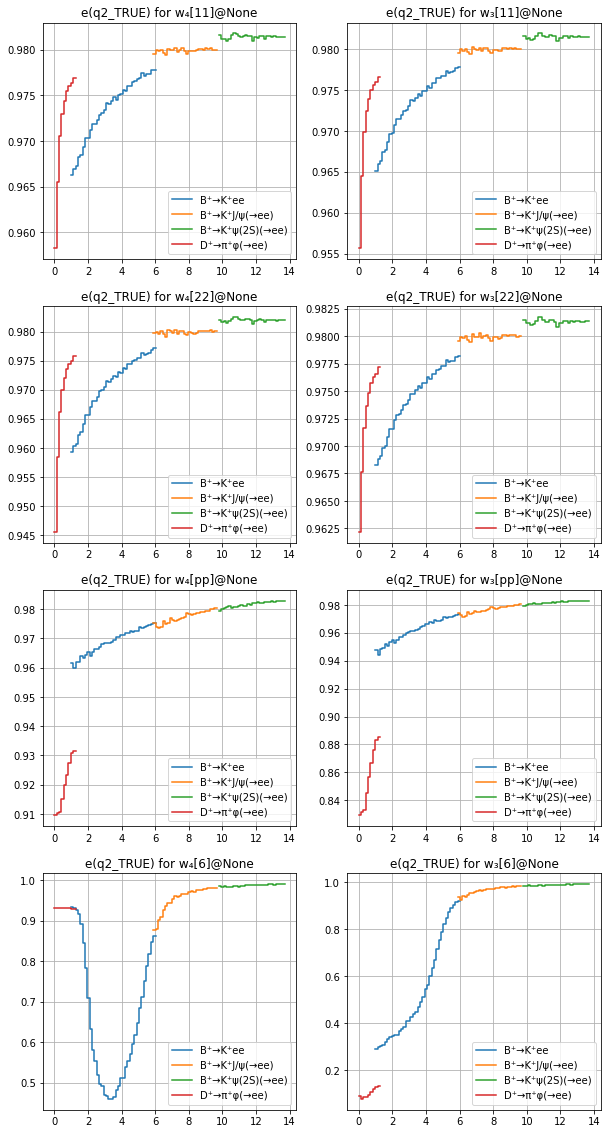

In [107]:
plot_e_all("q2_TRUE", results, np.linspace(0,14,101))

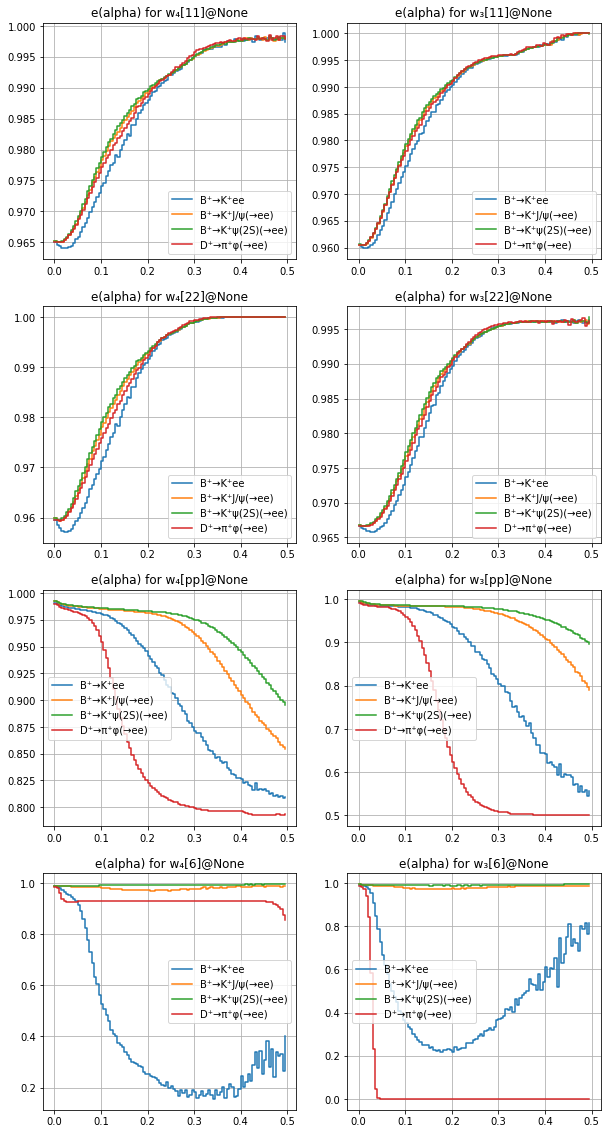

In [109]:
plot_e_all("alpha", results, np.linspace(0,0.5,101))

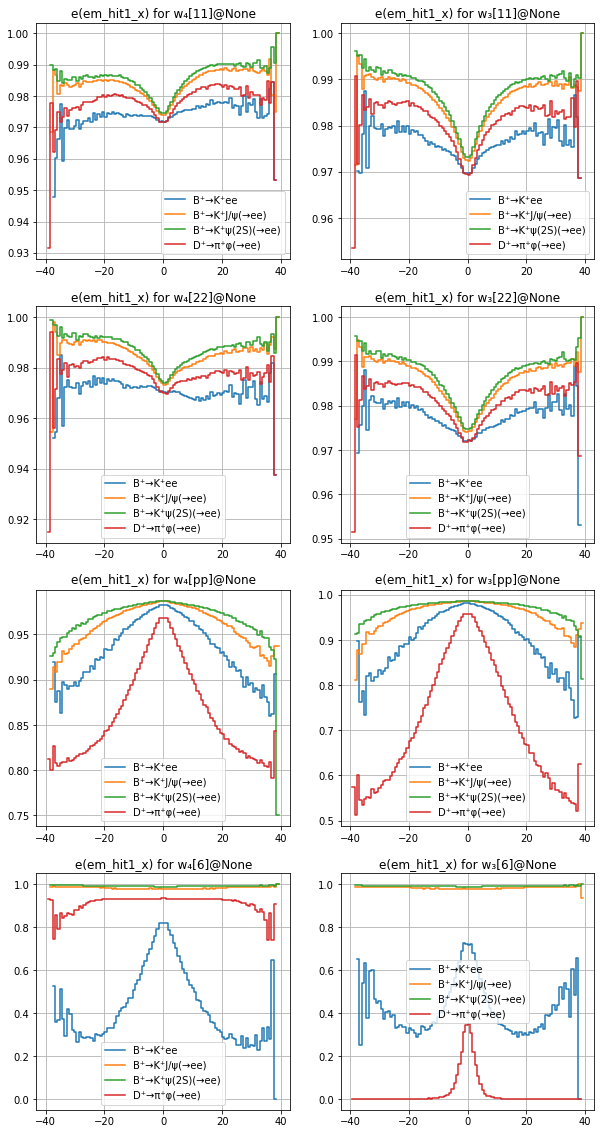

In [111]:
plot_e_all("em_hit1_x", results, np.linspace(-40,40,101))

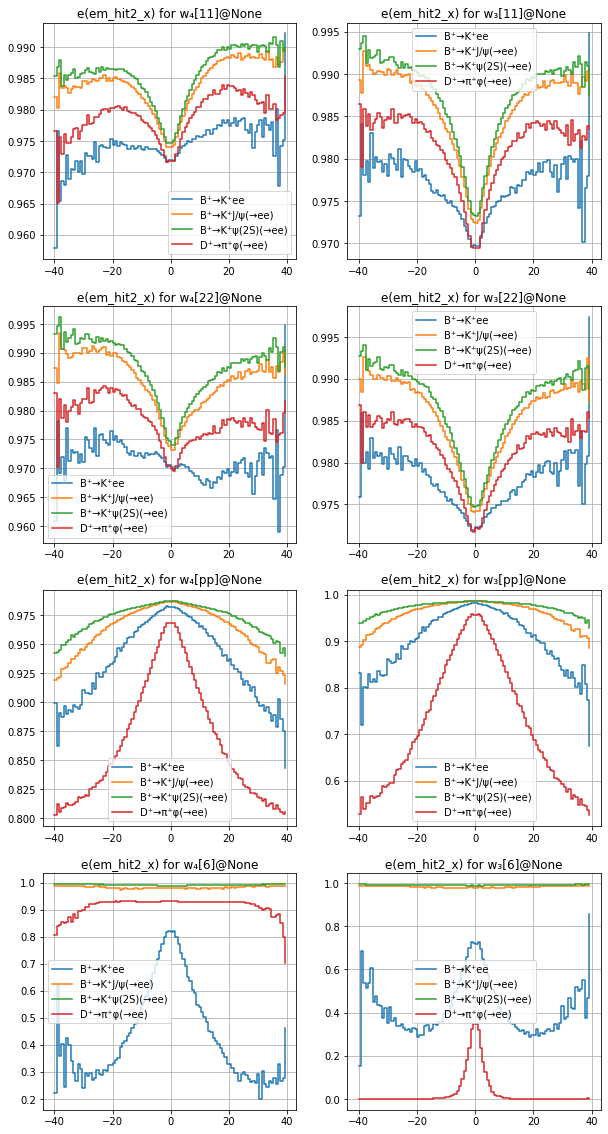

In [113]:
plot_e_all("em_hit2_x", results, np.linspace(-40,40,101))

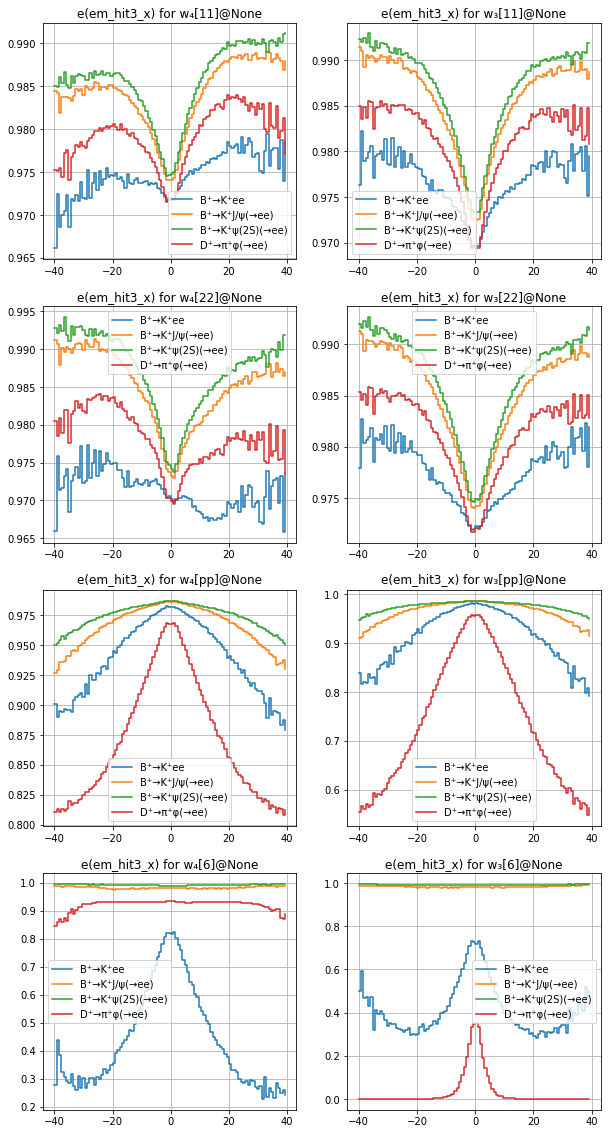

In [116]:
plot_e_all("em_hit3_x", results, np.linspace(-40,40,101))

### Blur

In [ ]:
def blur(w, sigma, step=0.01):
    sc = w.model[0]
    
    x_min, y_min = sc.min
    x_max, y_max = sc.max
    
    x1, y1 = sc.transform([[x_min, y_min]])[0]
    x2, y2 = sc.transform([[x_max, y_max]])[0]
    
    xval = np.arange(x1-sigma, x2+sigma, step)
    yval = np.arange(y1-sigma, y2+sigma, step)
    v = np.asarray(np.meshgrid(xval, yval)).reshape(2,-1).transpose()
    X = sc.inverse_transform(v)
    image = as_numpy(w)(X).reshape(yval.size, xval.size)
    print(image.T.shape)
    
    import scipy.ndimage
    filtered = scipy.ndimage.gaussian_filter(image, sigma=sigma/step)
    
    import scipy.interpolate
    inter = scipy.interpolate.interp2d(xval, yval, filtered)
    
    return lambda v : np.asarray([inter(x,y) for x, y in sc.transform(v)])

In [ ]:
m = results[None,"₄[α,p]"]
f00 = as_numpy(m.model)
f0 = blur(m, sigma=0.0, step=0.01)
f1 = blur(m, sigma=0.1, step=0.01)
f2 = blur(m, sigma=0.2, step=0.01)
f4 = blur(m, sigma=0.4, step=0.01)

In [ ]:
plot_field(f00, m.model[0], name="no blur")
plot_field(f0, m.model[0], name="sigma=0")
plot_field(f1, m.model[0], name="sigma=0.1")
plot_field(f2, m.model[0], name="sigma=0.2")
plot_field(f4, m.model[0], name="sigma=0.4")

In [ ]:
def quality_np(datasets, scaler, estimators, refname, name):
    df_w = pd.DataFrame()
    df_w.columns.name = name
    for i, w in enumerate(estimators):
        name1 = "w%s" % i
        r_name = "R%s" % i
        df_w[name1] = None
        for s in datasets:
            ds = Dataset(scaler.features, [s], aliases, name)
            x = to_numpy(ds.X())
            wd = w(x)
            df_w.loc[s.name(),name1] = 1-np.mean(wd).item()
        df_w[r_name] = df_w.loc[refname,name1] / df_w[name1]
    return df_w

In [ ]:
quality_np(train_ds, m.model[0], [f00,f0,f1,f2,f4], channel_names[1], "train")

In [ ]:
tmp = _

In [ ]:
make_R(tmp.iloc[:,::2], "R-1,%").iloc[[0,2,3],:]